### Описание набора данных

| Column Name                            | Description                                               |
|----------------------------------------|-----------------------------------------------------------|
| FORCE_2020_LITHOFACIES_CONFIDENCE     | Qualitative measure of interpretation confidence          |
| FORCE_2020_LITHOFACIES_LITHOLOGY      | Interpreted Lithofacies                                   |
| RDEP                                   | Deep Reading Resistivity measurement                      |
| RSHA                                   | Shallow Reading Resistivity measurement                   |
| RMED                                   | Medium Deep Reading Resistivity measurement               |
| RXO                                    | Flushed Zone Resistivity measurement                      |
| RMIC                                   | Micro Resistivity measurement                             |
| SP                                     | Self Potential Log                                        |
| DTS                                    | Shear wave sonic log (us/ft)                              |
| DTC                                    | Compressional waves sonic log (us/ft)                     |
| NPHI                                   | Neutron Porosity log                                      |
| PEF                                    | Photo Electric Factor log                                 |
| GR                                     | Gamma Ray Log                                             |
| RHOB                                   | Bulk Density Log                                          |
| DRHO                                   | Density Correction log                                    |
| CALI                                   | Caliper log                                               |
| BS                                     | Borehole Size                                             |
| DCAL                                   | Differential Caliper log                                  |
| ROPA                                   | Average Rate of Penetration                               |
| SGR                                    | Spectra Gamma Ray log                                     |
| MUDWEIGHT                              | Weight of Drilling Mud                                    |
| ROP                                    | Rate of Penetration                                       |
| DEPTH_MD                               | Measured Depth                                            |
| x_loc                                  | X location of sample                                      |
| y_loc                                  | Y location of sample                                      |
| z_loc                                  | Z (TVDSS) Depth of sample                                 |


Данные содержат столбцы метаданных:
* WELL: название скважины
* DEPTH_MD: измеренная глубина
* X_LOC: UTM координата X
* Y_LOC: UTM координата Y
* Z_LOC: ГЛУБИНА
* GROUP: группа литостратиграфии NPD
* FORMATION: формация литостратиграфии NPD

Данные содержат кривые каротажа скважины. Например, следующие:
* BS: Размер бита
* CALI: Калипер
* RDEP: Глубокое сопротивление
* RHOB: Объемная плотность
* GR: Сырые данные гамма-излучения
* SGR: Спектральный гамма-излучение
* RMED: Среднее сопротивление
* ROP: Скорость бурения
* NPHI: Нейтронная пористость
* PEF: Фотоэлектрический коэффициент поглощения
* RSHA: Поверхностное сопротивление
* DTS: Звуковая скорость (поперечная)
* DTC: Звуковая скорость (компрессионная)

а также интерпретацию

* FORCE_2020_LITHOFACIES_LITHOLOGY: классификация литологии
* FORCE_2020_LITHOFACIES_CONFIDENCE: уверенность в интерпретации литологии (1: высокая, 2: средняя, 3: низкая)

### 1. Установка библиотек и загрузка данных

In [9]:
import joblib
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from numpy import std
from numpy import mean
import lightgbm as lgbm
import plotly.express as px
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import matplotlib.colors as colors
from sklearn.metrics import f1_score
from pandas import DataFrame, Series
from scipy.ndimage import median_filter
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree, export_text
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report


sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 16)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('../data/Vovle/CSV_train.csv', sep=';')

In [4]:
df.head()

WELL  DEPTH_MD         X_LOC      Y_LOC       Z_LOC         GROUP  \
0  15/9-13   494.528  437641.96875  6470972.5 -469.501831  NORDLAND GP.   
1  15/9-13   494.680  437641.96875  6470972.5 -469.653809  NORDLAND GP.   
2  15/9-13   494.832  437641.96875  6470972.5 -469.805786  NORDLAND GP.   
3  15/9-13   494.984  437641.96875  6470972.5 -469.957794  NORDLAND GP.   
4  15/9-13   495.136  437641.96875  6470972.5 -470.109772  NORDLAND GP.   

  FORMATION       CALI  RSHA      RMED  ...        ROP  DTS  DCAL      DRHO  \
0       NaN  19.480835   NaN  1.611410  ...  34.636410  NaN   NaN -0.574928   
1       NaN  19.468800   NaN  1.618070  ...  34.636410  NaN   NaN -0.570188   
2       NaN  19.468800   NaN  1.626459  ...  34.779556  NaN   NaN -0.574245   
3       NaN  19.459282   NaN  1.621594  ...  39.965164  NaN   NaN -0.586315   
4       NaN  19.453100   NaN  1.602679  ...  57.483765  NaN   NaN -0.597914   

   MUDWEIGHT  RMIC  ROPA  RXO  FORCE_2020_LITHOFACIES_LITHOLOGY  \
0        NaN   NaN   NaN  NaN                             65000   
1        NaN   NaN   NaN  NaN                             65000   
2        NaN   NaN   NaN  NaN                             65000   
3        NaN   NaN   NaN  NaN                             65000   
4        NaN   NaN   NaN  NaN                             65000   

   FORCE_2020_LITHOFACIES_CONFIDENCE  
0                                1.0  
1                                1.0  
2                                1.0  
3                                1.0  
4                                1.0  

[5 rows x 29 columns]

In [5]:
columns_rows = df.shape

In [7]:
print('Количество столбцов {:}'.format(columns_rows[1]), 'Количество строк {:}'.format(columns_rows[0]))

Количество столбцов 29 Количество стррок 1170511


### 2. EDA

Просмотр количества значений и типов столбцов

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 29 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   WELL                               1170511 non-null  object 
 1   DEPTH_MD                           1170511 non-null  float64
 2   X_LOC                              1159736 non-null  float64
 3   Y_LOC                              1159736 non-null  float64
 4   Z_LOC                              1159736 non-null  float64
 5   GROUP                              1169233 non-null  object 
 6   FORMATION                          1033517 non-null  object 
 7   CALI                               1082634 non-null  float64
 8   RSHA                               630650 non-null   float64
 9   RMED                               1131518 non-null  float64
 10  RDEP                               1159496 non-null  float64
 11  RHOB                    

Описательная статистика численных столбцов

In [12]:
df.describe()

DEPTH_MD         X_LOC         Y_LOC         Z_LOC          CALI  \
count  1.170511e+06  1.159736e+06  1.159736e+06  1.159736e+06  1.082634e+06   
mean   2.184087e+03  4.856310e+05  6.681276e+06 -2.138527e+03  1.318568e+01   
std    9.971821e+02  3.455641e+04  1.281524e+05  9.709426e+02  3.798907e+00   
min    1.360860e+02  4.268988e+05  6.406641e+06 -5.395563e+03  2.344000e+00   
25%    1.418597e+03  4.547996e+05  6.591327e+06 -2.811502e+03  9.429712e+00   
50%    2.076605e+03  4.769203e+05  6.737311e+06 -2.042785e+03  1.255575e+01   
75%    2.864393e+03  5.201532e+05  6.784886e+06 -1.391866e+03  1.671075e+01   
max    5.436632e+03  5.726328e+05  6.856661e+06 -1.110860e+02  2.827900e+01   

                RSHA          RMED          RDEP          RHOB            GR  \
count  630650.000000  1.131518e+06  1.159496e+06  1.009242e+06  1.170511e+06   
mean       10.694664  4.986978e+00  1.069103e+01  2.284987e+00  7.091370e+01   
std       100.642597  5.467269e+01  1.139480e+02  2.532835e-01  3.423149e+01   
min         0.000100 -8.418695e-03  3.170056e-02  7.209712e-01  1.092843e-01   
25%         0.854120  9.140862e-01  9.102396e-01  2.092203e+00  4.762722e+01   
50%         1.399020  1.443584e+00  1.439000e+00  2.321228e+00  6.836763e+01   
75%         3.099348  2.680930e+00  2.557220e+00  2.488580e+00  8.903551e+01   
max      2193.904541  1.988616e+03  1.999887e+03  3.457820e+00  1.076964e+03   

       ...            ROP            DTS           DCAL           DRHO  \
count  ...  535071.000000  174613.000000  298833.000000  987857.000000   
mean   ...     137.367965     204.655019       1.223849       0.012196   
std    ...    1539.383558      71.068461      54.372859       7.477798   
min    ...      -0.117977      69.163177     -12.215459   -7429.338867   
25%    ...       5.628000     155.936707       0.148438      -0.009253   
50%    ...      17.799999     188.200653       0.557320       0.001752   
75%    ...      34.812794     224.645081       1.299655       0.021702   
max    ...   47015.125000     676.578125   10011.422852       2.836938   

           MUDWEIGHT           RMIC           ROPA            RXO  \
count  316151.000000  176160.000000  192325.000000  327427.000000   
mean        1.216329       7.796809      23.505069     -95.779496   
std        10.180834      89.741807      22.632800     348.980030   
min         0.125818       0.056586    -999.250122    -999.900024   
25%         0.143792       0.891272      11.281895       0.687681   
50%         0.155774       1.967156      20.131153       1.366672   
75%         1.168307       5.084564      31.138481       3.420790   
max       185.730927   10000.000000     742.797852   35930.671875   

       FORCE_2020_LITHOFACIES_LITHOLOGY  FORCE_2020_LITHOFACIES_CONFIDENCE  
count                      1.170511e+06                       1.170332e+06  
mean                       6.138598e+04                       1.164258e+00  
std                        1.389170e+04                       4.451180e-01  
min                        3.000000e+04                       1.000000e+00  
25%                        6.500000e+04                       1.000000e+00  
50%                        6.500000e+04                       1.000000e+00  
75%                        6.500000e+04                       1.000000e+00  
max                        9.900000e+04                       3.000000e+00  

[8 rows x 26 columns]

Расположение скважин

In [14]:
well_names_uniq = df.WELL.unique()
X_cor = df.groupby(['WELL'])['X_LOC'].mean()  
Y_cor = df.groupby(['WELL'])['Y_LOC'].mean()
data_count = df.groupby(['WELL']).count().sum(axis='columns')

loc_wells_df = pd.DataFrame({'WELL':well_names_uniq, 'X_LOC': X_cor, 'Y_LOC': Y_cor, 'data_points': data_count})

In [15]:
xx = loc_wells_df.X_LOC
yy = loc_wells_df.Y_LOC
ss = loc_wells_df.data_points
ind = loc_wells_df.index

def mapPlot():
    fig, ax = plt.subplots(figsize=(18,10))

    sns.scatterplot(data=loc_wells_df, x=xx, y=yy, size=ss, alpha=.7,
                 palette=['red', 'blue', 'green'],sizes=(10, 300), ax=ax)

    ax.set_title('Well Distributions: circle size based on data availability', fontsize = '16')
    ax.set_xlabel('X_coordinate (UTM)', fontsize = '12')
    ax.set_ylabel('Y_coordinate (UTM)', fontsize = '12')

    for x,y,z in zip(xx,yy,ind):
        label_s = "{}".format(z)
        ax.annotate(label_s, (x,y),  textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize = '8') 

    ax.grid(True, color='0.6',axis='both', dashes=(5,2,1,2))

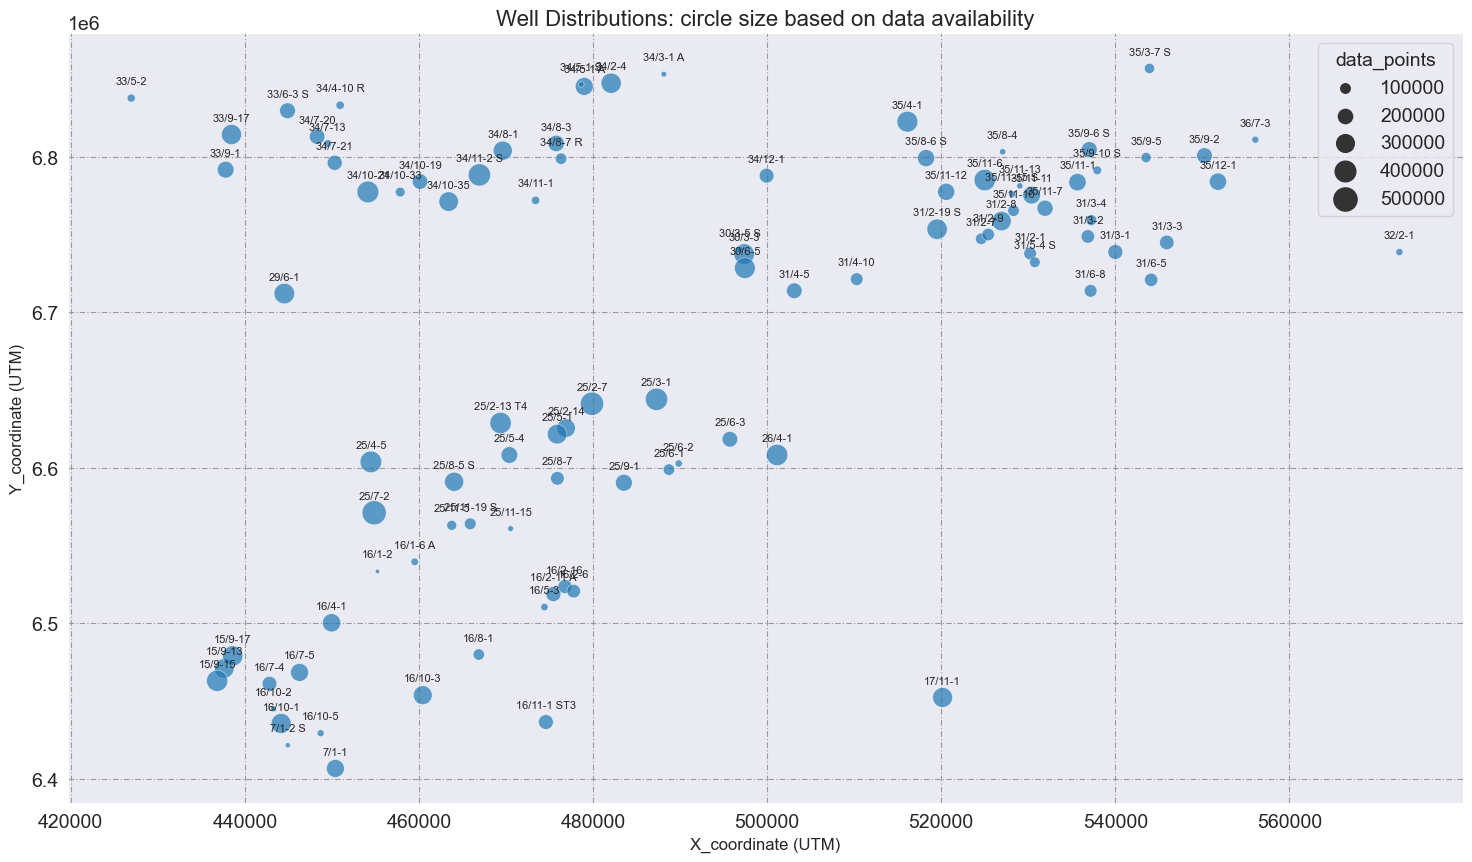

In [16]:
mapPlot()

#### 2.2 Визуализация каротажных кривых

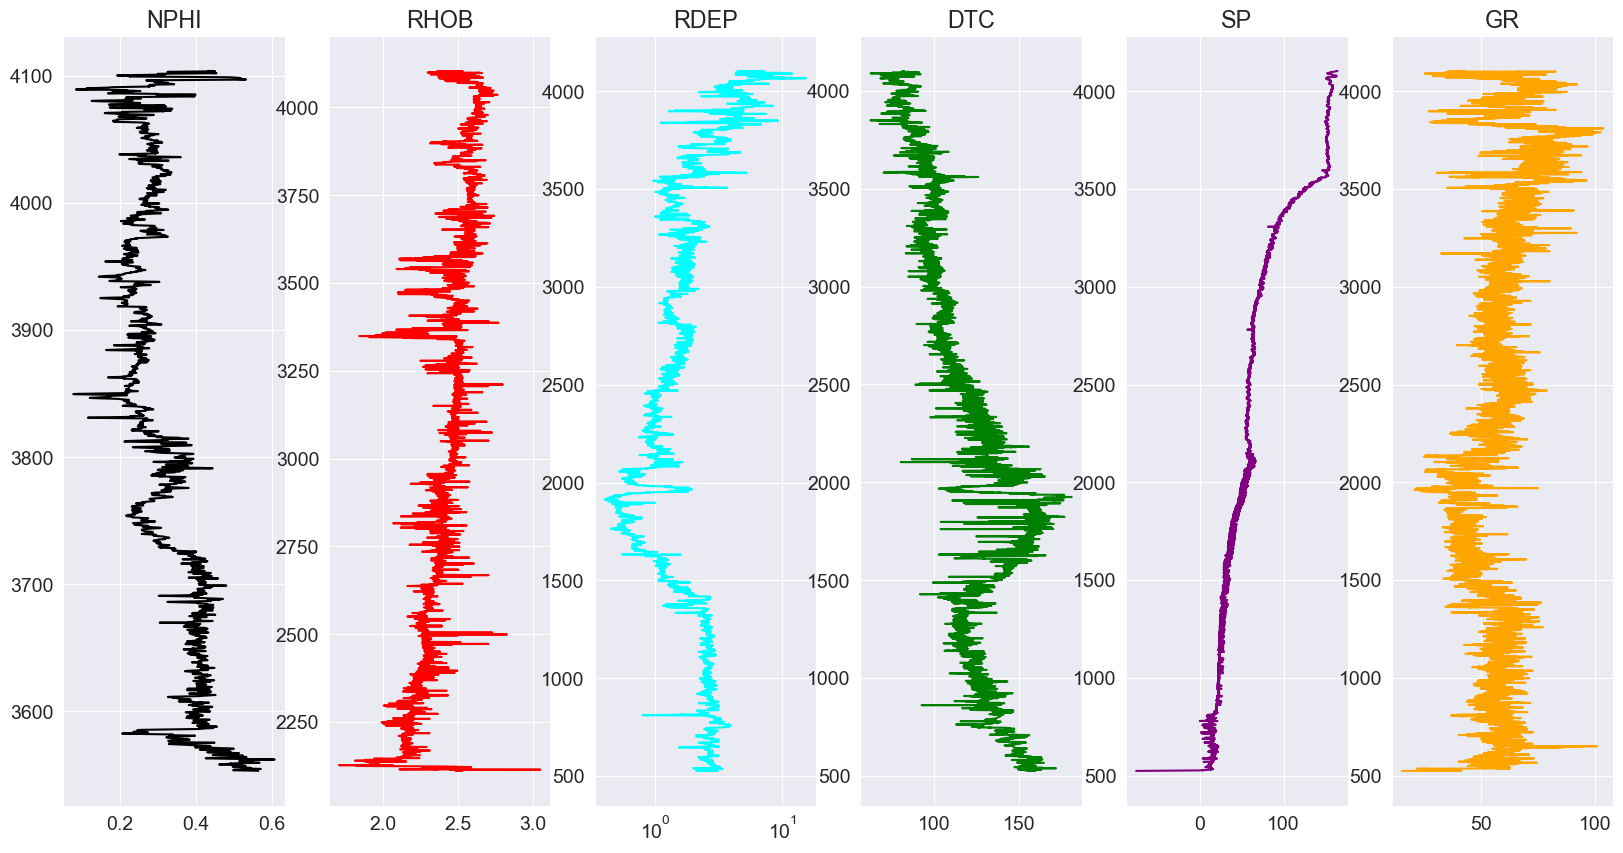

In [18]:
logs = ['NPHI', 'RHOB', 'RDEP', 'DTC', 'SP', 'GR']

fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

colors = ['black', 'red', 'cyan', 'green', 'purple', 'orange', 'blue', 'yellow', 'magenta', 'brown', 'pink', 'lime']

for i in range(len(logs)):
    if i == 2:
        ax[i].semilogx(df.loc[df['WELL'] == '34/2-4'][logs[i]], df.loc[df['WELL'] == '34/2-4']['DEPTH_MD'], color=colors[i])
    else:
        ax[i].plot(df.loc[df['WELL'] == '34/2-4'][logs[i]], df.loc[df['WELL'] == '34/2-4']['DEPTH_MD'], color=colors[i])

    ax[i].set_title(logs[i])

plt.show()

### 2.3 Визуализации

Визуализируем количество записей о каждой горной породе

In [52]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

df['FaciesLabels'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

Распределение количества записей о каждой из пород

In [23]:
df['FaciesLabels'].value_counts()

Shale              720803
Sandstone          168937
Sandstone/Shale    150455
Limestone           56320
Marl                33329
Tuff                15245
Chalk               10513
Halite               8213
Coal                 3820
Dolomite             1688
Anhydrite            1085
Basement              103
Name: FaciesLabels, dtype: int64

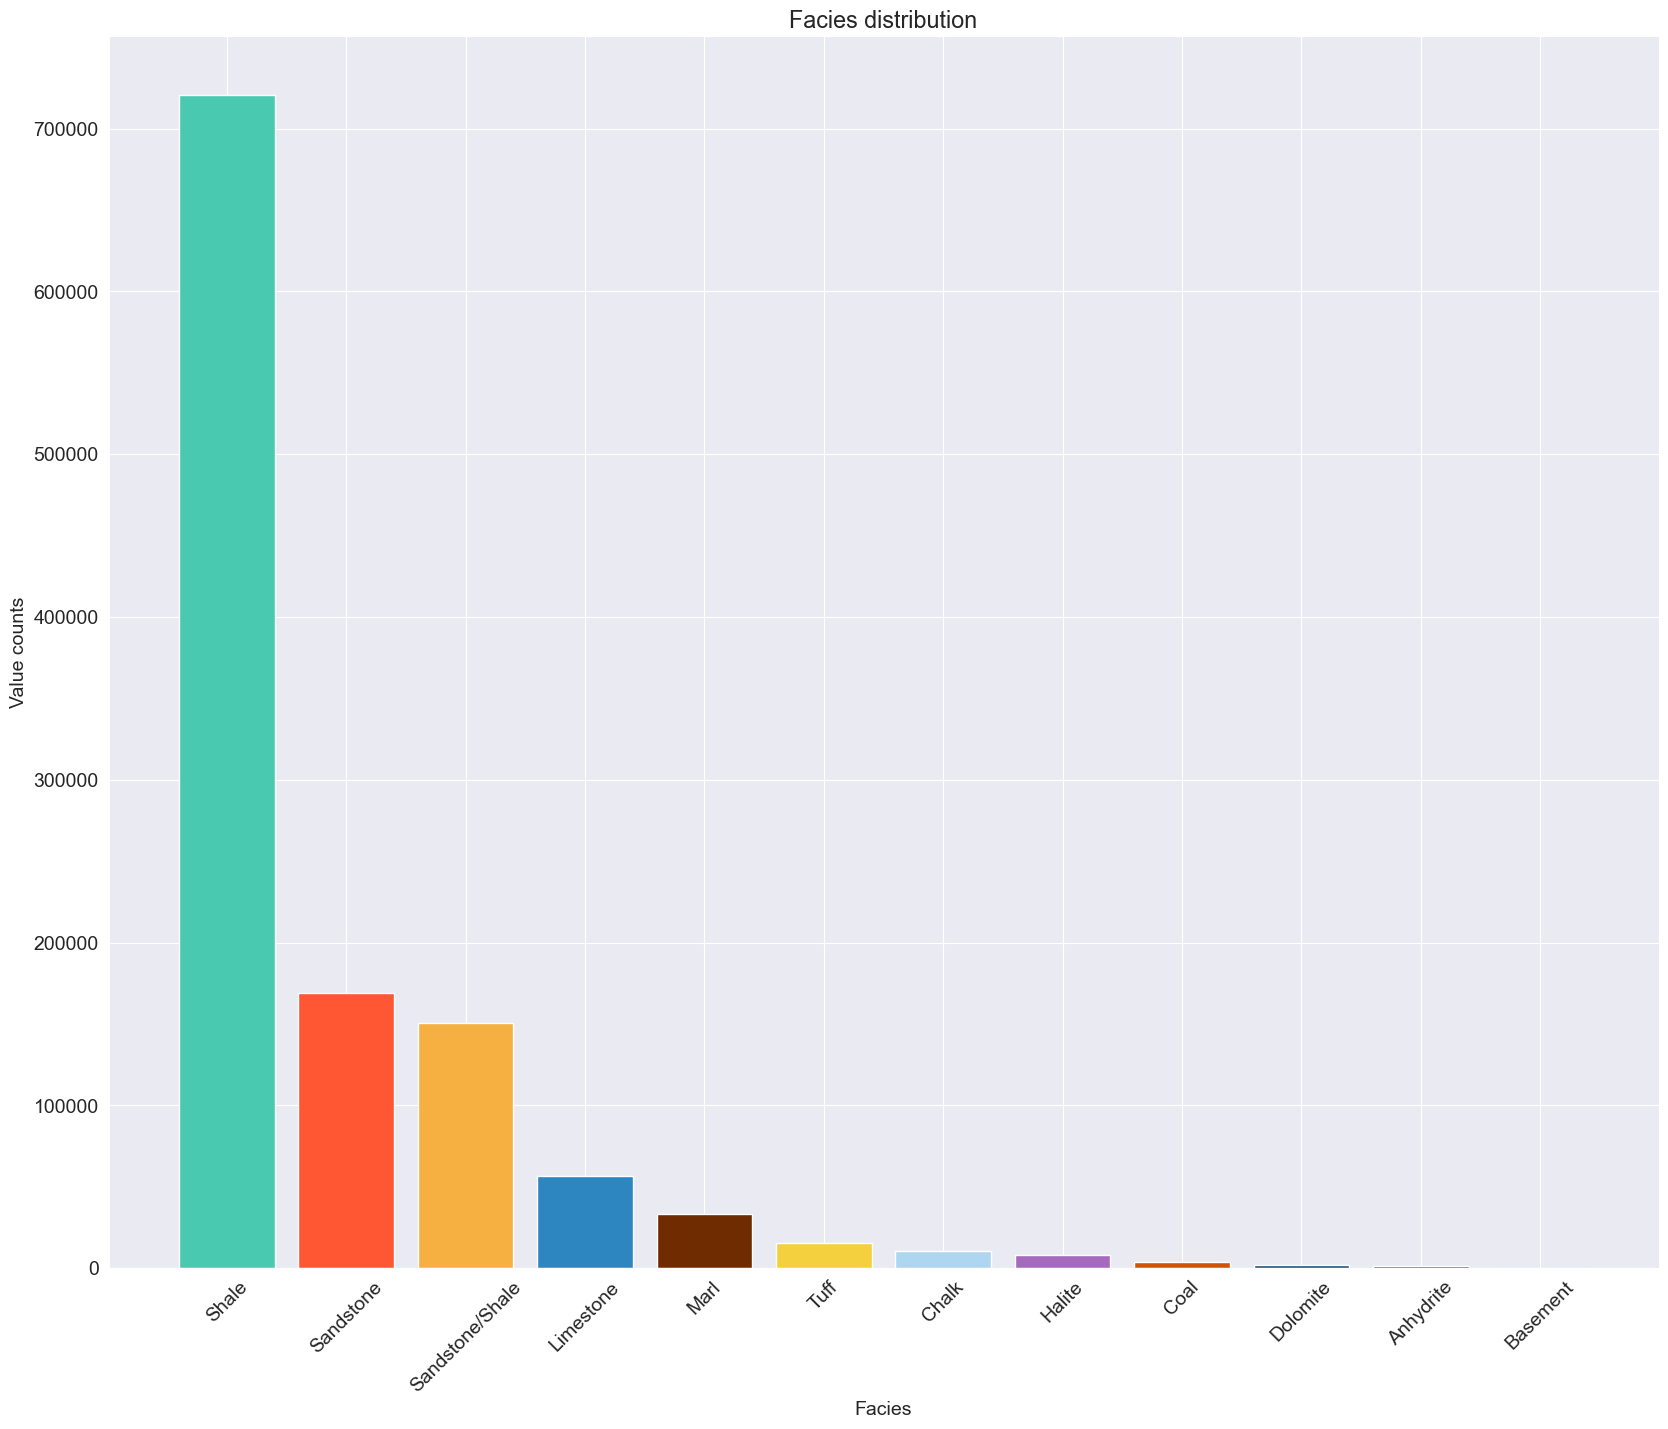

In [24]:
# Определение цветов для каждой фации
facies_colors = {'Sandstone': '#FF5733', 'Sandstone/Shale': '#F5B041', 'Shale': '#48C9B0',
                 'Marl': '#6E2C00', 'Dolomite': '#1B4F72', 'Limestone': '#2E86C1',
                 'Chalk': '#AED6F1', 'Halite': '#A569BD', 'Anhydrite': '#196F3D',
                 'Tuff': '#F4D03F', 'Coal': '#D35400', 'Basement': '#85929E'}

facies_counts = df['FaciesLabels'].value_counts()

plt.bar(facies_counts.index, facies_counts.values, color=[facies_colors[f] for f in facies_counts.index])
plt.title('Facies distribution')
plt.xlabel('Facies')
plt.ylabel('Value counts')

plt.xticks(rotation=45) 

plt.show()

Выбор признаков для решения задачи классификации

In [5]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

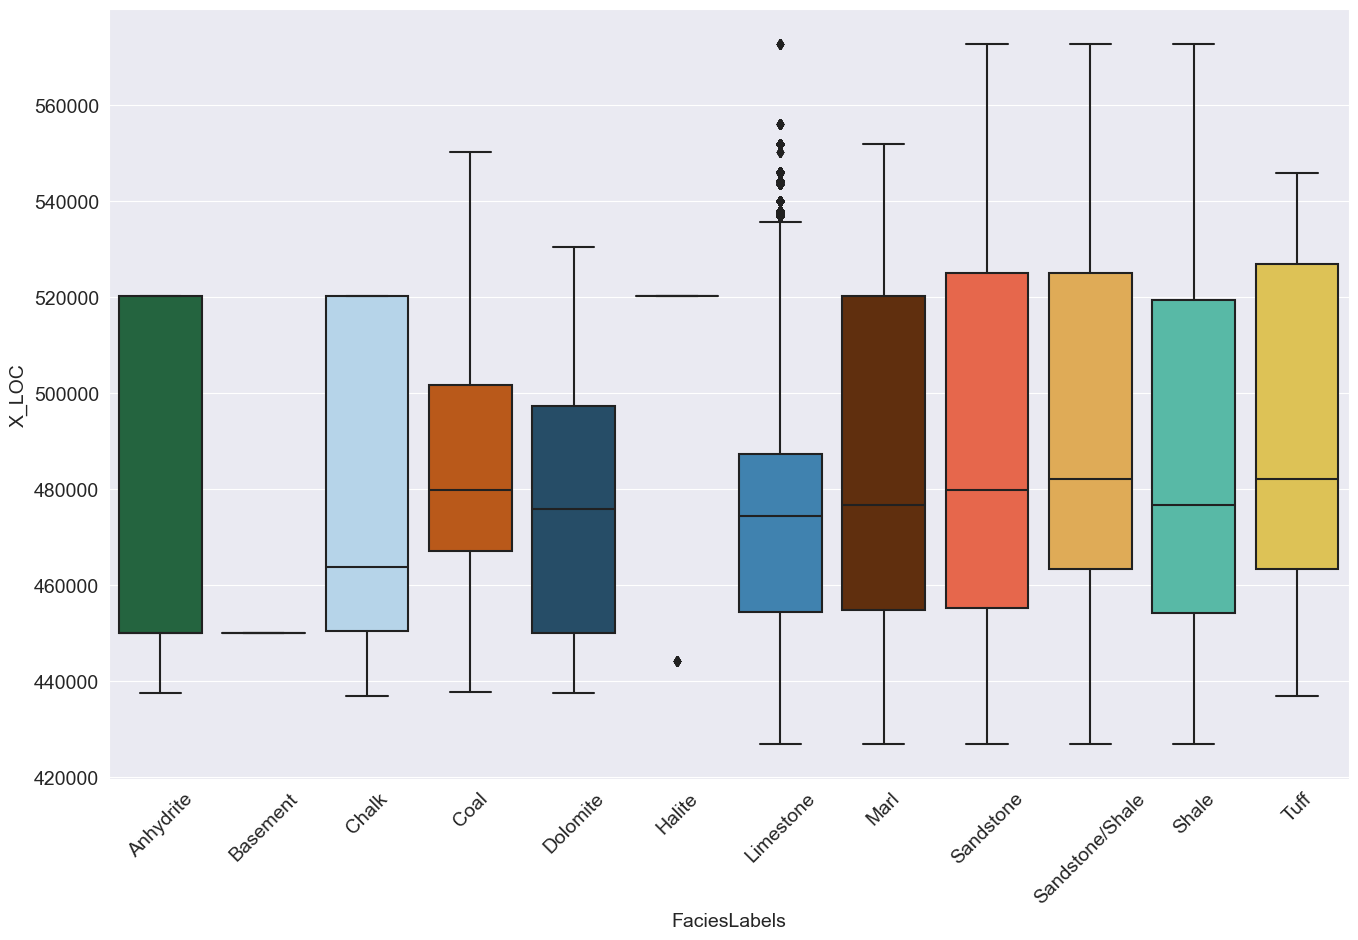

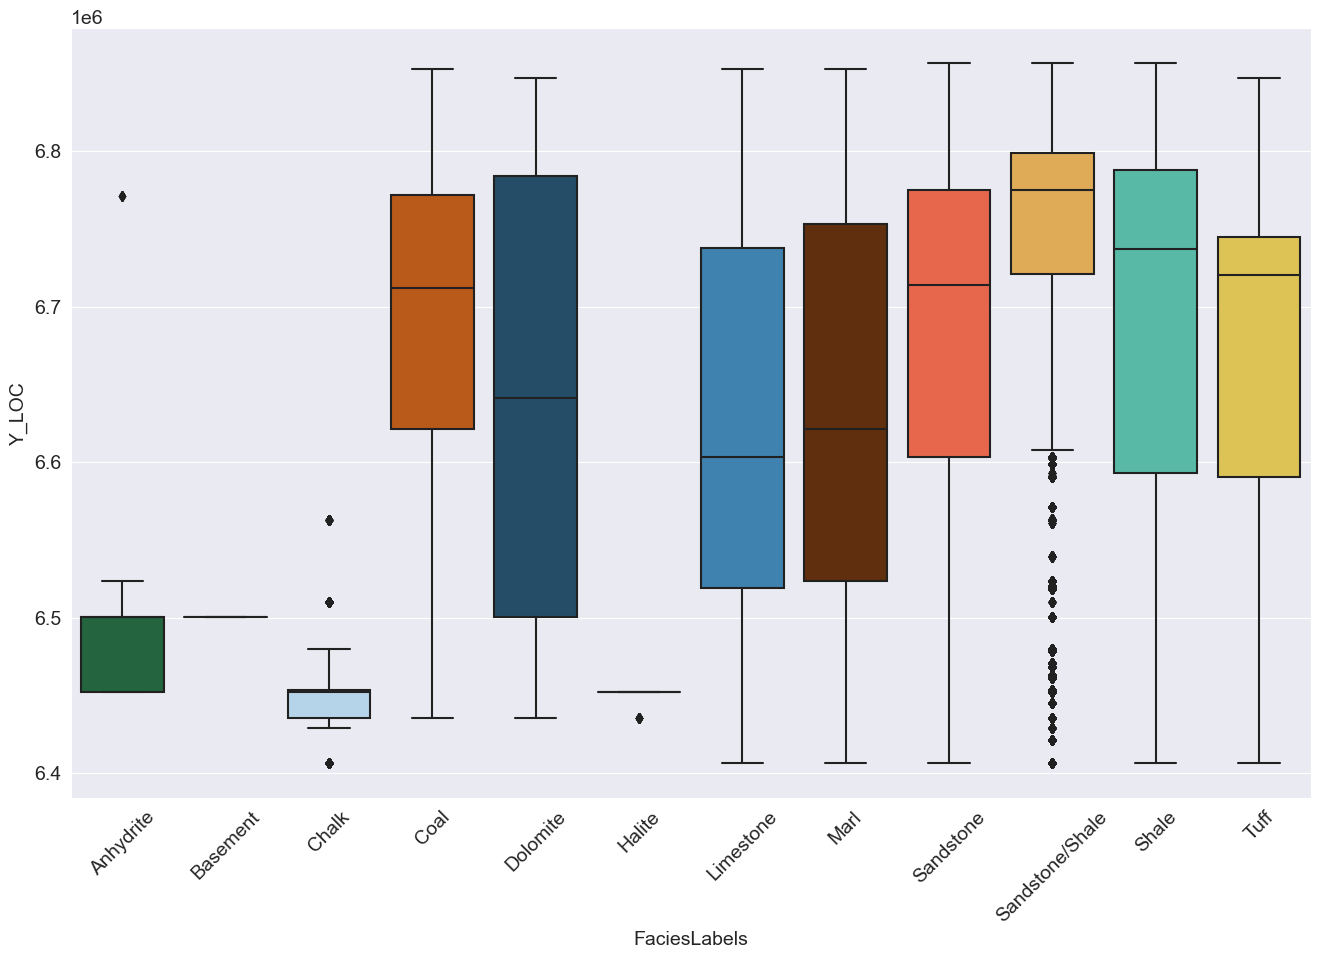

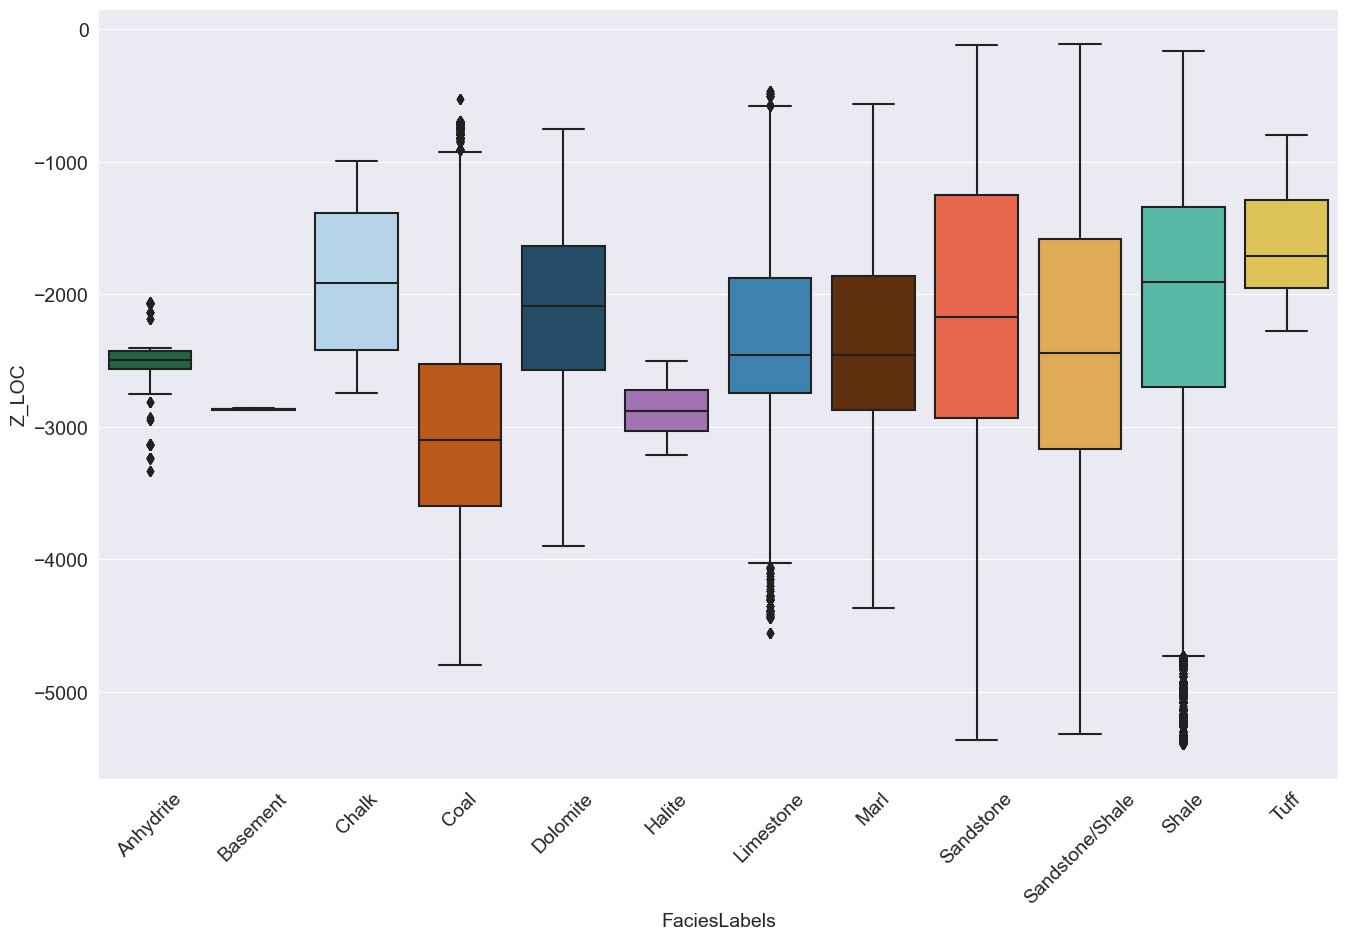

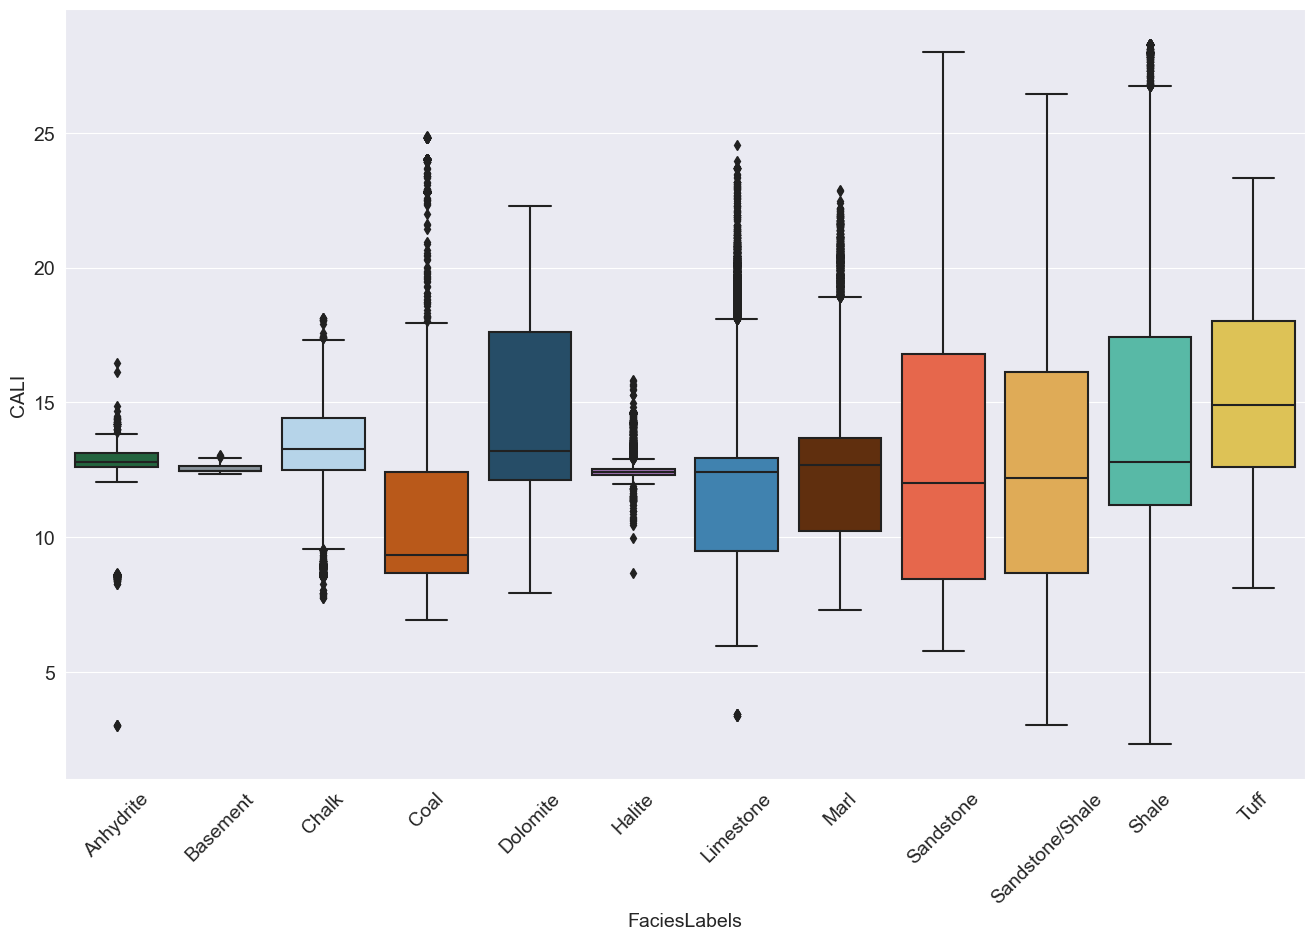

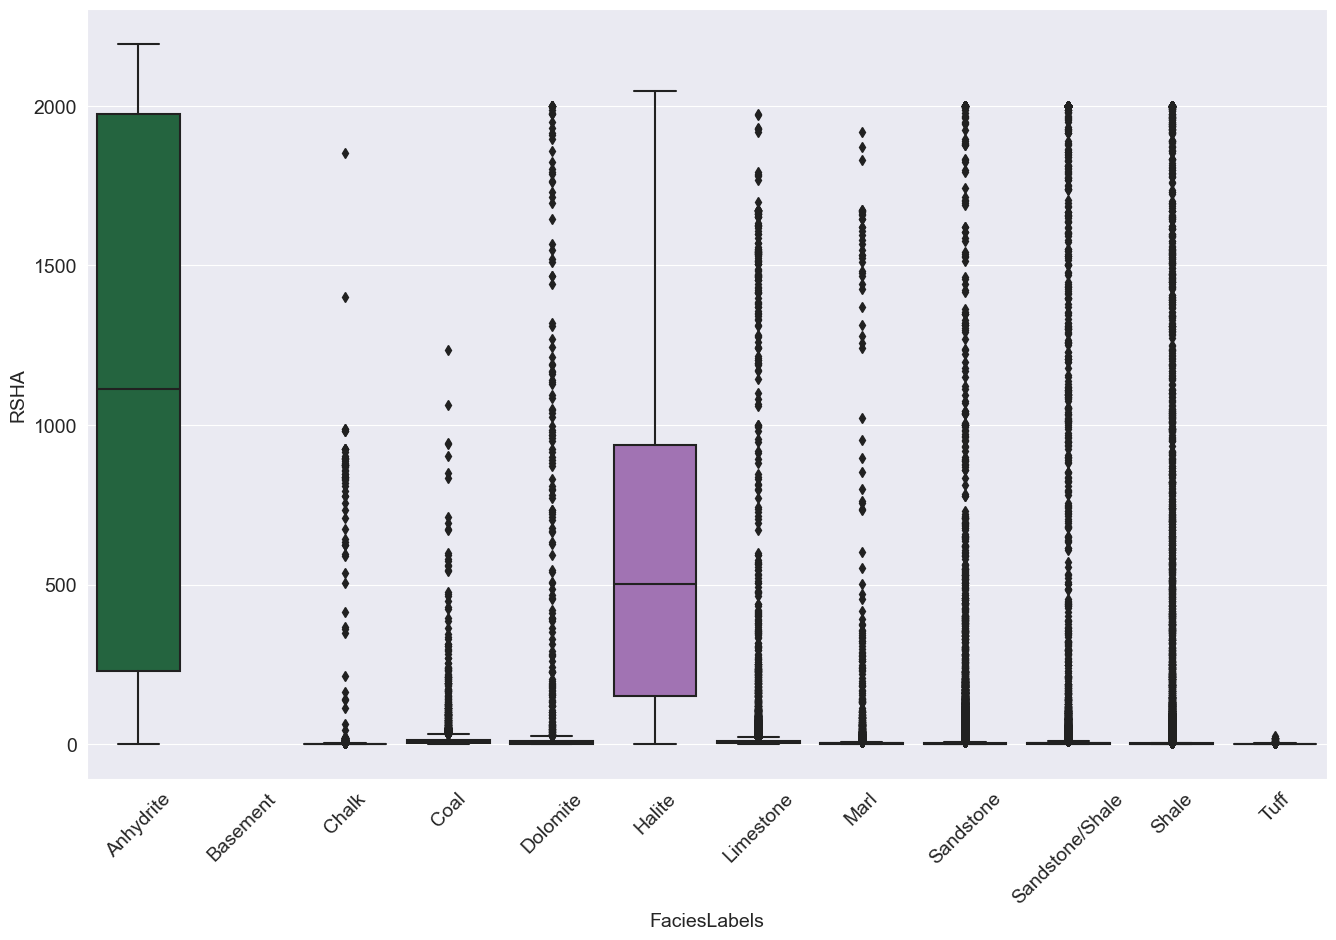

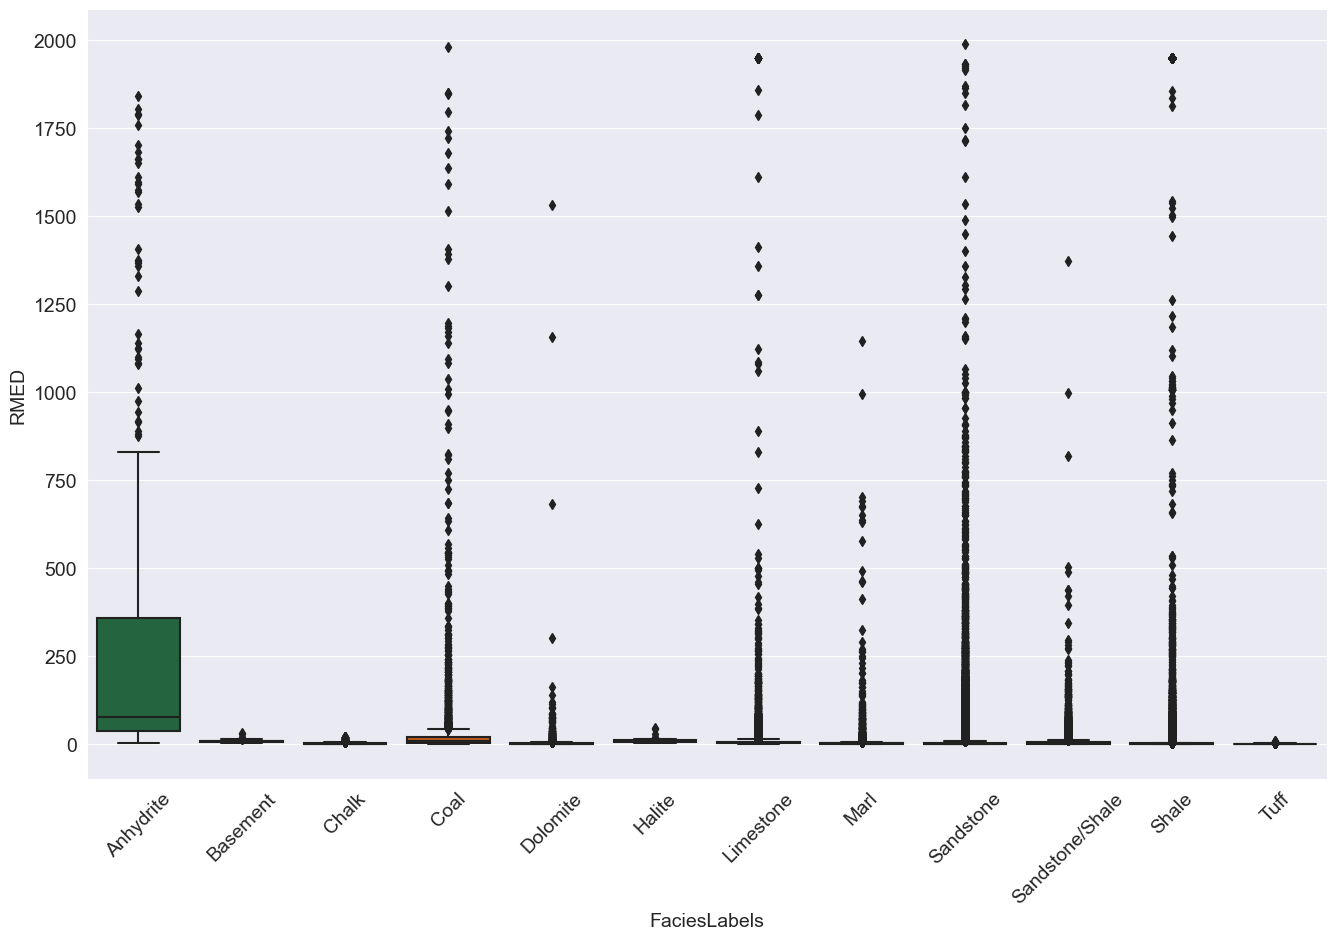

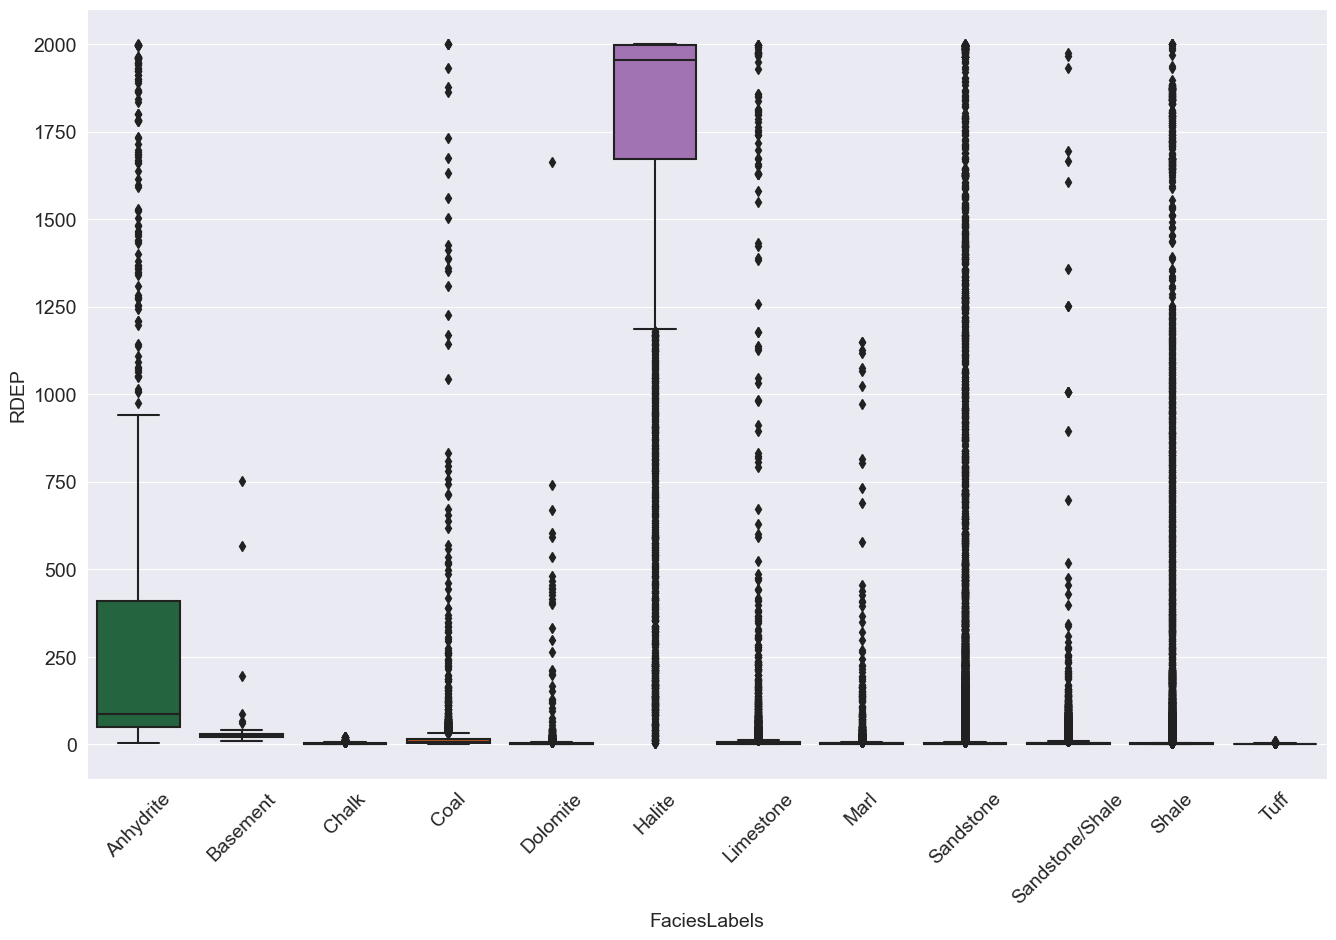

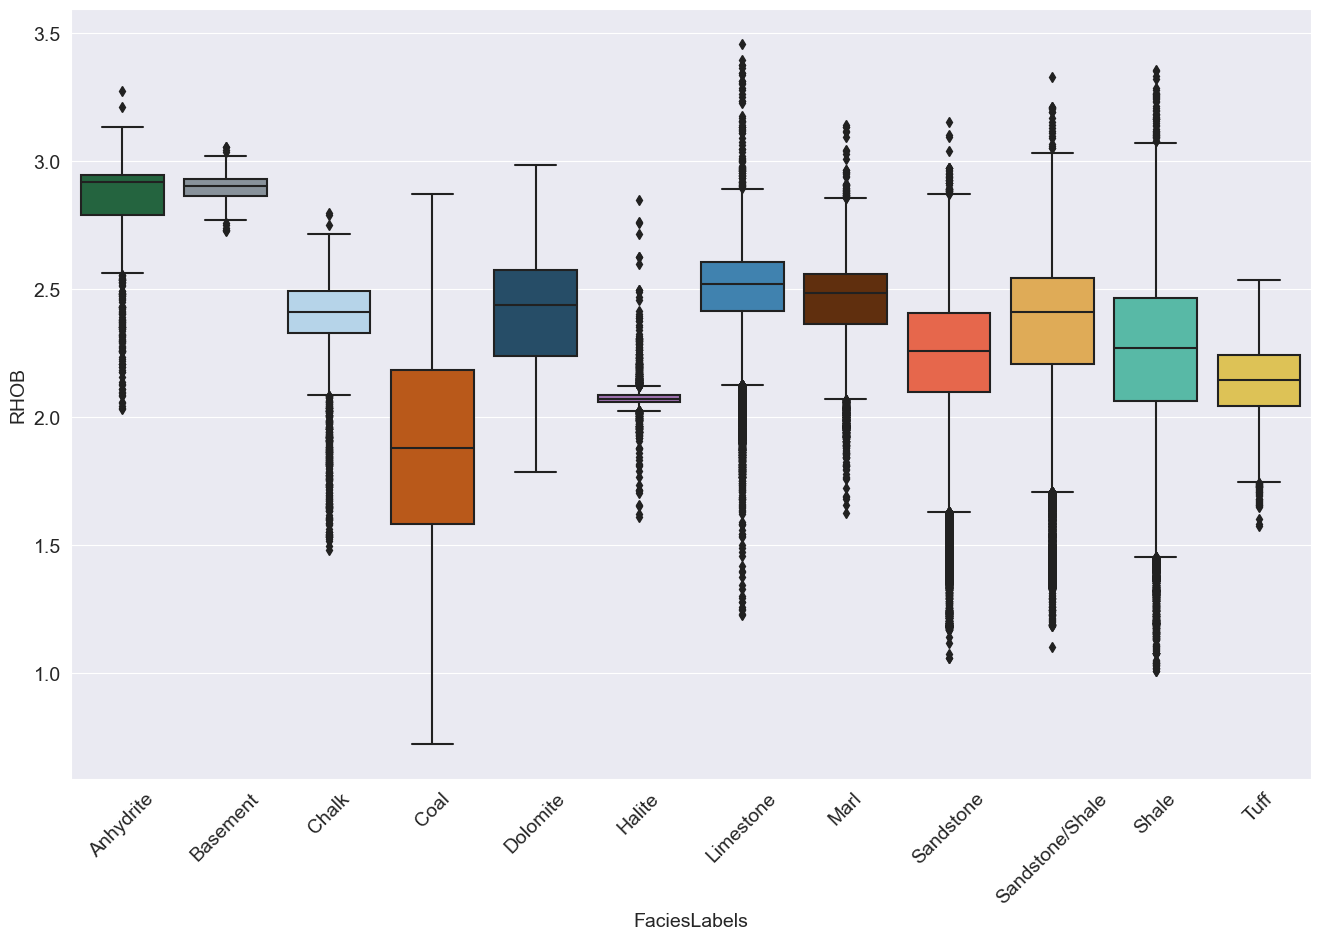

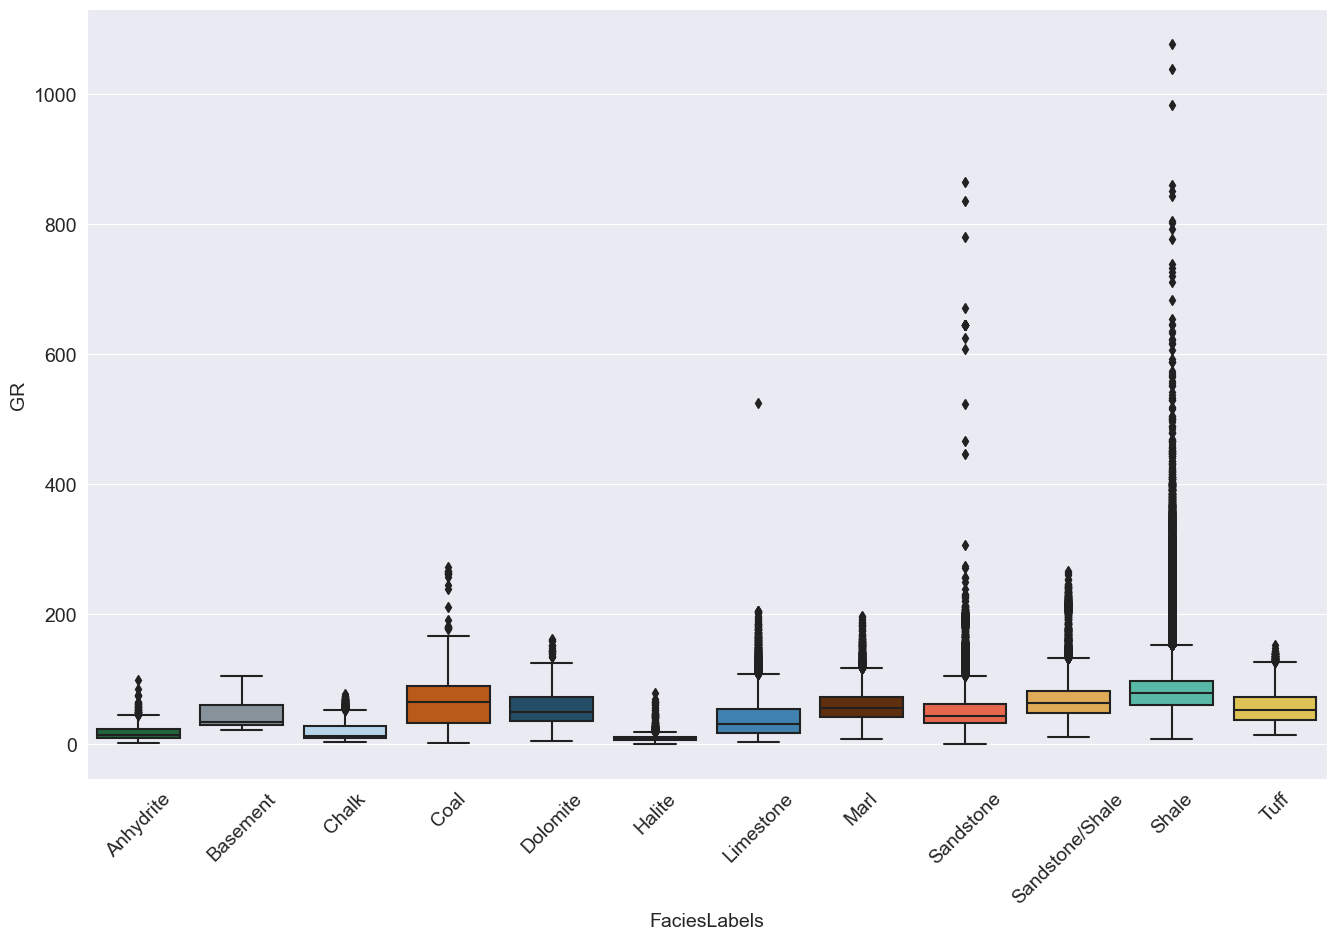

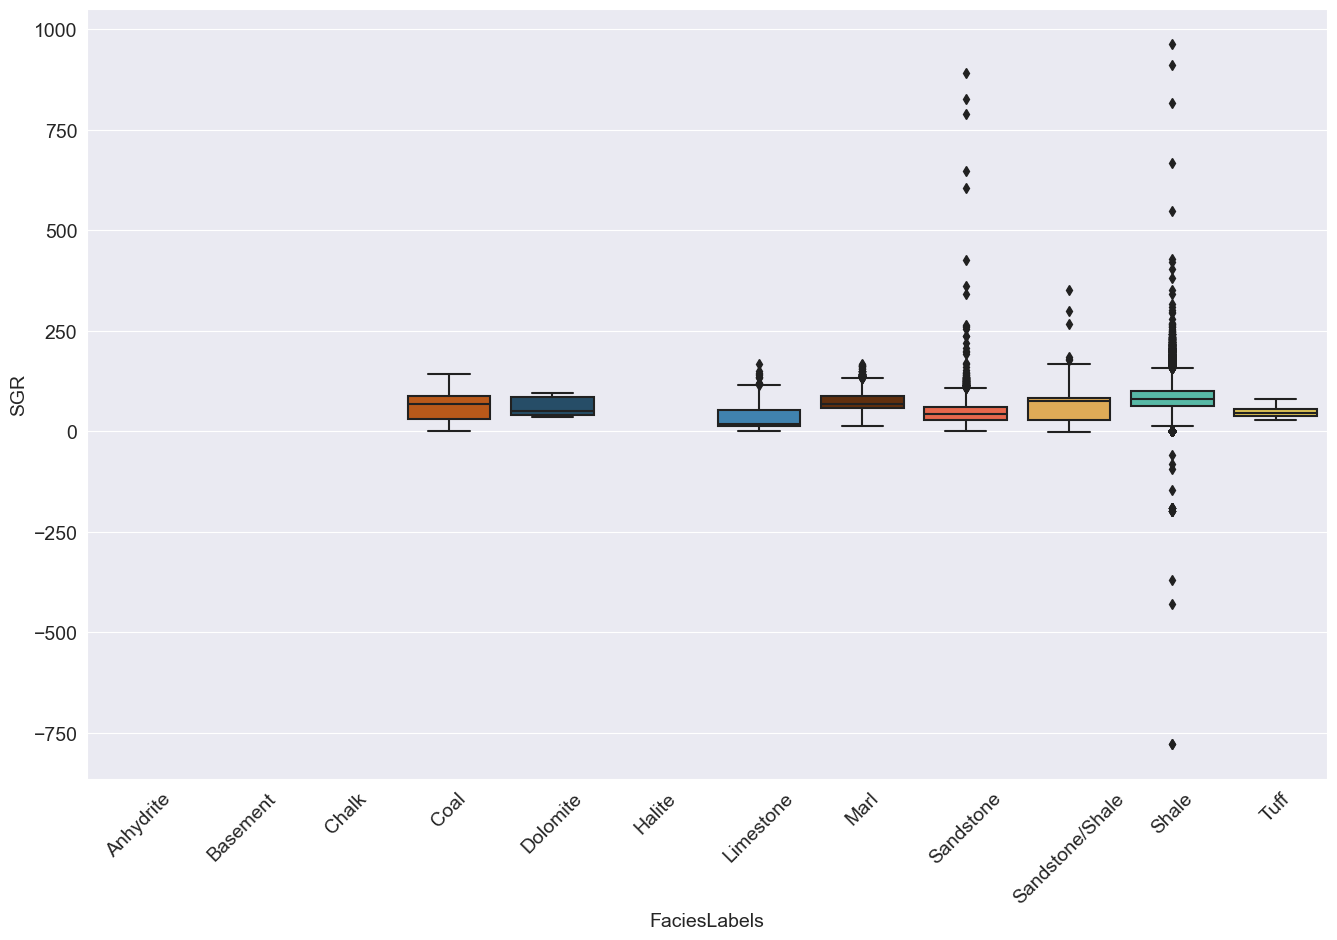

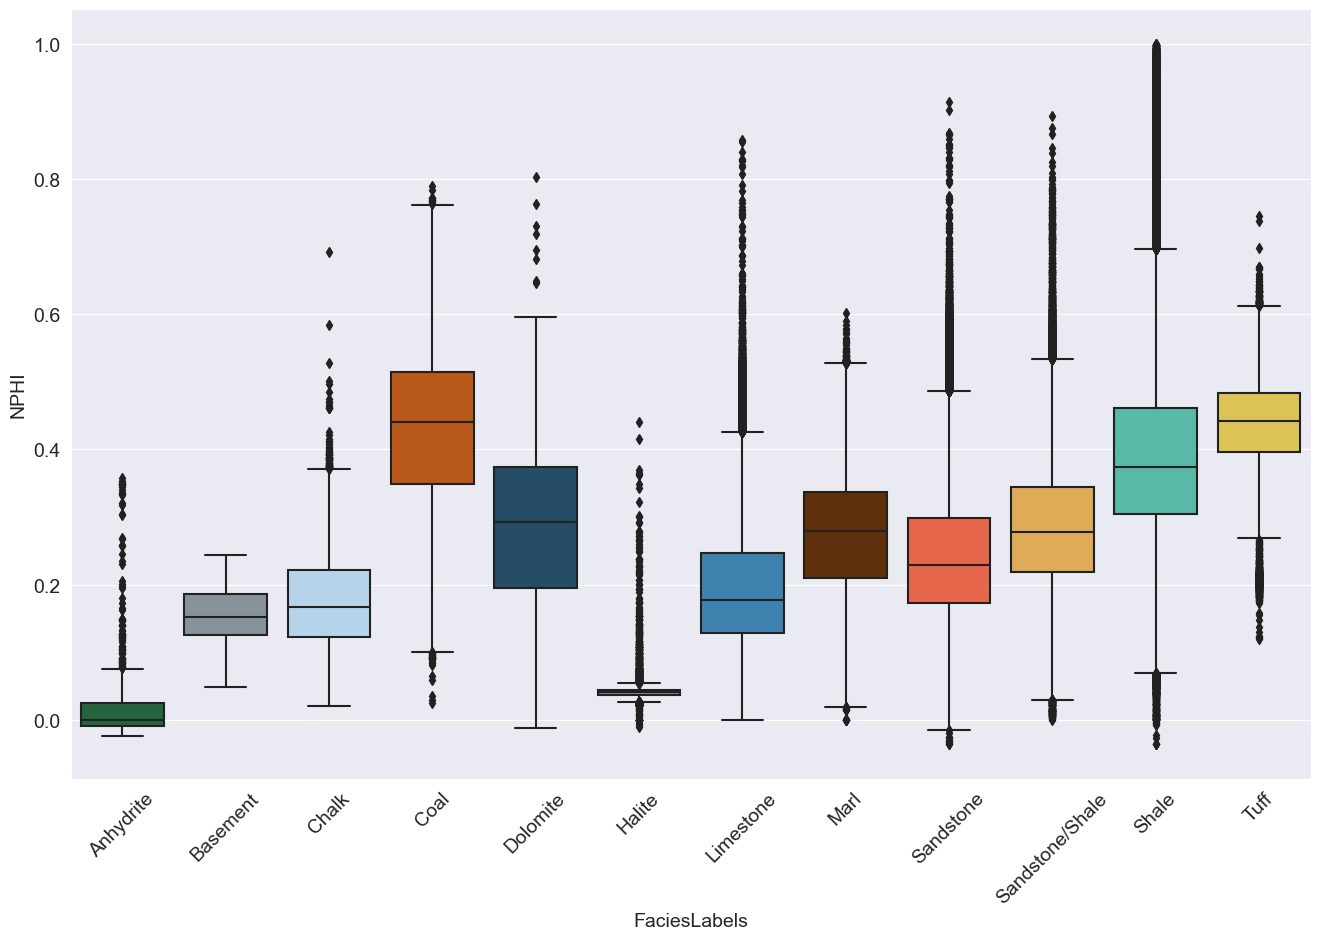

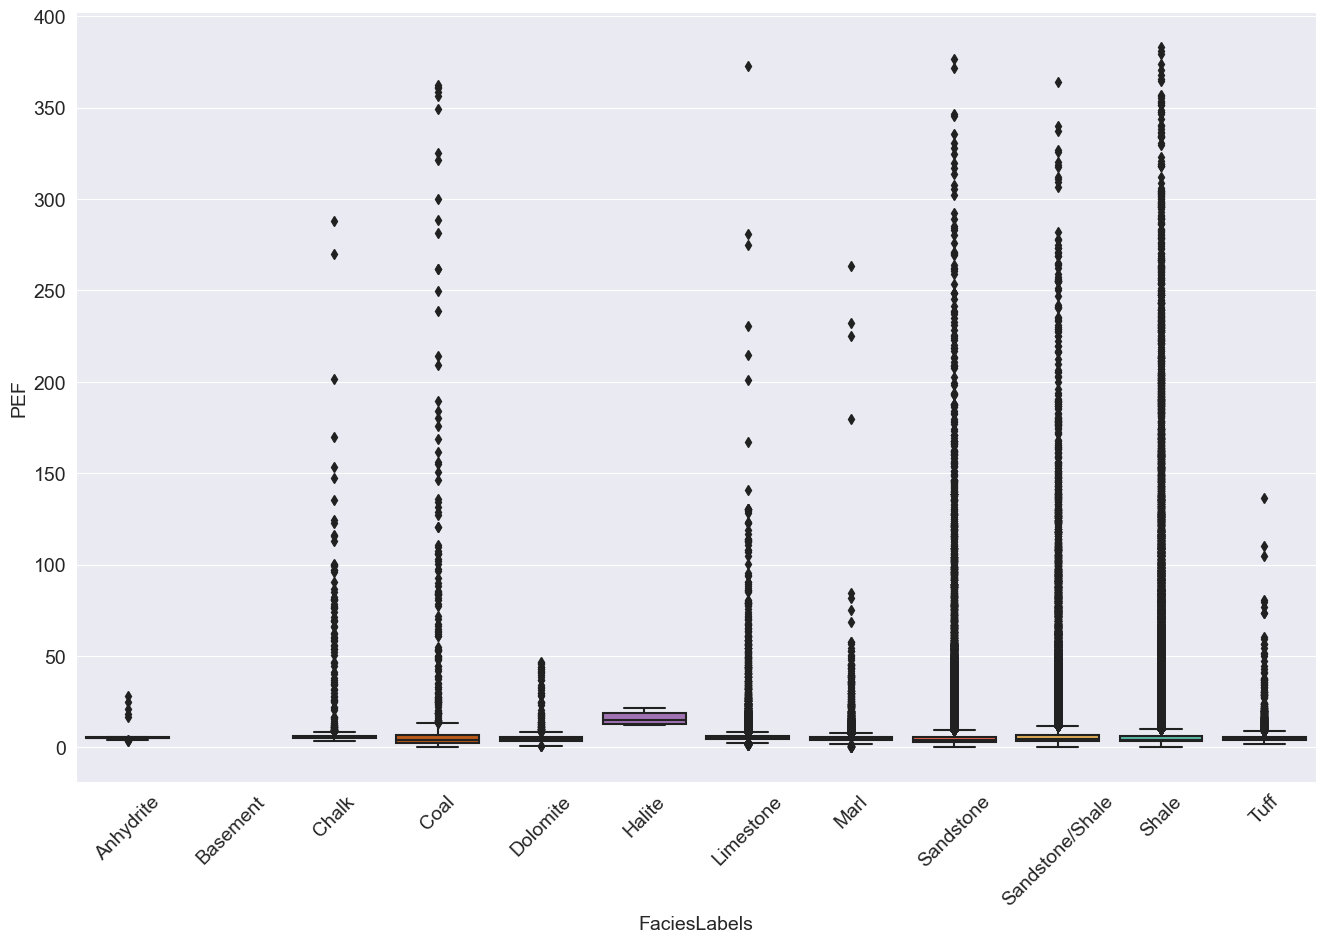

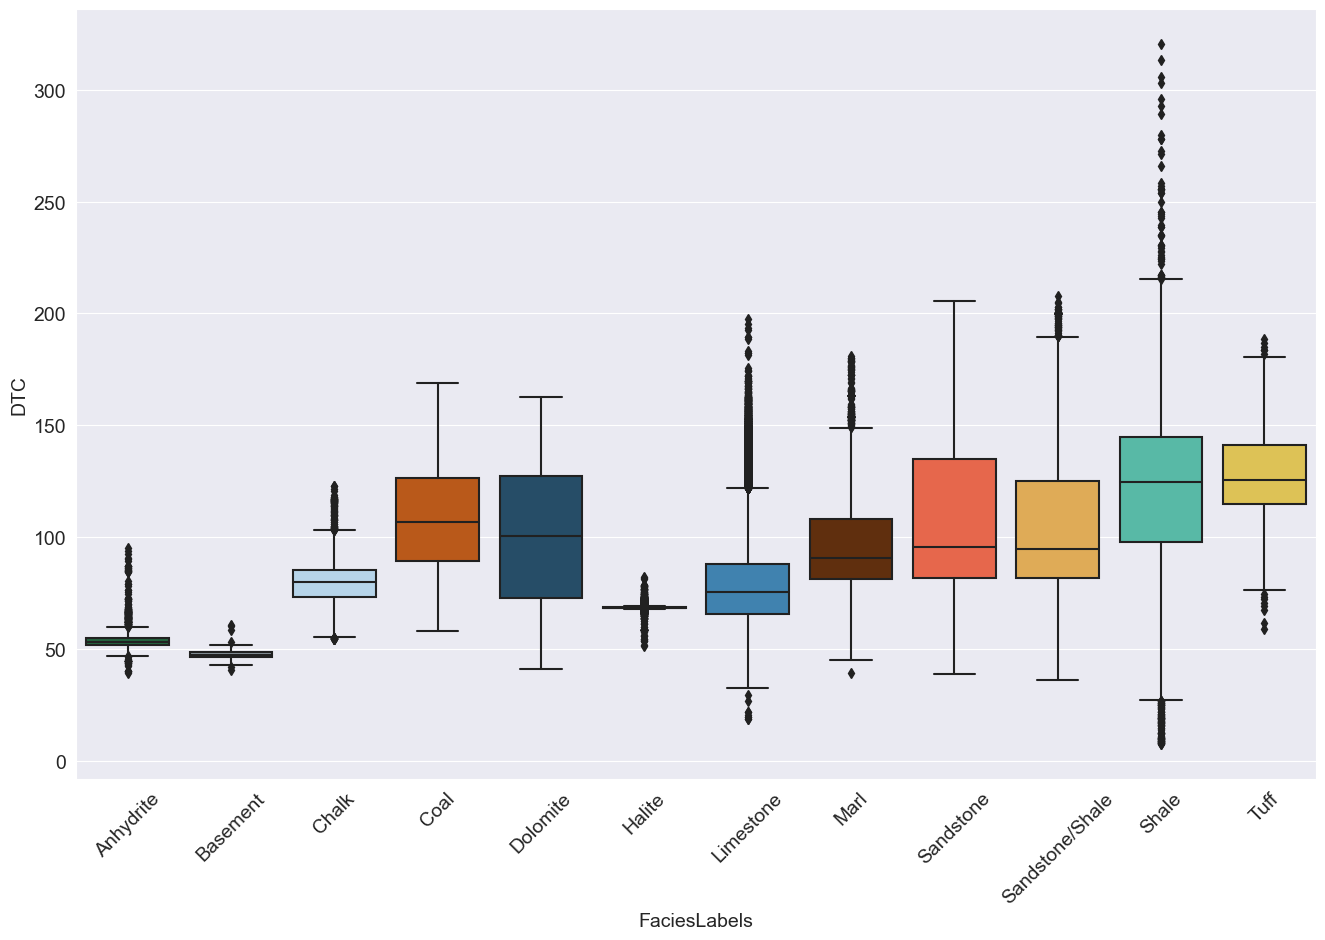

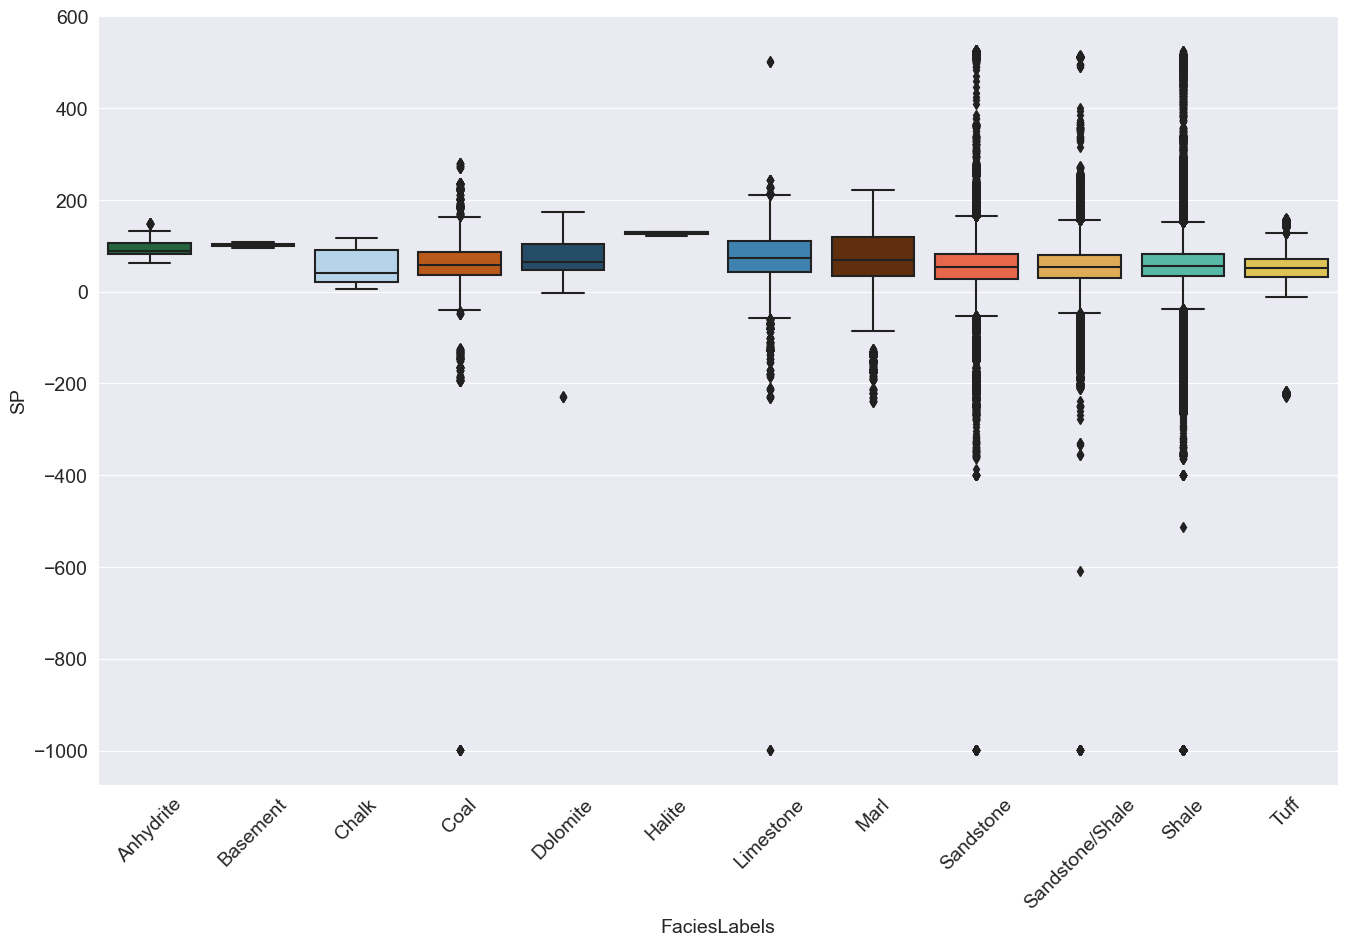

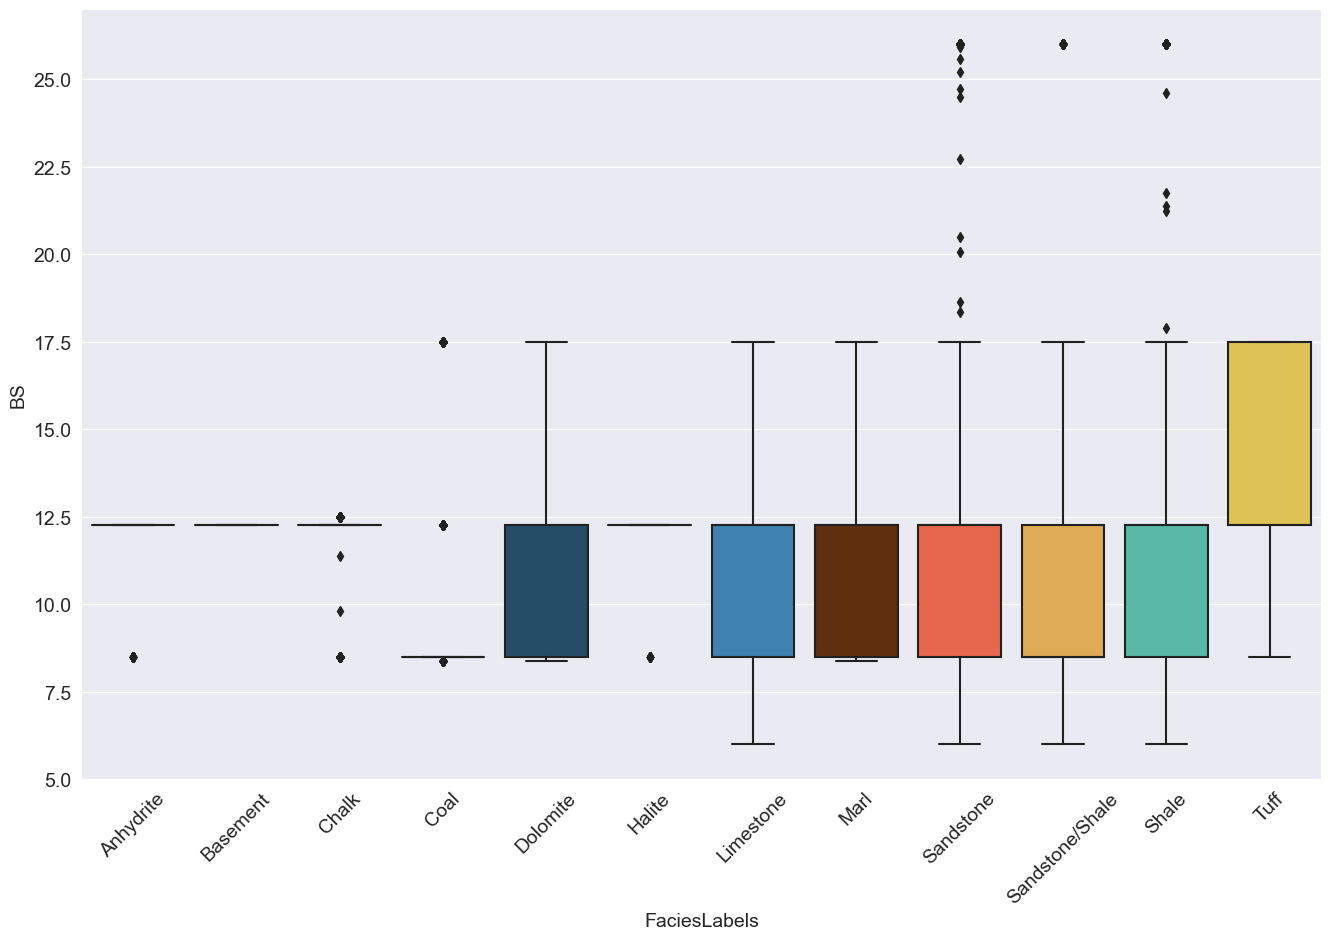

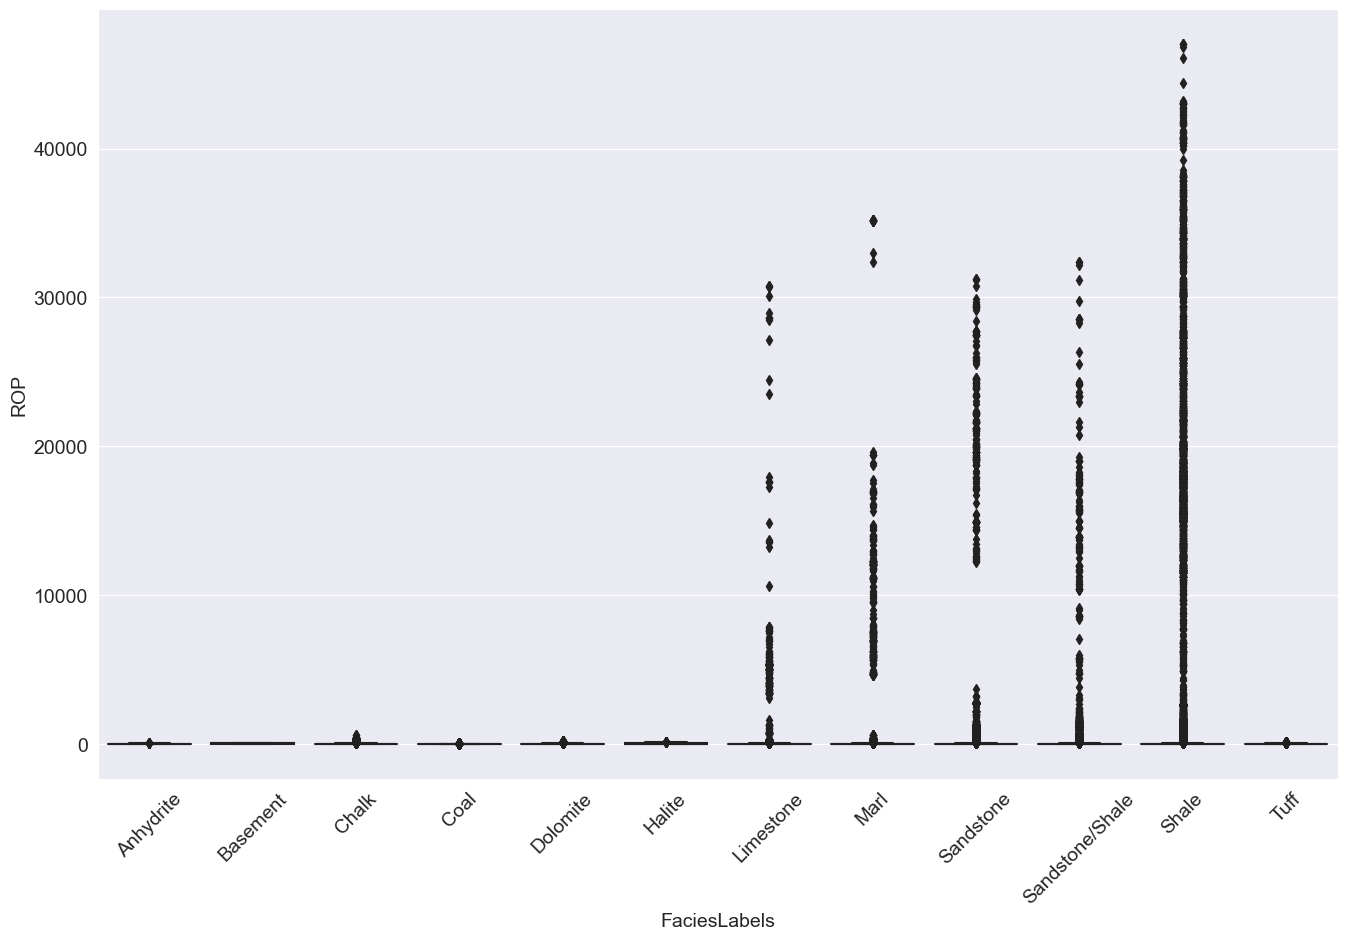

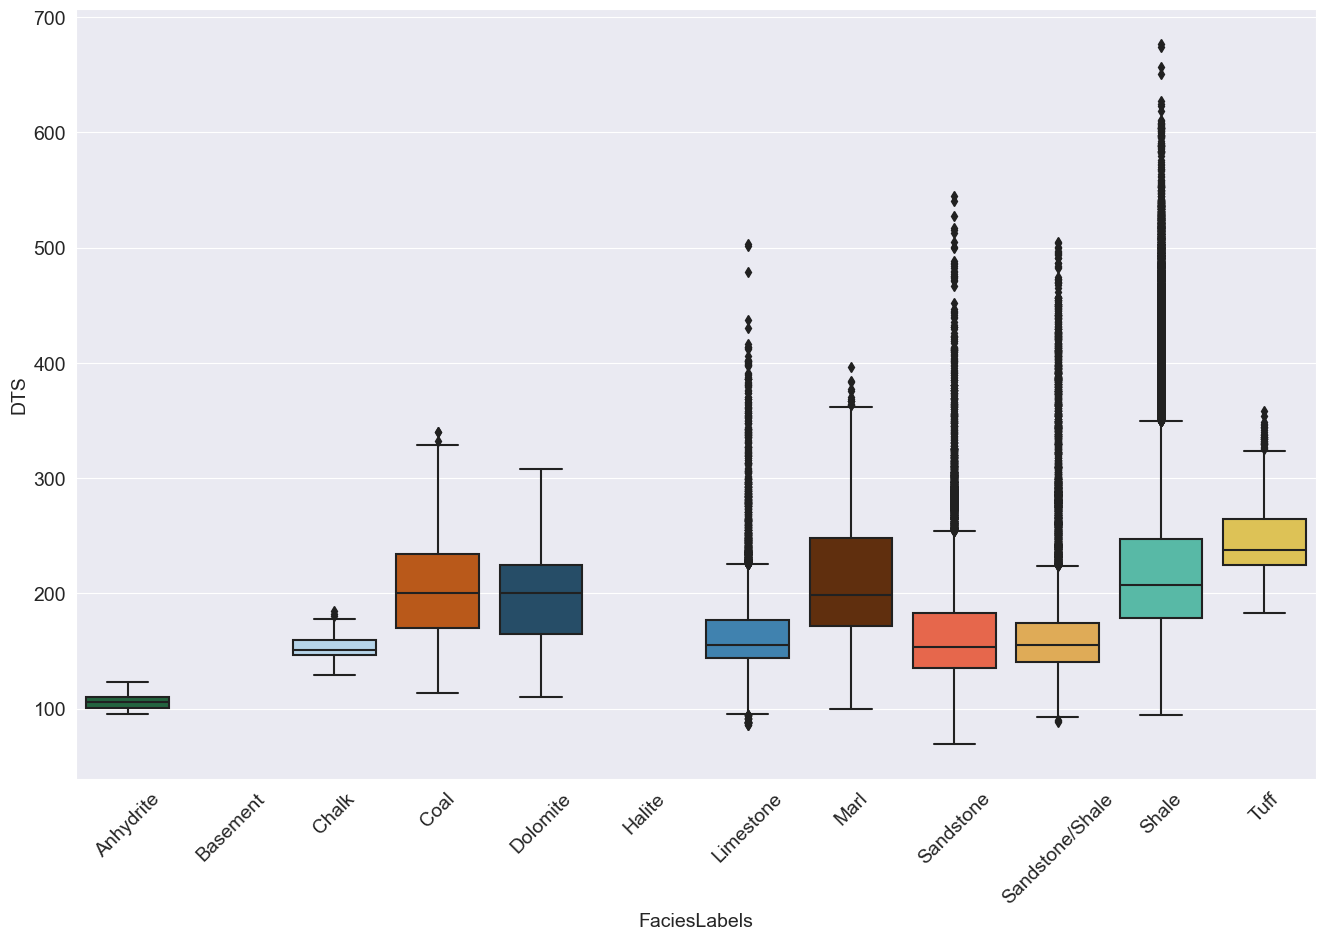

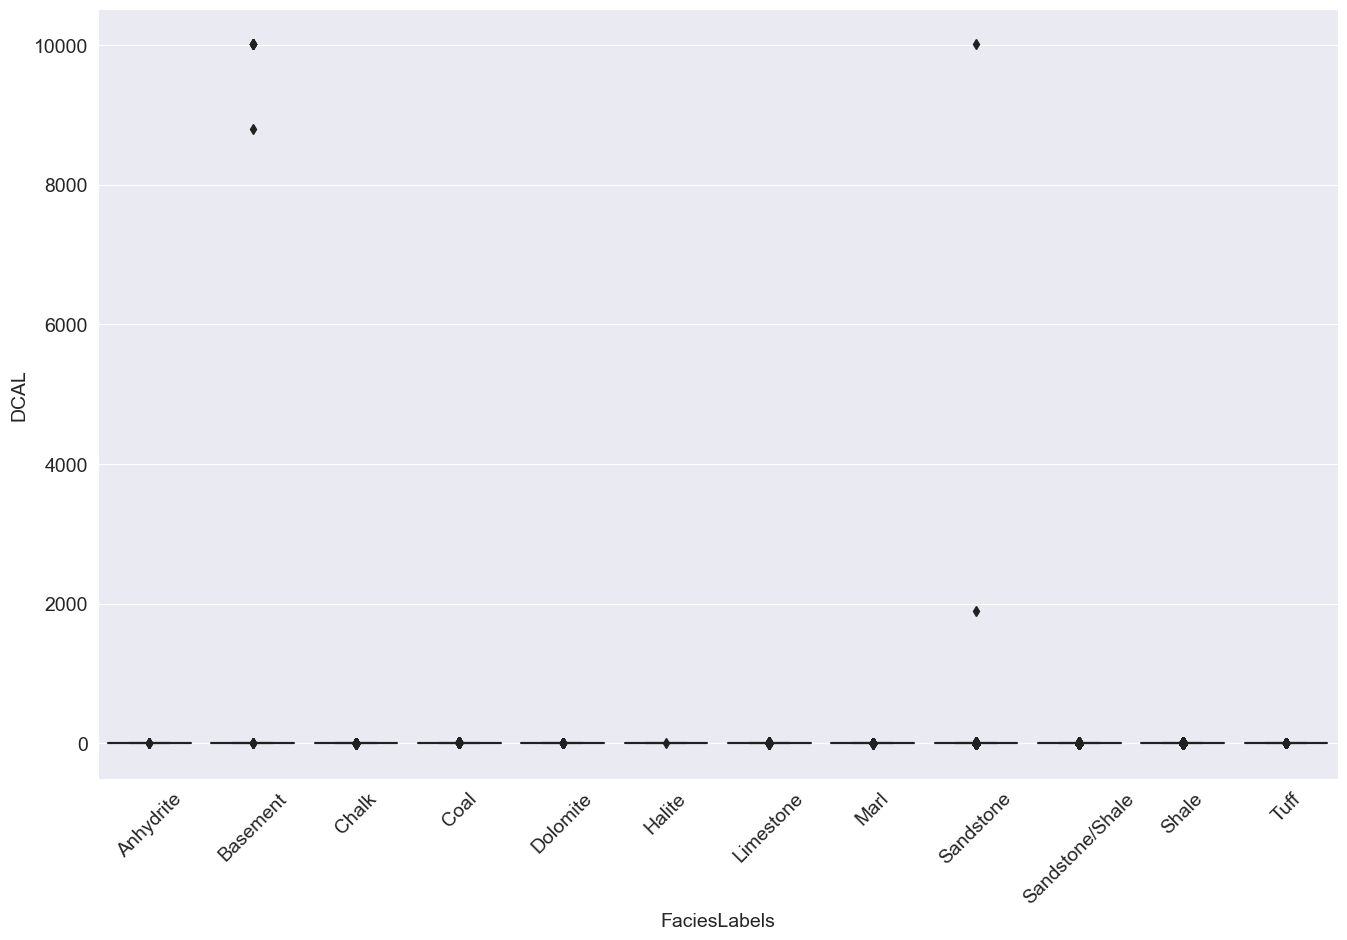

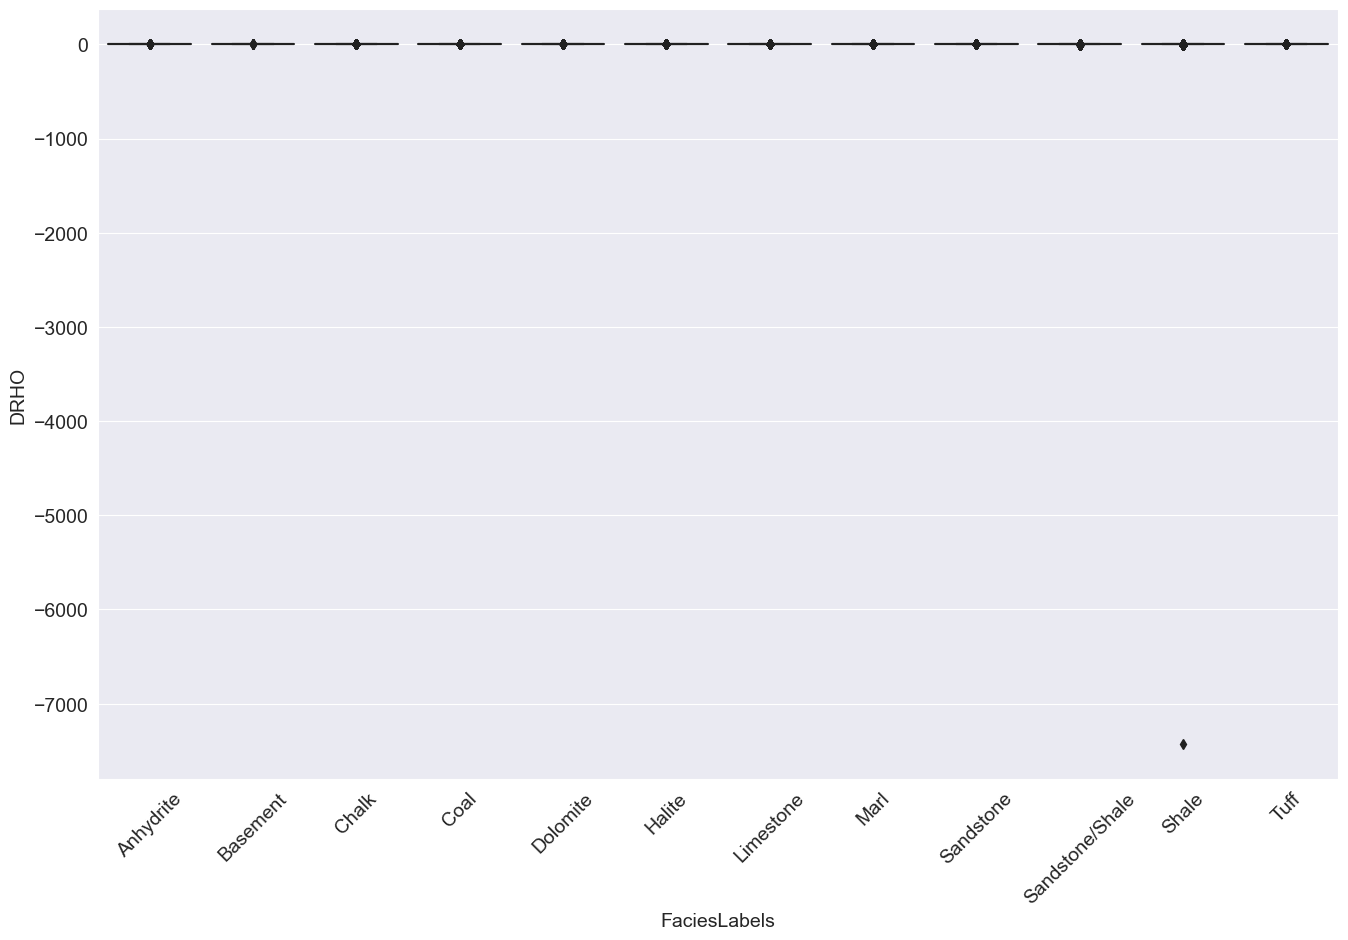

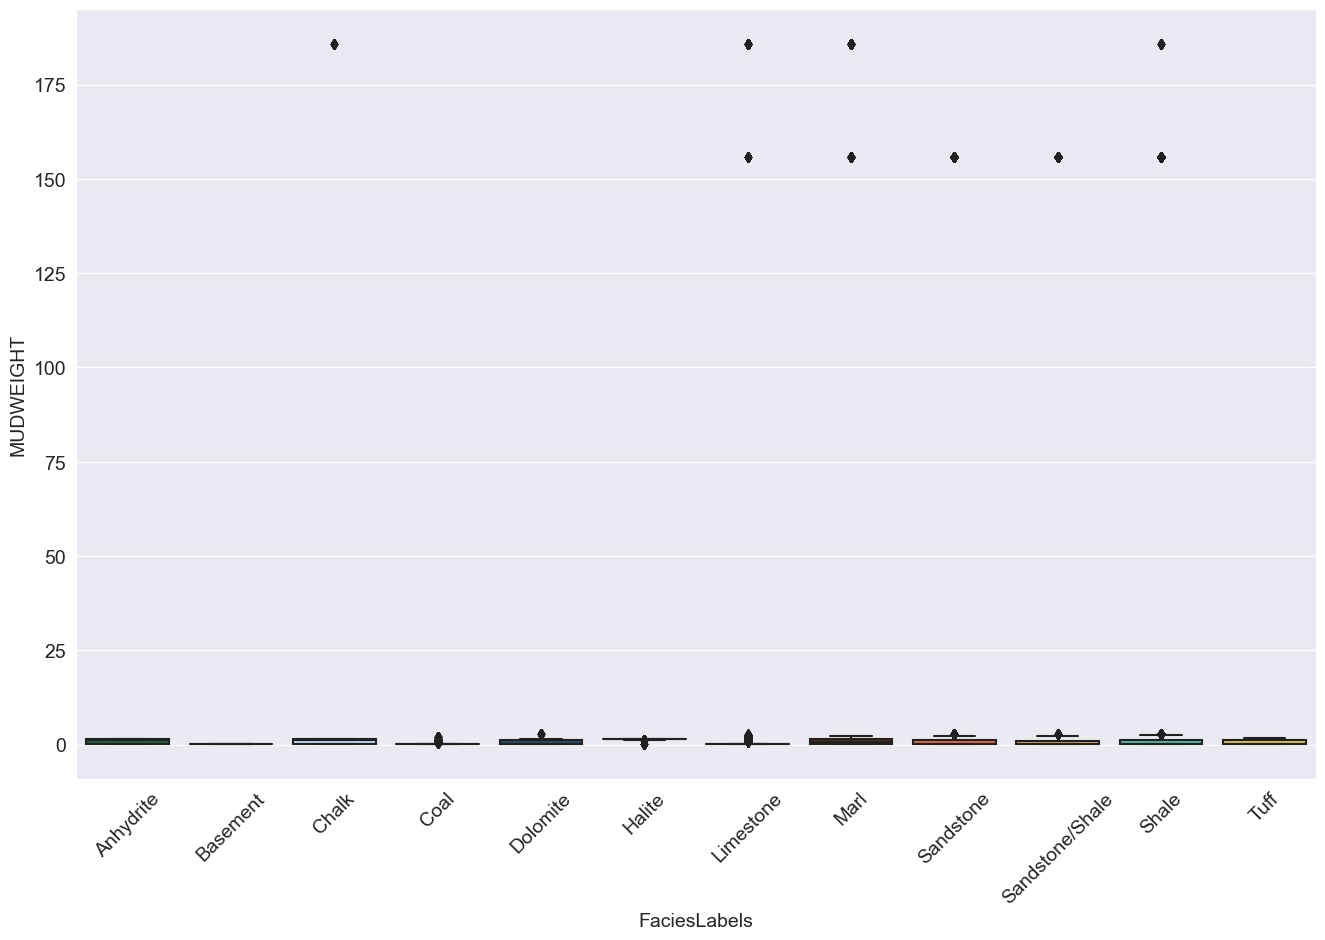

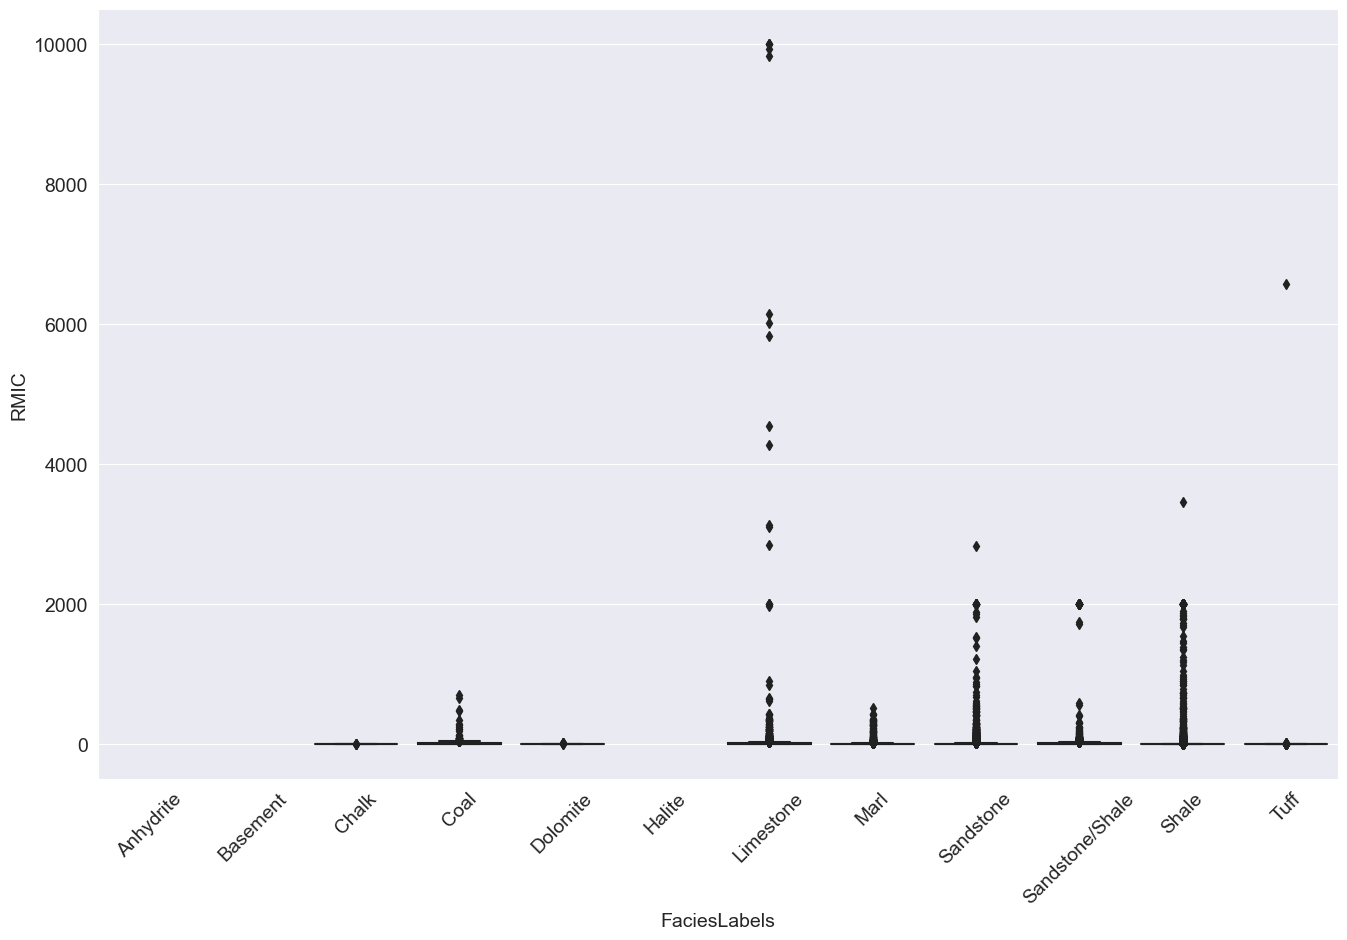

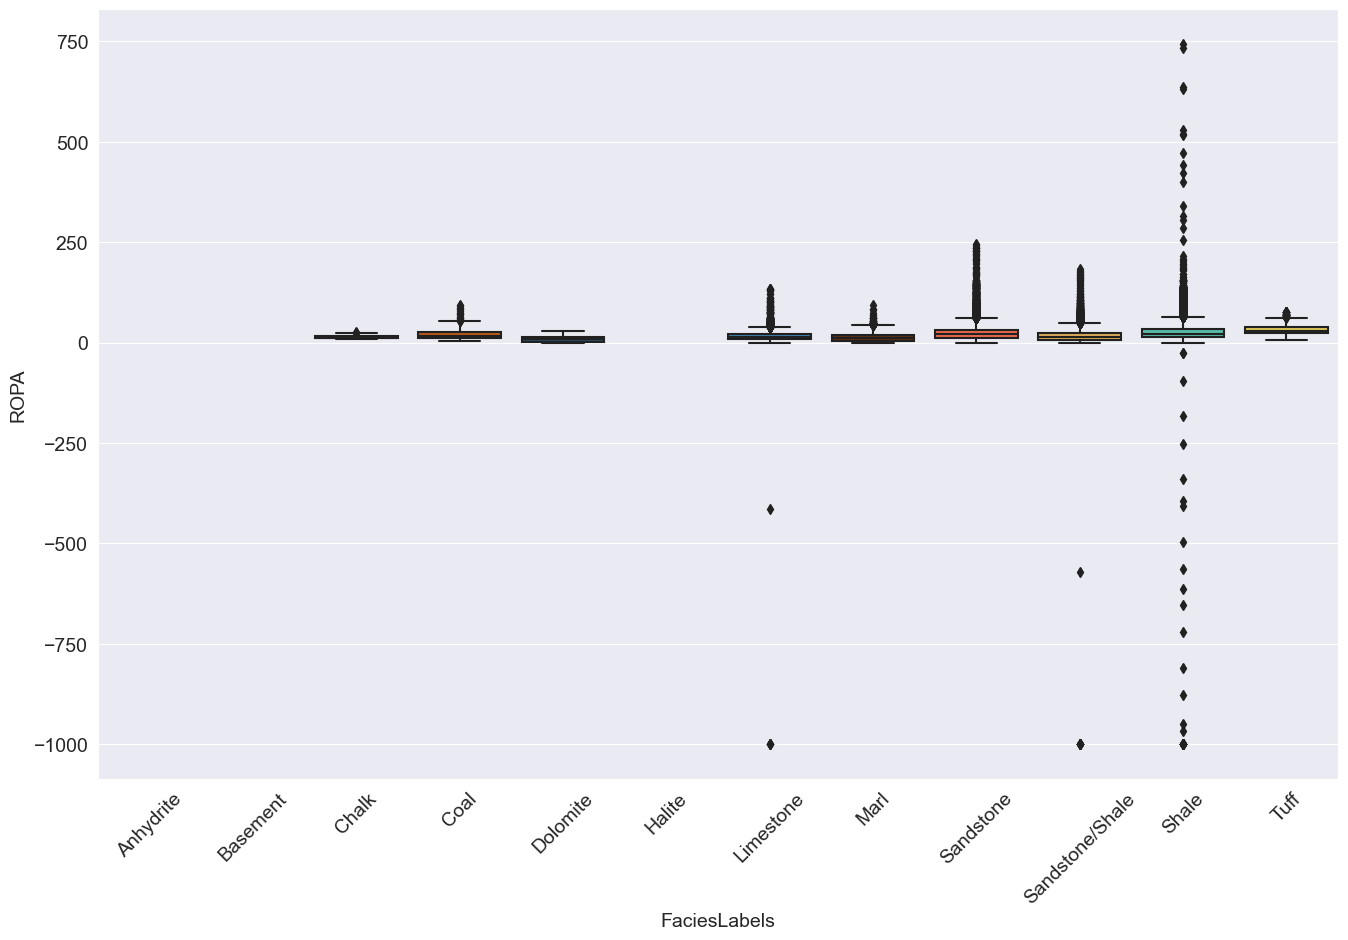

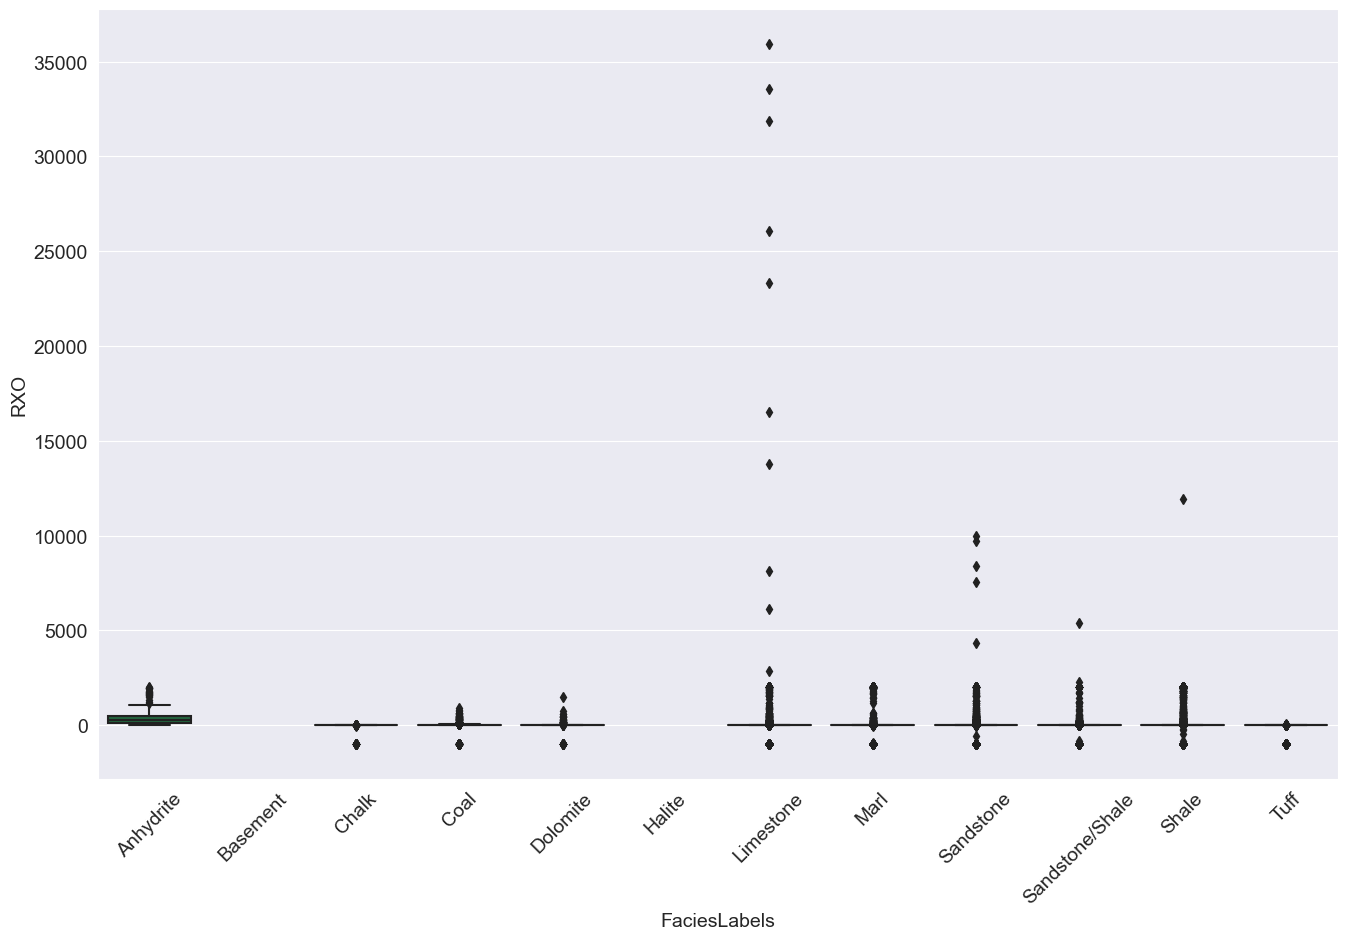

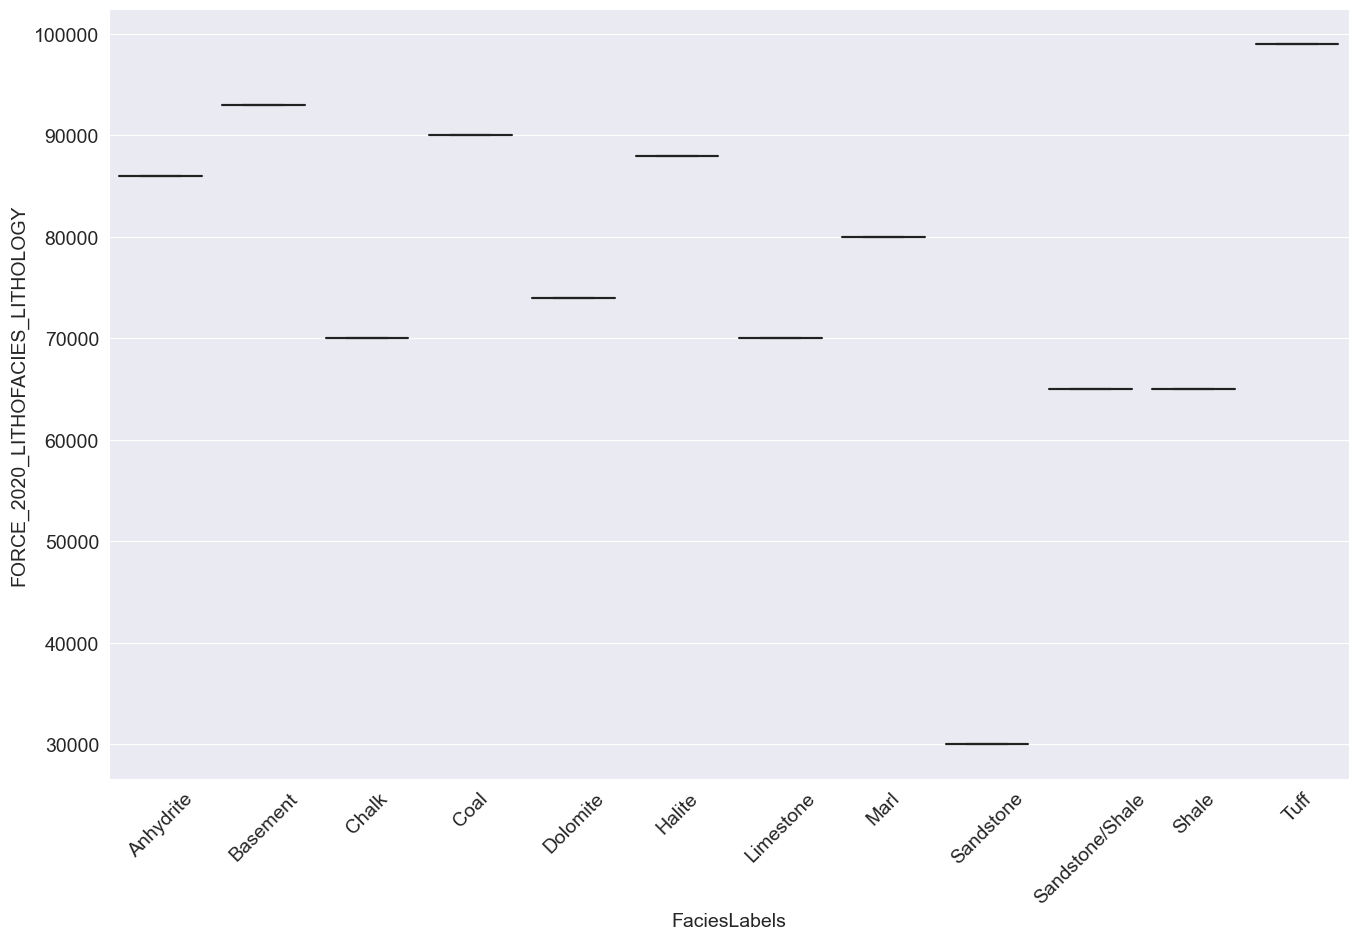

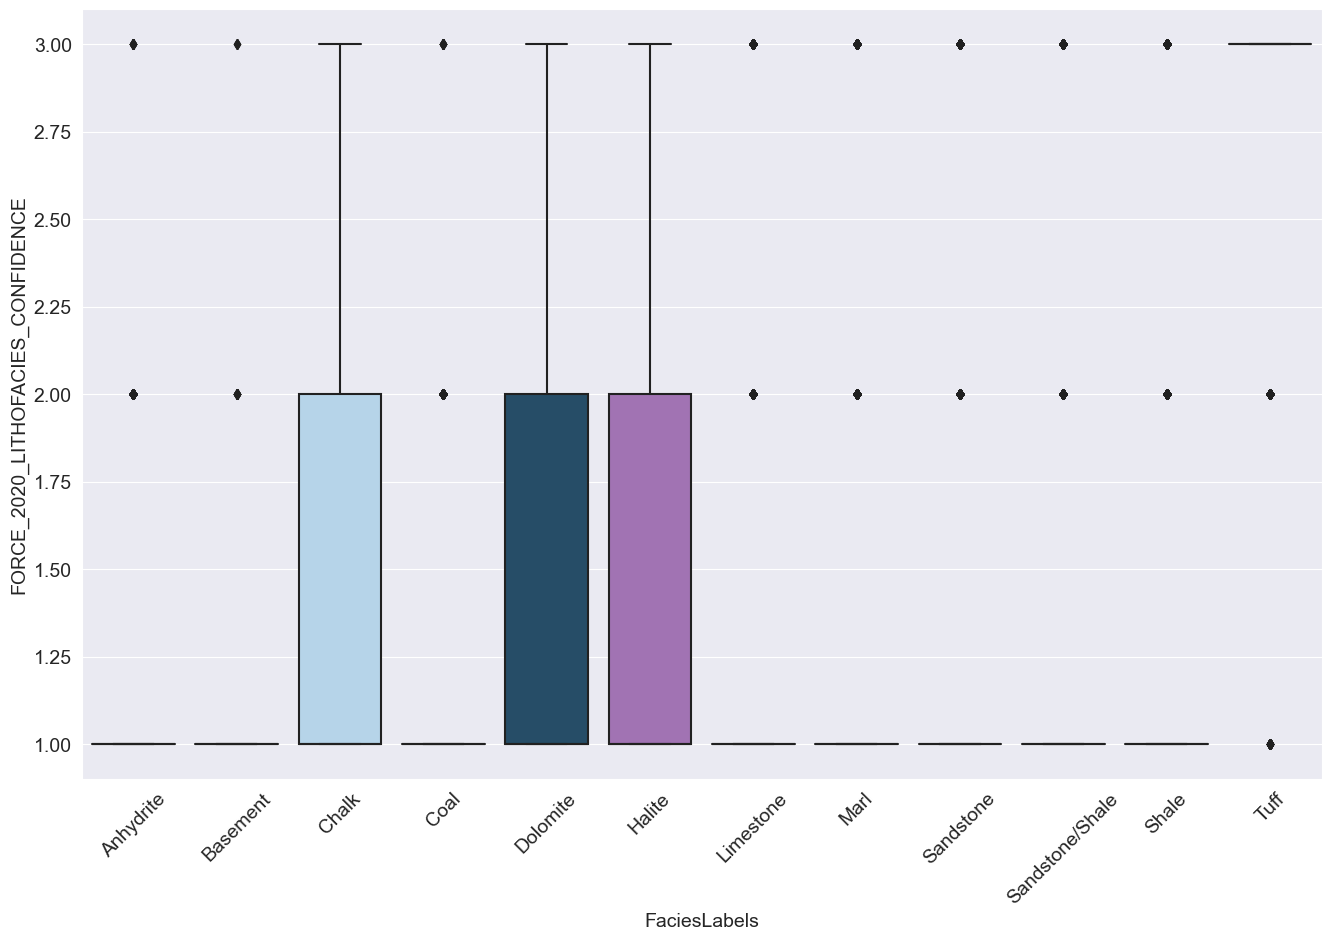

In [28]:
#Ящики с усами
for col in numeric_columns[1:]:
    if col != 'NM_M':
        fig = plt.figure()
        fig.set_size_inches(16, 10)
        sns.boxplot(y=col, x=df['FaciesLabels'].astype('category'), data=df, palette=facies_colors)
        plt.xticks(rotation=45)
        plt.show()

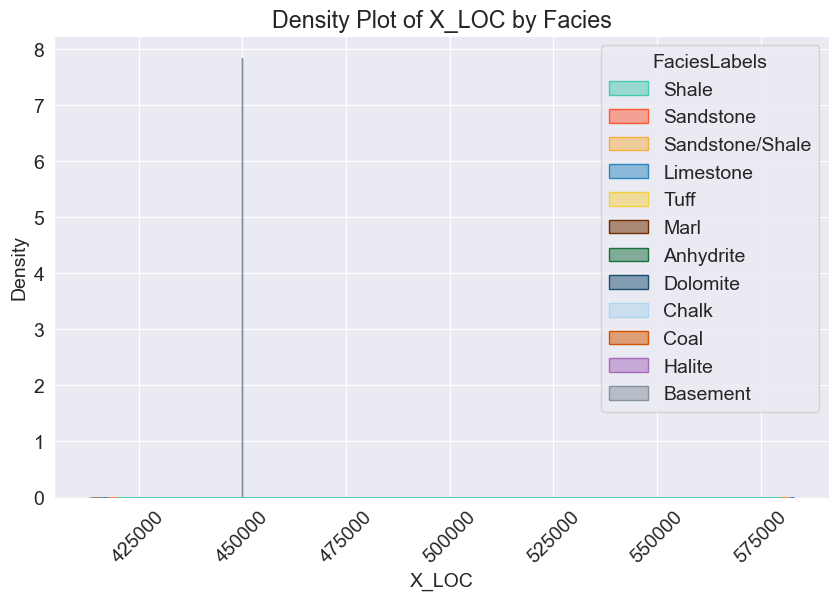

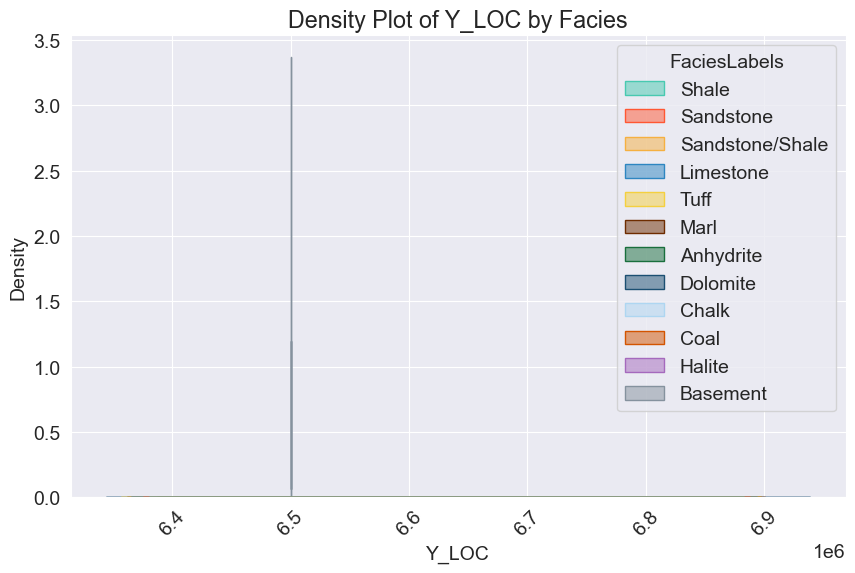

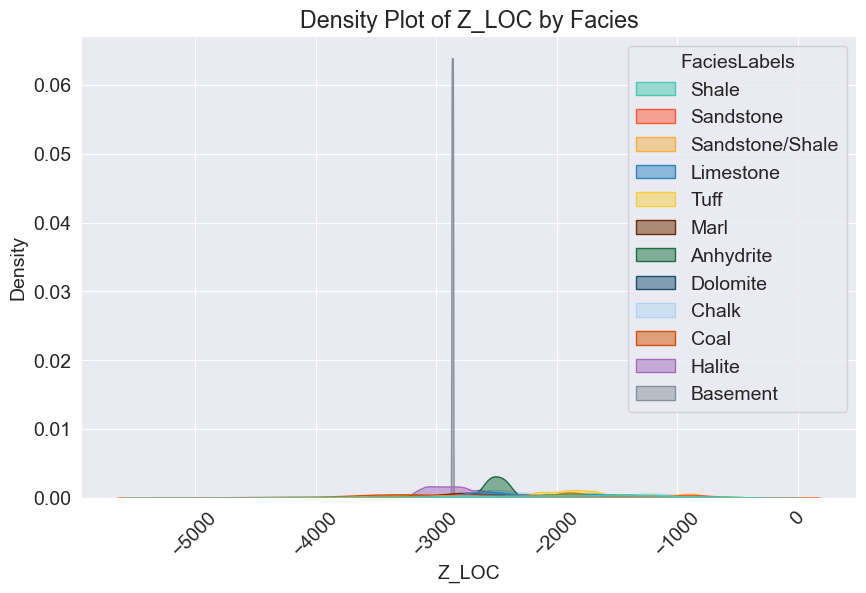

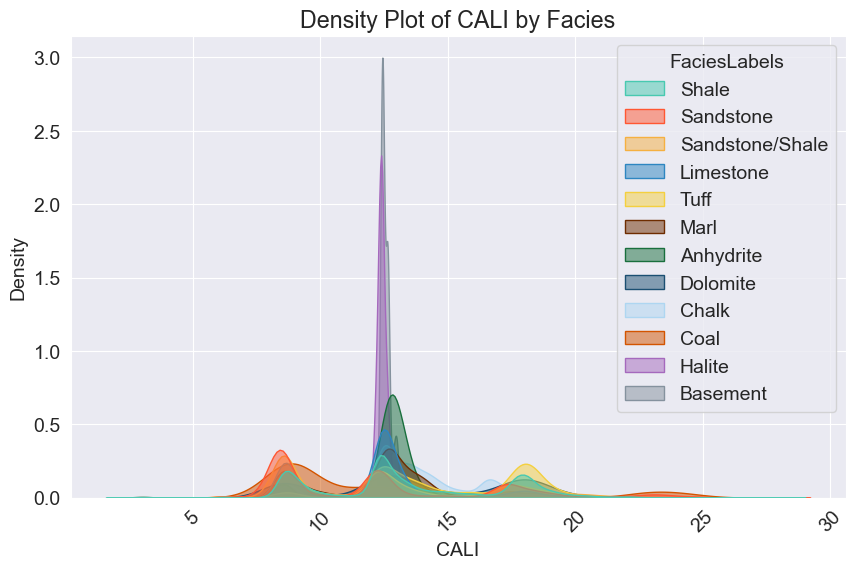

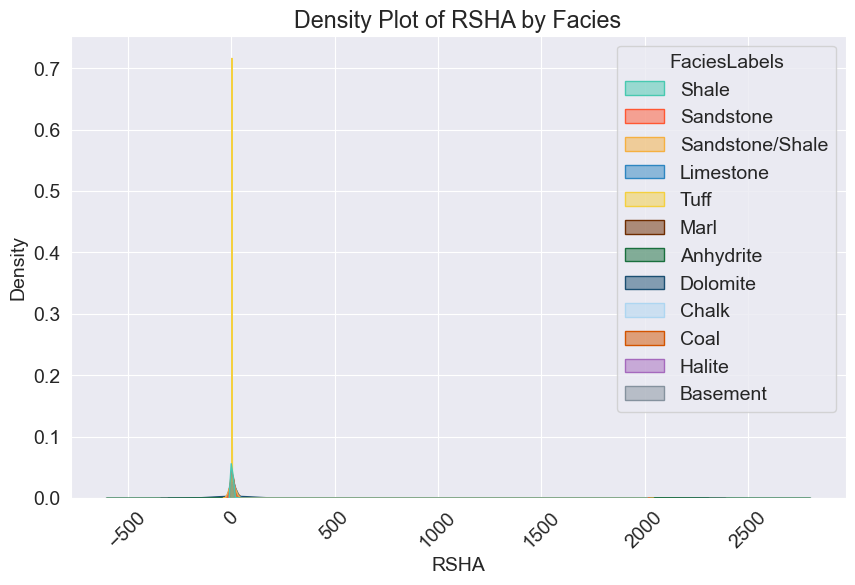

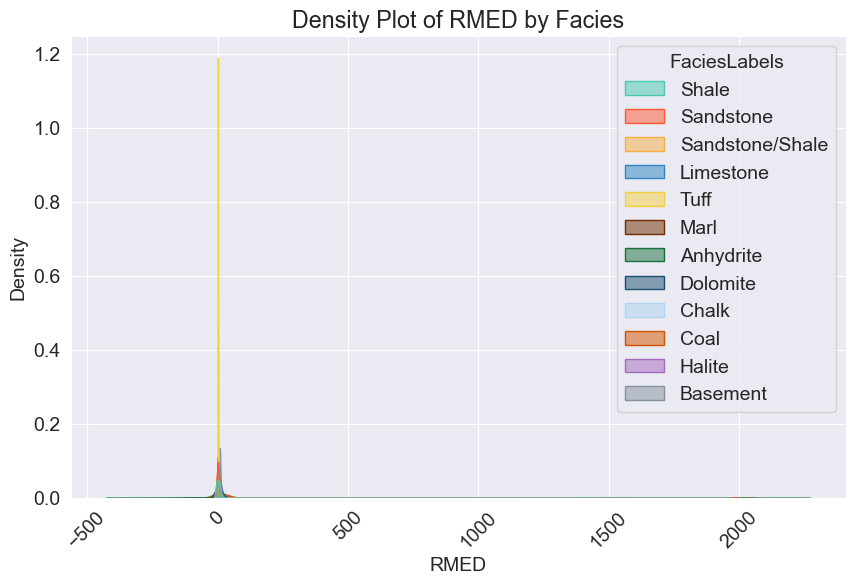

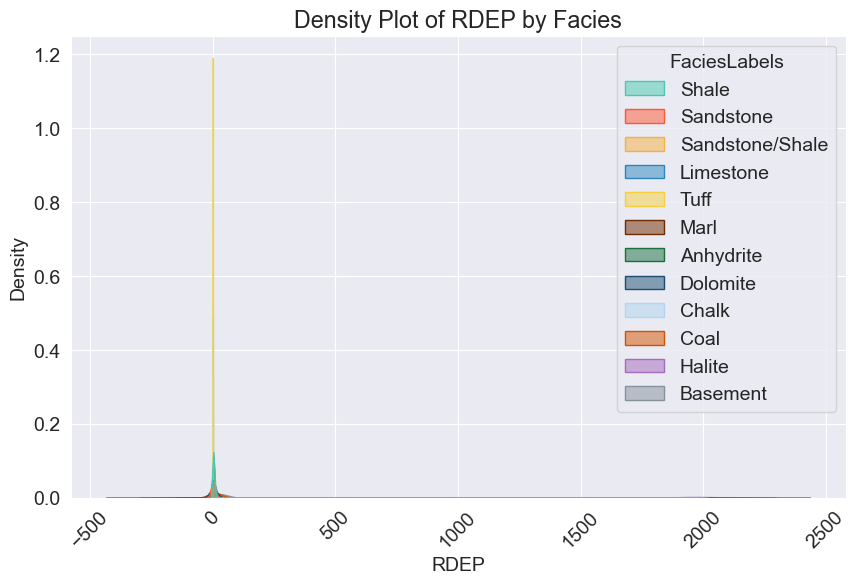

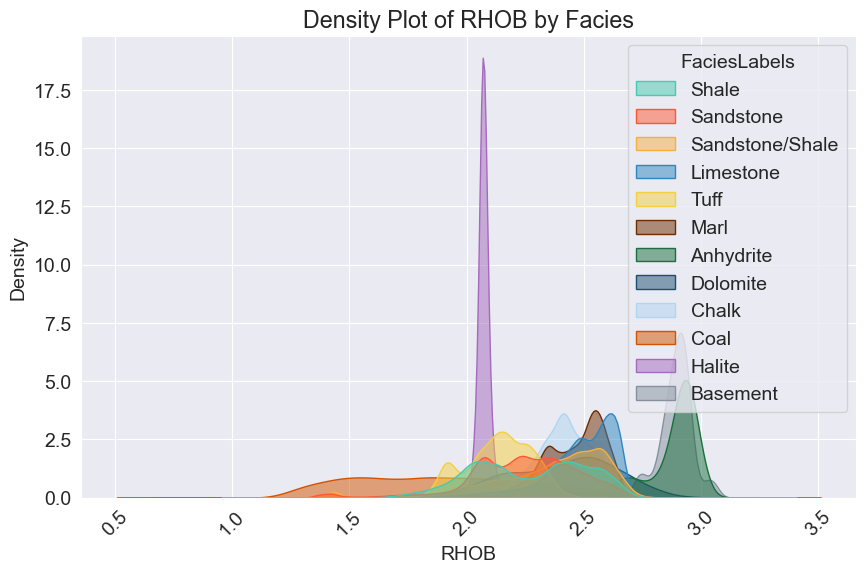

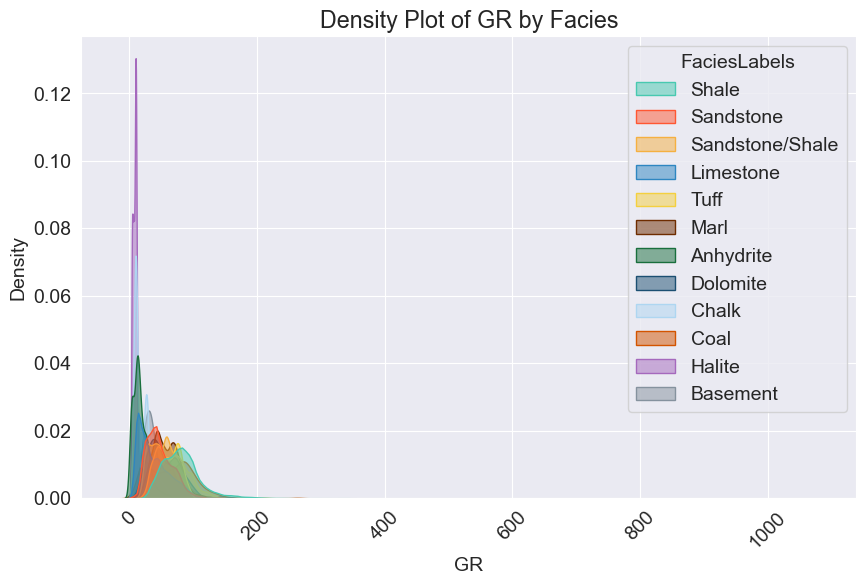

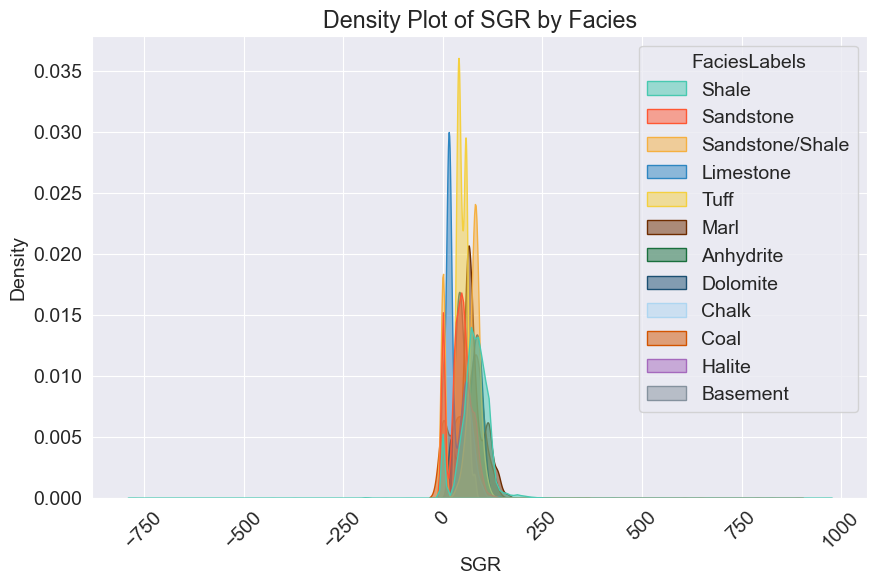

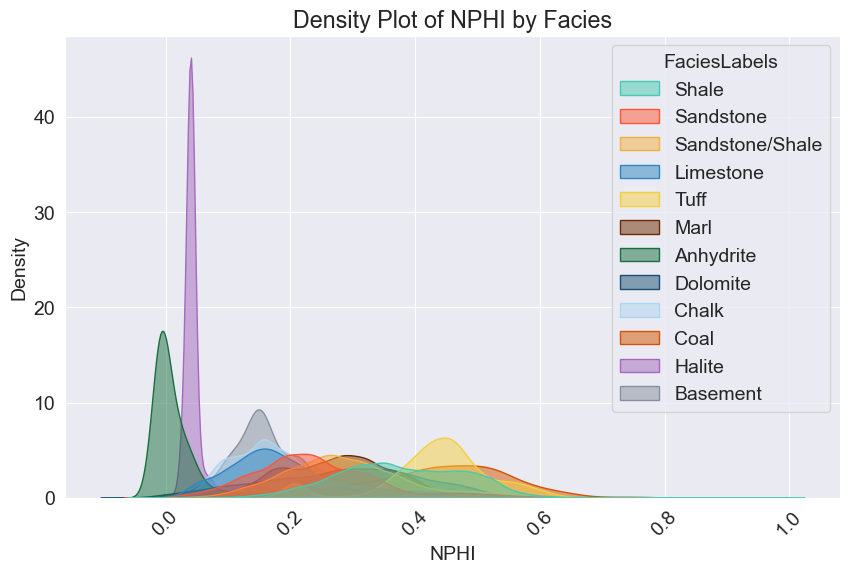

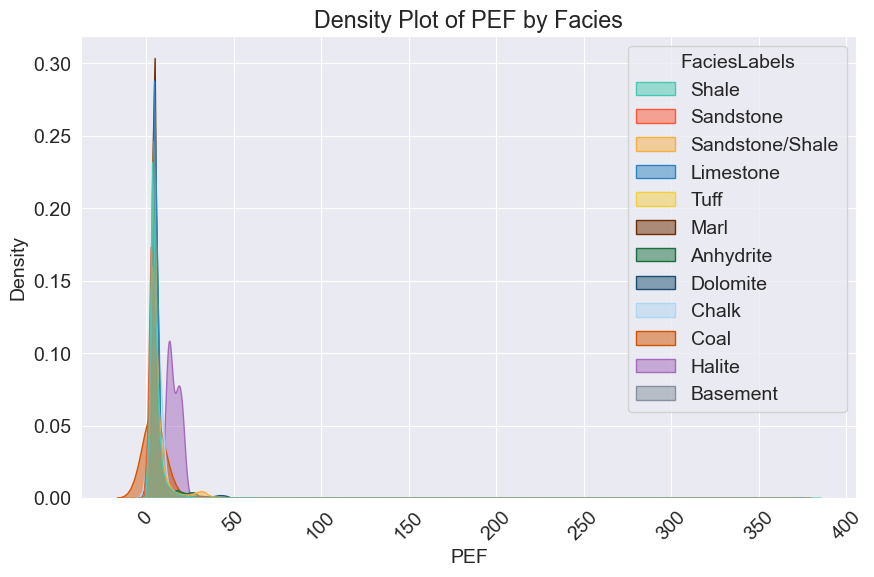

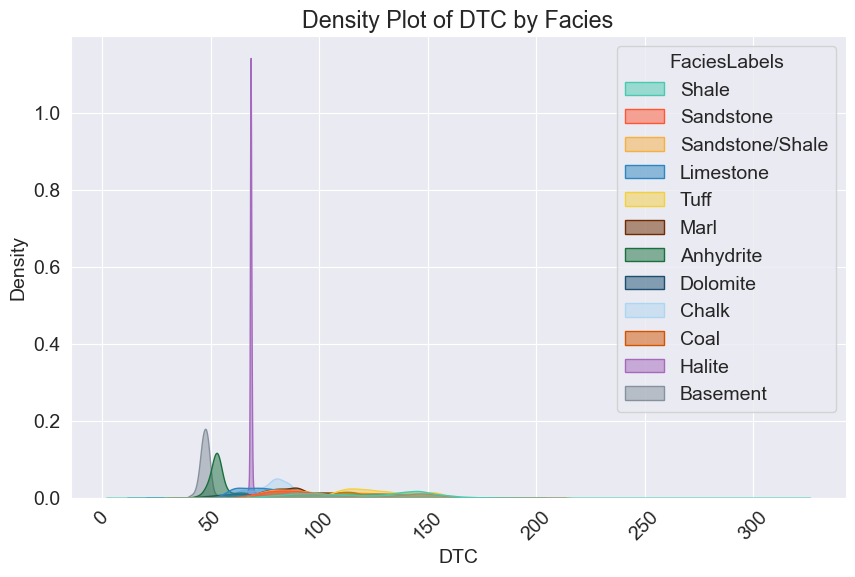

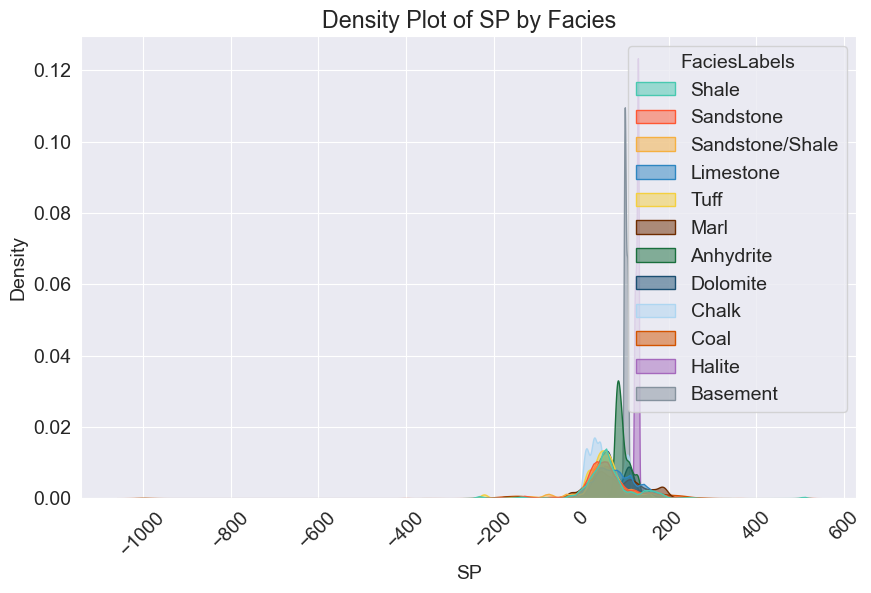

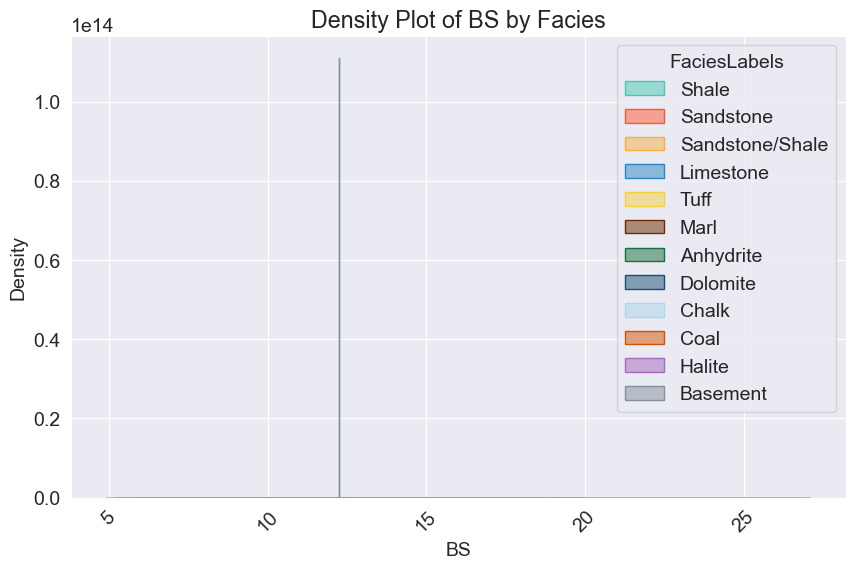

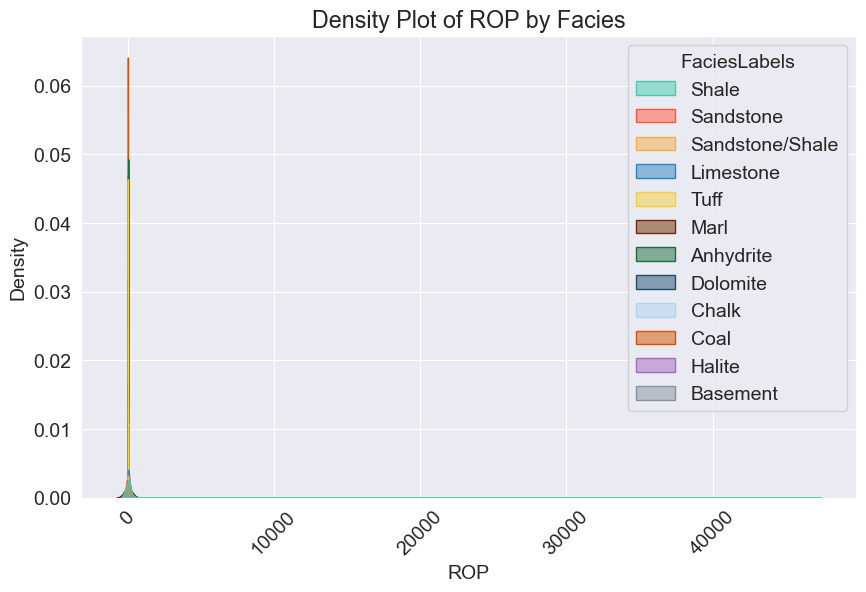

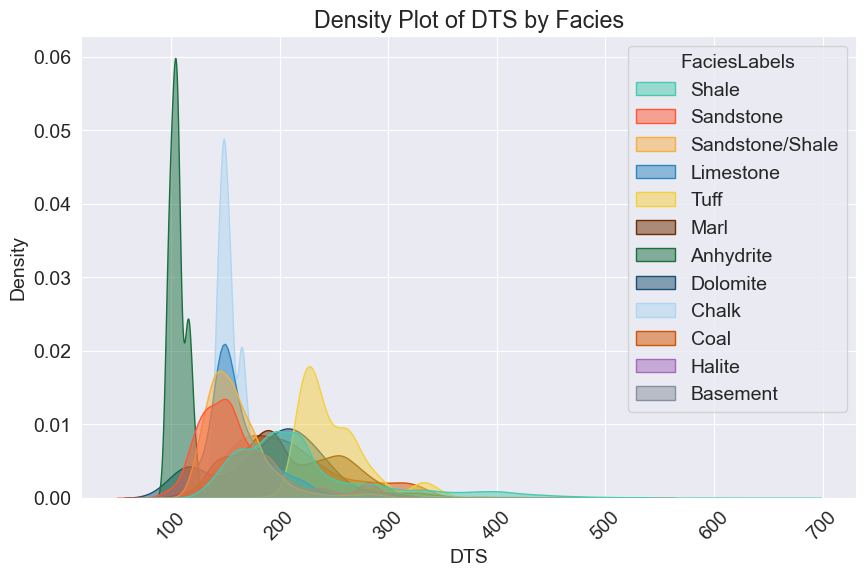

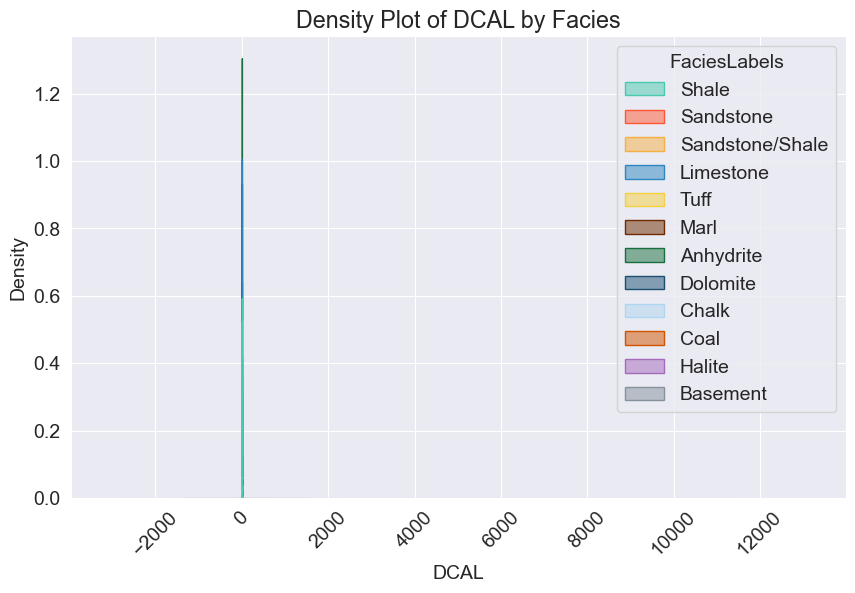

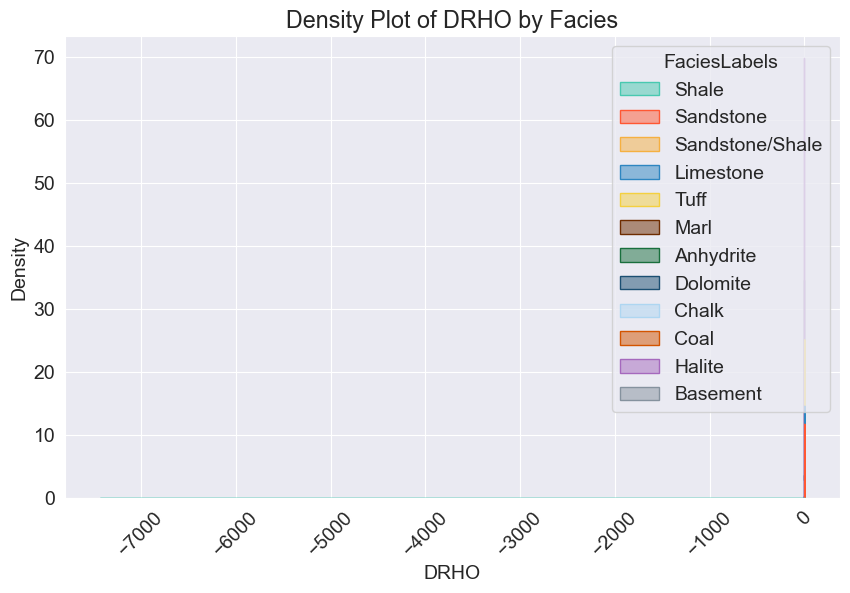

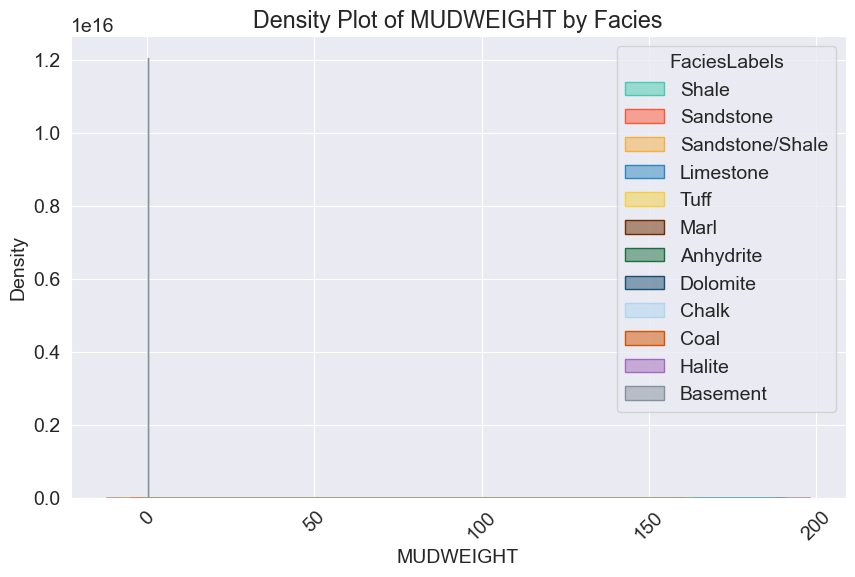

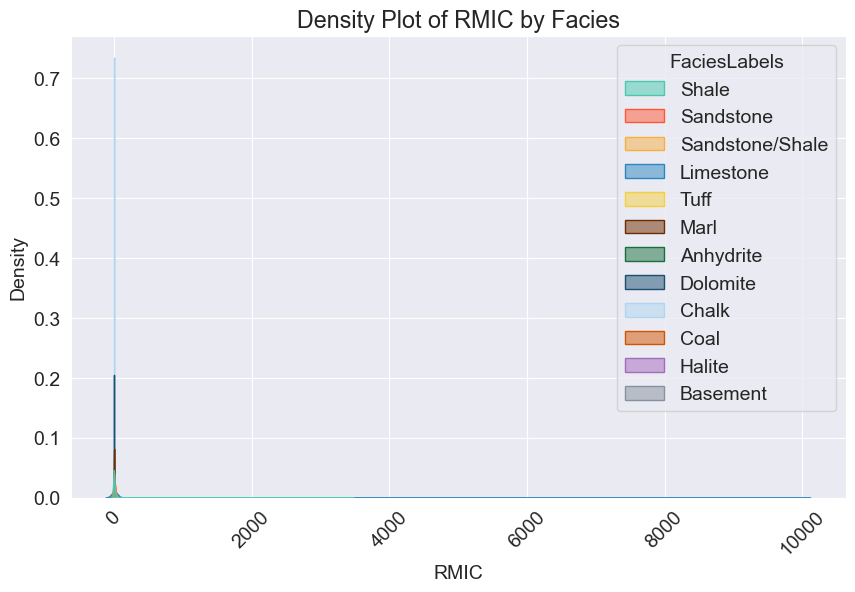

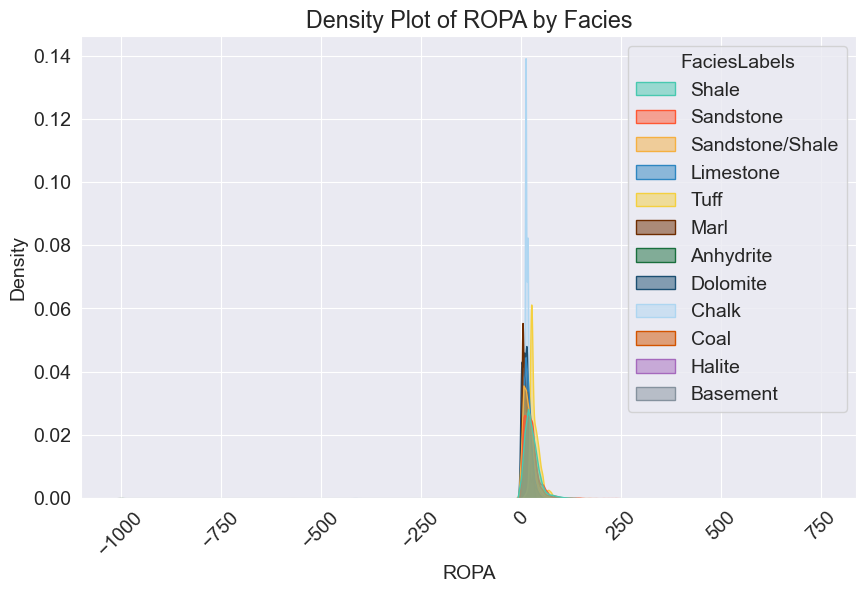

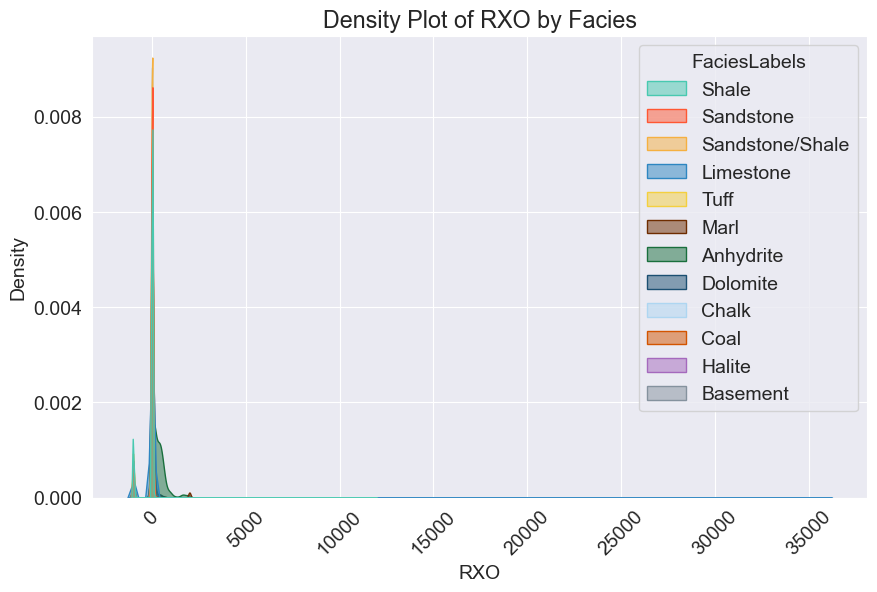

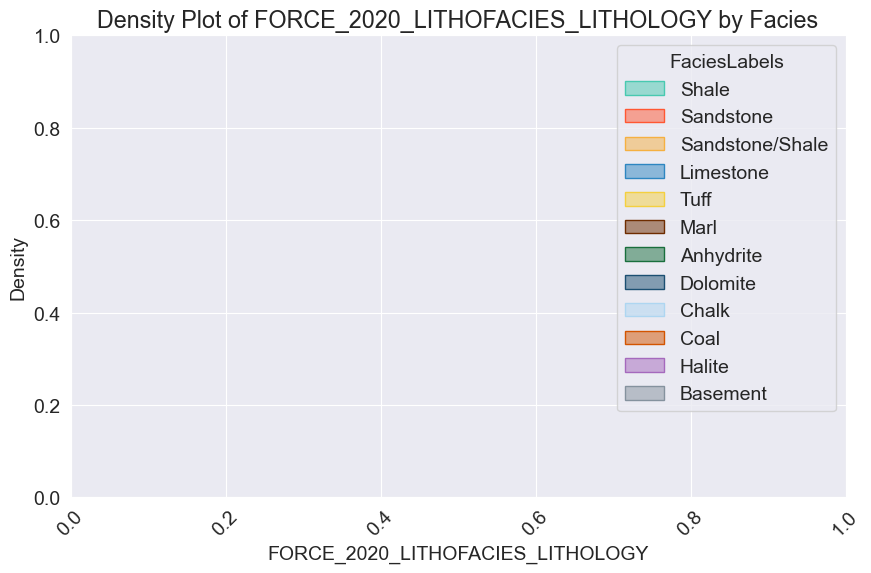

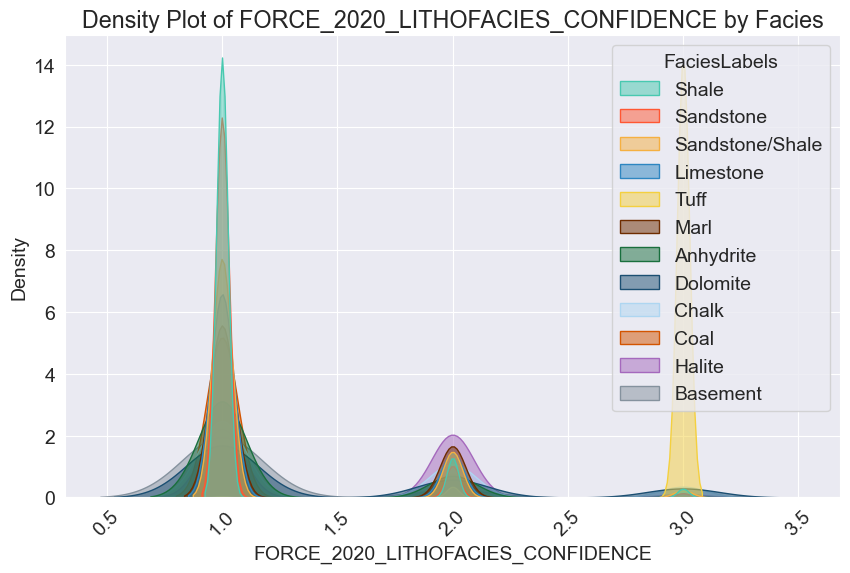

In [46]:
for col in numeric_columns[1:]:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x=col, hue='FaciesLabels', fill=True, common_norm=False, palette=facies_colors, alpha=0.5)
    plt.title(f'Density Plot of {col} by Facies')
    plt.xlabel(col)
    plt.ylabel('Density')
    #legend_labels = [facies_colors[color] for color in facies_colors.values()]
    # plt.legend(title='Facies', labels=legend_labels)
    #plt.legend(title='Facies')
    plt.xticks(rotation=45) 
    plt.show()

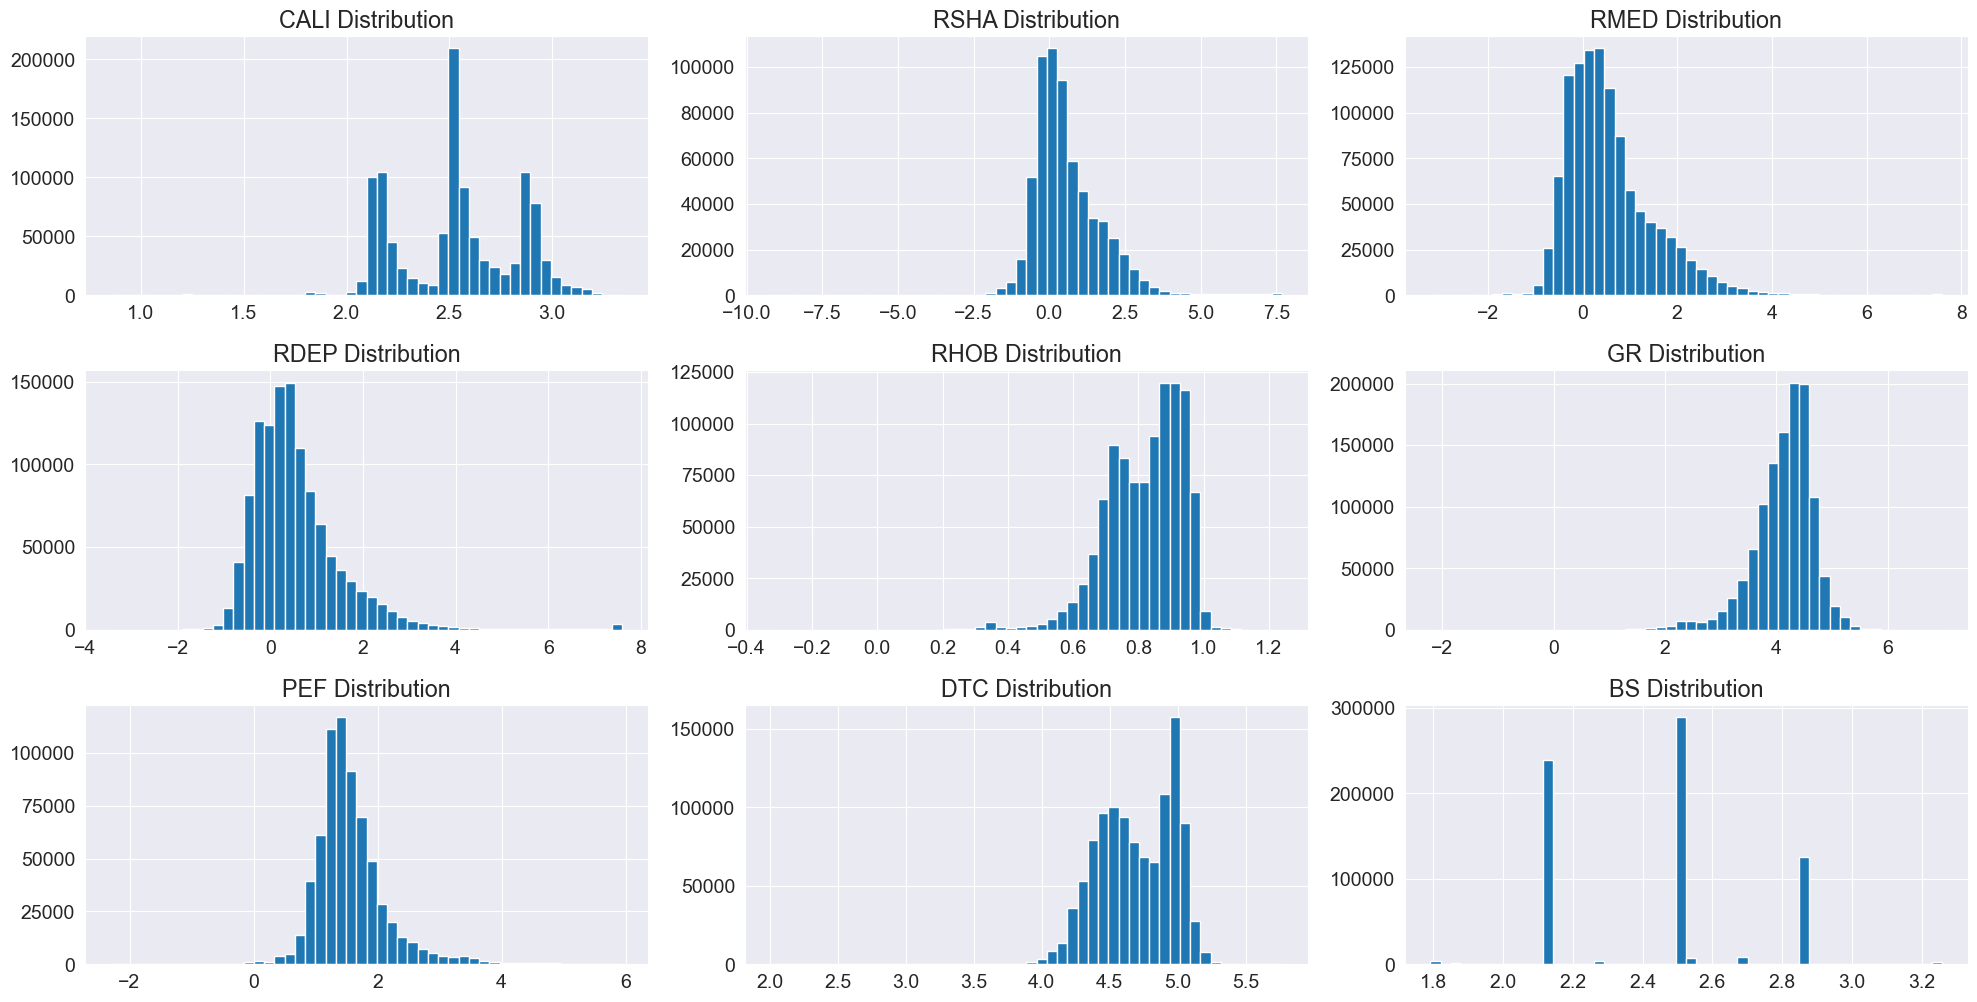

In [57]:
fig = plt.figure(figsize=(20, 20))
features = ['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'PEF', 'DTC', 'BS']

for i, feature in enumerate(features):
    ax = fig.add_subplot(6, 3, i + 1)
    try:
        np.log(df[feature]).hist(bins=50, ax=ax)
    except:
        pass
    ax.set_title(feature + " Distribution")

fig.tight_layout()  
plt.show()

Подсчет количества уникальных и пропущенных значений

In [29]:
dftype = pd.DataFrame(df.dtypes, columns=['Data_Type'])
dftype['Number_Unique'] = df.nunique()
dftype['Nan_bool'] = df.isna().any()
dftype['Number_of_Nan'] = df.isna().sum()
dftype

Data_Type  Number_Unique  Nan_bool  \
WELL                                 object             98     False   
DEPTH_MD                            float64        1146418     False   
X_LOC                               float64         166525      True   
Y_LOC                               float64          17481      True   
Z_LOC                               float64        1128126      True   
GROUP                                object             14      True   
FORMATION                            object             69      True   
CALI                                float64         874208      True   
RSHA                                float64         619225      True   
RMED                                float64        1104594      True   
RDEP                                float64        1131288      True   
RHOB                                float64         874676      True   
GR                                  float64        1133878     False   
SGR                                 float64          68776      True   
NPHI                                float64         736868      True   
PEF                                 float64         657490      True   
DTC                                 float64        1027931      True   
SP                                  float64         832034      True   
BS                                  float64            152      True   
ROP                                 float64         447585      True   
DTS                                 float64         172930      True   
DCAL                                float64         264010      True   
DRHO                                float64         930870      True   
MUDWEIGHT                           float64            276      True   
RMIC                                float64         175417      True   
ROPA                                float64         184033      True   
RXO                                 float64         289703      True   
FORCE_2020_LITHOFACIES_LITHOLOGY      int64             12     False   
FORCE_2020_LITHOFACIES_CONFIDENCE   float64              3      True   
FaciesLabels                         object             12     False   

                                   Number_of_Nan  
WELL                                           0  
DEPTH_MD                                       0  
X_LOC                                      10775  
Y_LOC                                      10775  
Z_LOC                                      10775  
GROUP                                       1278  
FORMATION                                 136994  
CALI                                       87877  
RSHA                                      539861  
RMED                                       38993  
RDEP                                       11015  
RHOB                                      161269  
GR                                             0  
SGR                                      1101158  
NPHI                                      405102  
PEF                                       498819  
DTC                                        80863  
SP                                        306264  
BS                                        487854  
ROP                                       635440  
DTS                                       995898  
DCAL                                      871678  
DRHO                                      182654  
MUDWEIGHT                                 854360  
RMIC                                      994351  
ROPA                                      978186  
RXO                                       843084  
FORCE_2020_LITHOFACIES_LITHOLOGY               0  
FORCE_2020_LITHOFACIES_CONFIDENCE            179  
FaciesLabels                                   0

Замена пропущенных значений в численных колонках средним значением

In [53]:
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

In [54]:
df[numeric_columns].isna().sum()

DEPTH_MD                             0
X_LOC                                0
Y_LOC                                0
Z_LOC                                0
CALI                                 0
RSHA                                 0
RMED                                 0
RDEP                                 0
RHOB                                 0
GR                                   0
SGR                                  0
NPHI                                 0
PEF                                  0
DTC                                  0
SP                                   0
BS                                   0
ROP                                  0
DTS                                  0
DCAL                                 0
DRHO                                 0
MUDWEIGHT                            0
RMIC                                 0
ROPA                                 0
RXO                                  0
FORCE_2020_LITHOFACIES_LITHOLOGY     0
FORCE_2020_LITHOFACIES_CO

### 2.4 Нормализация данных

Выбор признаков, которые будут использоваться для классификации

In [10]:
features = ['RSHA', 'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS']

In [56]:
df[features].head()

RSHA       CALI      RMED      RDEP      RHOB         GR      NPHI  \
0  10.694664  19.480835  1.611410  1.798681  1.884186  80.200851  0.331966   
1  10.694664  19.468800  1.618070  1.795641  1.889794  79.262886  0.331966   
2  10.694664  19.468800  1.626459  1.800733  1.896523  74.821999  0.331966   
3  10.694664  19.459282  1.621594  1.801517  1.891913  72.878922  0.331966   
4  10.694664  19.453100  1.602679  1.795299  1.880034  71.729141  0.331966   

         PEF         DTC         BS        ROP         DTS  
0  20.915468  161.131180  11.931432  34.636410  204.655019  
1  19.383013  160.603470  11.931432  34.636410  204.655019  
2  22.591518  160.173615  11.931432  34.779556  204.655019  
3  32.191910  160.149429  11.931432  39.965164  204.655019  
4  38.495632  160.128342  11.931432  57.483765  204.655019

In [57]:
scaler = MinMaxScaler().fit(df[features])

In [58]:
transformed_df = df

transformed_df[features] = scaler.transform(df[features])

In [59]:
transformed_df.describe()

DEPTH_MD         X_LOC         Y_LOC         Z_LOC          CALI  \
count  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   2.184087e+03  4.856310e+05  6.681276e+06 -2.138527e+03  4.180327e-01   
std    9.971821e+02  3.439699e+04  1.275612e+05  9.664633e+02  1.408723e-01   
min    1.360860e+02  4.268988e+05  6.406641e+06 -5.395563e+03  0.000000e+00   
25%    1.418597e+03  4.548019e+05  6.593126e+06 -2.804552e+03  2.906809e-01   
50%    2.076605e+03  4.777699e+05  6.732132e+06 -2.055283e+03  4.001156e-01   
75%    2.864393e+03  5.201314e+05  6.784877e+06 -1.397964e+03  5.168812e-01   
max    5.436632e+03  5.726328e+05  6.856661e+06 -1.110860e+02  1.000000e+00   

               RSHA          RMED          RDEP          RHOB            GR  \
count  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   4.874672e-03  2.511986e-03  5.330048e-03  5.714658e-01  6.575114e-02   
std    3.367212e-02  2.703090e-02  5.670939e-02  8.593419e-02  3.178840e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.907715e-04  4.713978e-04  4.416133e-04  5.123182e-01  4.412660e-02   
50%    4.736759e-03  7.534114e-04  7.090959e-04  5.714658e-01  6.338678e-02   
75%    4.874672e-03  1.525811e-03  1.292097e-03  6.365009e-01  8.257961e-02   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       ...           ROP           DTS          DCAL          DRHO  \
count  ...  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   ...  2.924284e-03  2.230631e-01  1.223849e+00  1.219638e-02   
std    ...  2.213736e-02  4.518985e-02  2.747313e+01  6.869624e+00   
min    ...  0.000000e+00  0.000000e+00 -1.221546e+01 -7.429339e+03   
25%    ...  4.408839e-04  2.230631e-01  1.223849e+00 -6.882701e-03   
50%    ...  2.924284e-03  2.230631e-01  1.223849e+00  6.651836e-03   
75%    ...  2.924284e-03  2.230631e-01  1.223849e+00  1.555134e-02   
max    ...  1.000000e+00  1.000000e+00  1.001142e+04  2.836938e+00   

          MUDWEIGHT          RMIC          ROPA           RXO  \
count  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   1.216329e+00  7.796809e+00  2.350507e+01 -9.577950e+01   
std    5.291056e+00  3.481446e+01  9.174184e+00  1.845736e+02   
min    1.258177e-01  5.658556e-02 -9.992501e+02 -9.999000e+02   
25%    1.216329e+00  7.796809e+00  2.350507e+01 -9.577950e+01   
50%    1.216329e+00  7.796809e+00  2.350507e+01 -9.577950e+01   
75%    1.216329e+00  7.796809e+00  2.350507e+01  1.201068e-01   
max    1.857309e+02  1.000000e+04  7.427979e+02  3.593067e+04   

       FORCE_2020_LITHOFACIES_LITHOLOGY  FORCE_2020_LITHOFACIES_CONFIDENCE  
count                      1.170511e+06                       1.170511e+06  
mean                       6.138598e+04                       1.164258e+00  
std                        1.389170e+04                       4.450840e-01  
min                        3.000000e+04                       1.000000e+00  
25%                        6.500000e+04                       1.000000e+00  
50%                        6.500000e+04                       1.000000e+00  
75%                        6.500000e+04                       1.000000e+00  
max                        9.900000e+04                       3.000000e+00  

[8 rows x 26 columns]

In [60]:
transformed_df

WELL   DEPTH_MD         X_LOC         Y_LOC        Z_LOC  \
0        15/9-13   494.5280  437641.96875  6.470972e+06  -469.501831   
1        15/9-13   494.6800  437641.96875  6.470972e+06  -469.653809   
2        15/9-13   494.8320  437641.96875  6.470972e+06  -469.805786   
3        15/9-13   494.9840  437641.96875  6.470972e+06  -469.957794   
4        15/9-13   495.1360  437641.96875  6.470972e+06  -470.109772   
...          ...        ...           ...           ...          ...   
1170506  7/1-2 S  3169.3124  485631.03274  6.681276e+06 -2138.527143   
1170507  7/1-2 S  3169.4644  485631.03274  6.681276e+06 -2138.527143   
1170508  7/1-2 S  3169.6164  485631.03274  6.681276e+06 -2138.527143   
1170509  7/1-2 S  3169.7684  485631.03274  6.681276e+06 -2138.527143   
1170510  7/1-2 S  3169.9204  485631.03274  6.681276e+06 -2138.527143   

                GROUP  FORMATION      CALI      RSHA      RMED  ...       DTS  \
0        NORDLAND GP.        NaN  0.660761  0.004875  0.000815  ...  0.223063   
1        NORDLAND GP.        NaN  0.660297  0.004875  0.000818  ...  0.223063   
2        NORDLAND GP.        NaN  0.660297  0.004875  0.000822  ...  0.223063   
3        NORDLAND GP.        NaN  0.659930  0.004875  0.000820  ...  0.223063   
4        NORDLAND GP.        NaN  0.659692  0.004875  0.000810  ...  0.223063   
...               ...        ...       ...       ...       ...  ...       ...   
1170506  VESTLAND GP.  Bryne Fm.  0.234400  0.004875  0.002512  ...  0.223063   
1170507  VESTLAND GP.  Bryne Fm.  0.232707  0.004875  0.002512  ...  0.223063   
1170508  VESTLAND GP.  Bryne Fm.  0.231589  0.004875  0.002512  ...  0.223063   
1170509  VESTLAND GP.  Bryne Fm.  0.230182  0.004875  0.002512  ...  0.223063   
1170510  VESTLAND GP.  Bryne Fm.  0.229455  0.004875  0.002512  ...  0.223063   

             DCAL      DRHO  MUDWEIGHT      RMIC       ROPA        RXO  \
0        1.223849 -0.574928   1.216329  7.796809  23.505069 -95.779496   
1        1.223849 -0.570188   1.216329  7.796809  23.505069 -95.779496   
2        1.223849 -0.574245   1.216329  7.796809  23.505069 -95.779496   
3        1.223849 -0.586315   1.216329  7.796809  23.505069 -95.779496   
4        1.223849 -0.597914   1.216329  7.796809  23.505069 -95.779496   
...           ...       ...        ...       ...        ...        ...   
1170506  1.223849 -0.001763   1.216329  7.796809  26.673708 -95.779496   
1170507  1.223849 -0.007600   1.216329  7.796809  26.840818 -95.779496   
1170508  1.223849 -0.018297   1.216329  7.796809  27.007942 -95.779496   
1170509  1.223849 -0.011438   1.216329  7.796809  27.175179 -95.779496   
1170510  1.223849 -0.011398   1.216329  7.796809  27.342442 -95.779496   

         FORCE_2020_LITHOFACIES_LITHOLOGY  FORCE_2020_LITHOFACIES_CONFIDENCE  \
0                                   65000                                1.0   
1                                   65000                                1.0   
2                                   65000                                1.0   
3                                   65000                                1.0   
4                                   65000                                1.0   
...                                   ...                                ...   
1170506                             30000                                2.0   
1170507                             65030                                2.0   
1170508                             65030                                2.0   
1170509                             65030                                2.0   
1170510                             65030                                2.0   

            FaciesLabels  
0                  Shale  
1                  Shale  
2                  Shale  
3                  Shale  
4                  Shale  
...                  ...  
1170506        Sandstone  
1170507  Sandstone/Shale  
1170508  Sandstone/Shale  
1170509  Sandstone/Shale  
1170510  Sandstone/Shale  


In [61]:
#Сохранение в файл 
selected_columns = features + ['FaciesLabels', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'WELL', 'DEPTH_MD']

# Сохранение DataFrame в файл CSV
transformed_df[selected_columns].to_csv('../data/processed_data/transformed_data.csv', 
                                        index=False)

## 3. Подготовка данных

In [11]:
transformed_df = pd.read_csv('../data/processed_data/transformed_data.csv')

In [12]:
transformed_df

RSHA      CALI      RMED      RDEP      RHOB        GR      NPHI  \
0        0.004875  0.660761  0.000815  0.000884  0.425020  0.074375  0.355216   
1        0.004875  0.660297  0.000818  0.000882  0.427069  0.073504  0.355216   
2        0.004875  0.660297  0.000822  0.000885  0.429527  0.069381  0.355216   
3        0.004875  0.659930  0.000820  0.000885  0.427843  0.067576  0.355216   
4        0.004875  0.659692  0.000810  0.000882  0.423503  0.066508  0.355216   
...           ...       ...       ...       ...       ...       ...       ...   
1170506  0.004875  0.234400  0.002512  0.005330  0.660253  0.072011  0.355216   
1170507  0.004875  0.232707  0.002512  0.005330  0.663771  0.069884  0.355216   
1170508  0.004875  0.231589  0.002512  0.005330  0.647054  0.061609  0.355216   
1170509  0.004875  0.230182  0.002512  0.005330  0.630860  0.051702  0.355216   
1170510  0.004875  0.229455  0.002512  0.005330  0.624713  0.044874  0.355216   

              PEF       DTC        BS       ROP       DTS     FaciesLabels  \
0        0.054345  0.491006  0.296572  0.000739  0.223063            Shale   
1        0.050344  0.489320  0.296572  0.000739  0.223063            Shale   
2        0.058721  0.487947  0.296572  0.000742  0.223063            Shale   
3        0.083785  0.487870  0.296572  0.000853  0.223063            Shale   
4        0.100243  0.487802  0.296572  0.001225  0.223063            Shale   
...           ...       ...       ...       ...       ...              ...   
1170506  0.011714  0.338407  0.125000  0.000591  0.223063        Sandstone   
1170507  0.018067  0.338407  0.125000  0.000599  0.223063  Sandstone/Shale   
1170508  0.023366  0.338407  0.125000  0.000600  0.223063  Sandstone/Shale   
1170509  0.022986  0.338407  0.125000  0.000598  0.223063  Sandstone/Shale   
1170510  0.023628  0.338407  0.125000  0.000555  0.223063  Sandstone/Shale   

         FORCE_2020_LITHOFACIES_LITHOLOGY     WELL   DEPTH_MD  
0                                   65000  15/9-13   494.5280  
1                                   65000  15/9-13   494.6800  
2                                   65000  15/9-13   494.8320  
3                                   65000  15/9-13   494.9840  
4                                   65000  15/9-13   495.1360  
...                                   ...      ...        ...  
1170506                             30000  7/1-2 S  3169.3124  
1170507                             65030  7/1-2 S  3169.4644  
1170508                             65030  7/1-2 S  3169.6164  
1170509                             65030  7/1-2 S  3169.7684  
1170510                             65030  7/1-2 S  3169.9204  

[1170511 rows x 16 columns]

In [13]:
transformed_df = transformed_df[transformed_df['FaciesLabels'] != 'Basement']

transformed_df['WELL'].value_counts().head()

25/2-7     25131
29/6-1     24464
25/7-2     23879
35/11-6    23544
34/2-4     23403
Name: WELL, dtype: int64

#### 3.1 Выбор тестовой части

In [14]:
transformed_df['WELL'].unique()

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

Возьмем 12 последних скважин для валидации

In [15]:
all_wells = transformed_df['WELL'].unique().tolist()
test_wells = all_wells[:12]
    
# Определяем тренировочные скважины, исключая скважины из валидационного набора
training_wells = [well for well in all_wells if well not in test_wells]

In [16]:
print("Скважины из валидационного набора:", test_wells)

print("Скважины из тренировочного набора:", training_wells)

Скважины из валидационного набора: ['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1', '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A', '16/2-16']
Скважины из тренировочного набора: ['16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5', '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5', '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1', '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S', '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S', '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9', '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5', '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S', '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33', '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4', '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13', '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1', '35/11-10', '35/11-11', '35/11-12', '35/11-13', '35/11-15 S', '35/

In [17]:
# Выбираем строки для валидационного набора
test_data = transformed_df[transformed_df['WELL'].isin(test_wells)]

In [18]:
test_data['WELL'].value_counts()

15/9-13        18270
15/9-15        17717
16/10-1        17675
15/9-17        17350
16/10-3        15956
16/11-1 ST3    14938
16/2-11 A      10708
16/2-16        10025
16/1-6 A        3623
16/10-5         2765
16/10-2         2437
16/1-2          1734
Name: WELL, dtype: int64

#### 3.2 Выбор тренировочной части

In [19]:
# Выбираем строки для тренировочного набора
training_data = transformed_df[~transformed_df['WELL'].isin(test_wells)]

In [20]:
training_data.head()

RSHA      CALI      RMED      RDEP      RHOB        GR      NPHI  \
133198  0.004875  0.422663  0.000594  0.000569  0.571466  0.088183  0.137846   
133199  0.004875  0.425611  0.000594  0.000568  0.571466  0.087025  0.139436   
133200  0.004875  0.428148  0.000591  0.000565  0.571466  0.085964  0.145418   
133201  0.004875  0.422794  0.000587  0.000559  0.571466  0.086789  0.150748   
133202  0.004875  0.420698  0.000586  0.000557  0.571466  0.088310  0.155072   

             PEF       DTC       BS       ROP       DTS FaciesLabels  \
133198  0.016239  0.338407  0.19375  0.000614  0.223063        Shale   
133199  0.016239  0.338407  0.19375  0.000615  0.223063        Shale   
133200  0.016239  0.338407  0.19375  0.000619  0.223063        Shale   
133201  0.016239  0.338407  0.19375  0.000623  0.223063        Shale   
133202  0.016239  0.338407  0.19375  0.000625  0.223063        Shale   

        FORCE_2020_LITHOFACIES_LITHOLOGY    WELL    DEPTH_MD  
133198                             65000  16/2-6  735.186799  
133199                             65000  16/2-6  735.338799  
133200                             65000  16/2-6  735.490799  
133201                             65000  16/2-6  735.642799  
133202                             65000  16/2-6  735.794799

In [21]:
training_data.shape, test_data.shape

((1037210, 16), (133198, 16))

### 3.3 Разбиение на признаки и целевую переменную обеих частей

#### 3.3.1 Тенировочная часть

In [22]:
y_train = training_data['FaciesLabels']
X_train = training_data[features]

In [23]:
y_train.shape[0], X_train.shape 

(1037210, (1037210, 12))

#### 3.3.2 Тестовая часть

In [24]:
y_test = test_data['FaciesLabels']
X_test = test_data[features]

In [25]:
y_test.shape[0], X_test.shape

(133198, (133198, 12))

### 3.4 Определение функций для визуализации 

In [26]:
#Формирование датеферйма для визуализации классификации из тестовых данных
results_df = transformed_df[transformed_df['WELL'].isin(test_wells)]

lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

lithology_keys = {'Sandstone' : 30000,
                 'Sandstone/Shale' : 65030,
                 'Shale' : 65000,
                 'Marl' : 80000,
                 'Dolomite' : 74000,
                 'Limestone' : 70000,
                 'Chalk' : 70032,
                 'Halite' : 88000,
                 'Anhydrite' : 86000,
                 'Tuff' : 99000,
                 'Coal' : 90000,
                 'Basement' : 93000}

results_df['Facies'] = results_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)
results_df['Depth'] = results_df['DEPTH_MD']

selected_logs = ['CALI', 'GR', 'RHOB', 'NPHI', 'RDEP', 'PEF']

facies_names = lithology_keys.values()

facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']

In [51]:
def log_plot(dataframe, logs, well_name, predicted_col):
        
    # Убедимся, что логи отсортированы по глубине
    facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']
    
    cmap_facies = ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']

    ztop=dataframe['Depth'].min(); zbot=dataframe['Depth'].max()
    
    cluster1 = np.repeat(np.expand_dims(dataframe[predicted_col].values, 1), 100, 1)
    num_curves = len(logs)
    
    # Определяем фигуру и оси
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(16, 16))
    
    # Рисуем логи
    for ic, col in enumerate(logs):
        if np.all(np.isnan(dataframe[col])):
            log = np.empty(dataframe[col].values.shape)
            log[:] = np.nan
            
        else:
            log = dataframe[col]
            
        ax[ic].plot(log, dataframe['Depth'], colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([])

    # Рисуем cluster1
    im1 = ax[num_curves].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im1, cax=cax)
    cbar.set_label((12*' ').join(['SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1))
    cbar.set_ticklabels('')
    
    # Настройка других параметров графика
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid(False)
        ax[i].locator_params(axis='x', nbins=2)
        ax[i].set_xticks([])

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Predicted Facies')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.subplots_adjust(wspace=0.1) 
    f.suptitle('Well: %s'% well_name, fontsize=20, y=0.9)


In [27]:
def compare_facies(dataframe, well_name, predicted_col):
    
    facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']
    
    cmap_facies = ListedColormap(facies_colors, 'indexed')
    ztop=dataframe['Depth'].min(); zbot=dataframe['Depth'].max()
    
    cluster1 = np.repeat(np.expand_dims(dataframe['Facies'].values, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(dataframe[predicted_col].values, 1), 100, 1)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 10))
    
    im1 = ax[0].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)
    
    im2 = ax[1].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)

    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_label((5*' ').join(['SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', ' Chlk ', 
                                '  Hal', 'Anhy', ' Tuf', '  Coal ', 'Bsmt']))
    cbar.set_ticks(range(0,1)); 
    cbar.set_ticklabels('')
    ax[0].set_ylabel("DEPTH")
    ax[0].set_xlabel('Facies')
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[1].set_xlabel('Predicted Facies')
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[0].grid(False)
    ax[1].grid(False)
    
    f.subplots_adjust(wspace=0.1)
    f.suptitle('Well: %s'% well_name, fontsize=12, x = 0.5, y = 0.9)

In [29]:
def compare_all_facies(dataframe, well_name, column_names):
    
    num_columns = len(column_names)
    num_plots = num_columns + 1  # Отрисовки фасций + истинные фасции
    
    facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']
    cmap_facies = ListedColormap(facies_colors, 'indexed')
    
    ztop = dataframe['Depth'].min()
    zbot = dataframe['Depth'].max()
    cluster1 = np.repeat(np.expand_dims(dataframe['Facies'].values, 1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=num_plots, figsize=(num_plots * 4, 10))
    
    im1 = ax[0].imshow(cluster1, interpolation='none', aspect='auto',
                       cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)
    
    ax[0].set_ylabel("DEPTH")
    ax[0].set_xlabel('Facies')
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[0].grid(False)  # Убираем сетку для первого столбца
    
    for i in range(num_columns):
        cluster = np.repeat(np.expand_dims(dataframe[column_names[i]].values, 1), 100, 1)
        im = ax[i + 1].imshow(cluster, interpolation='none', aspect='auto',
                              cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)
        ax[i + 1].set_xlabel(column_names[i])
        ax[i + 1].set_yticklabels([])
        ax[i + 1].set_xticklabels([])
        ax[i + 1].grid(False)
    
    divider = make_axes_locatable(ax[-1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im1, cax=cax)
    cbar.set_label((5 * ' ').join(['SS', 'SS-Sh', 'Sh', 
                                   'Marl', 'Dol', 'Lims', 'Chlk', 
                                   'Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0, 1))
    cbar.set_ticklabels('')
    
    f.subplots_adjust(wspace=0.1)
    f.suptitle('Well: %s' % well_name, fontsize=12, x=0.5, y=0.9)


## 4. Обучение моделей

### 4.1 Логистическая регрессия

In [479]:
%%time
model_logreg = LogisticRegression()

logreg_params = {
    'penalty': ['l1', 'l2'],  # тип регуляризации
    'C': [0.001, 0.01, 0.1, 1, 10],  # параметр регуляризации
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']  # алгоритм оптимизации
}

rs_logreg = RandomizedSearchCV(estimator=model_logreg, param_distributions=logreg_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)

rs_logreg.fit(X_train, y_train)

Wall time: 1h 50min 45s


RandomizedSearchCV(cv=3, estimator=LogisticRegression(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'newton-cg',
                                                   'lbfgs', 'sag', 'saga']},
                   random_state=42, scoring='accuracy')

In [480]:
rs_logreg.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 1}

Обучение модели логистической регресии

In [30]:
model_logreg = LogisticRegression(solver = 'liblinear')

In [31]:
%%time
model_logreg.fit(X_train, y_train)

Wall time: 42.6 s


LogisticRegression(solver='liblinear')

Получение предсказаний

In [32]:
LR_train_preds = model_logreg.predict(X_train)
print(LR_train_preds)

['Shale' 'Shale' 'Shale' ... 'Shale' 'Shale' 'Shale']


Вероятности, с которой модель отнесла первый элемент из тренировочного набора к каждому из классов

In [33]:
LR_probs = model_logreg.predict_proba(X_train)[39393]
LR_classes = model_logreg.classes_

for class_, prob in zip(LR_classes, LR_probs):
    print(f"Class '{class_}': Probability {prob:.4f}")

Class 'Anhydrite': Probability 0.0000
Class 'Chalk': Probability 0.0019
Class 'Coal': Probability 0.0002
Class 'Dolomite': Probability 0.0024
Class 'Halite': Probability 0.0000
Class 'Limestone': Probability 0.0146
Class 'Marl': Probability 0.0256
Class 'Sandstone': Probability 0.0569
Class 'Sandstone/Shale': Probability 0.1299
Class 'Shale': Probability 0.7480
Class 'Tuff': Probability 0.0205


Точность на тренировочной и тестовой выборках

In [34]:
LR_train_accuracy = accuracy_score(y_train, LR_train_preds)
print(f"Accuracy на тренировочной выборке: {LR_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 0.697


In [35]:
LR_test_preds = model_logreg.predict(X_test)

In [36]:
LR_test_accuracy = accuracy_score(y_test, LR_test_preds)
print(f"Accuracy на тестовой выборке: {LR_test_accuracy:.3f}")

Accuracy на тестовой выборке: 0.686


Отчет о классификации на тестовой выборке

In [37]:
print(classification_report(y_test, LR_test_preds, digits = 3, zero_division=1))

                 precision    recall  f1-score   support

      Anhydrite      1.000     0.414     0.586       374
          Chalk      1.000     0.000     0.000      5129
           Coal      0.150     0.103     0.122        58
       Dolomite      1.000     0.000     0.000       188
         Halite      1.000     0.000     0.000      4314
      Limestone      0.460     0.027     0.050     11912
           Marl      1.000     0.000     0.000      4968
      Sandstone      0.278     0.574     0.375     15794
Sandstone/Shale      0.204     0.017     0.032      6573
          Shale      0.824     0.992     0.900     82390
           Tuff      1.000     0.000     0.000      1498

       accuracy                          0.686    133198
      macro avg      0.720     0.193     0.188    133198
   weighted avg      0.718     0.686     0.609    133198



Вывод матрицы ошибок

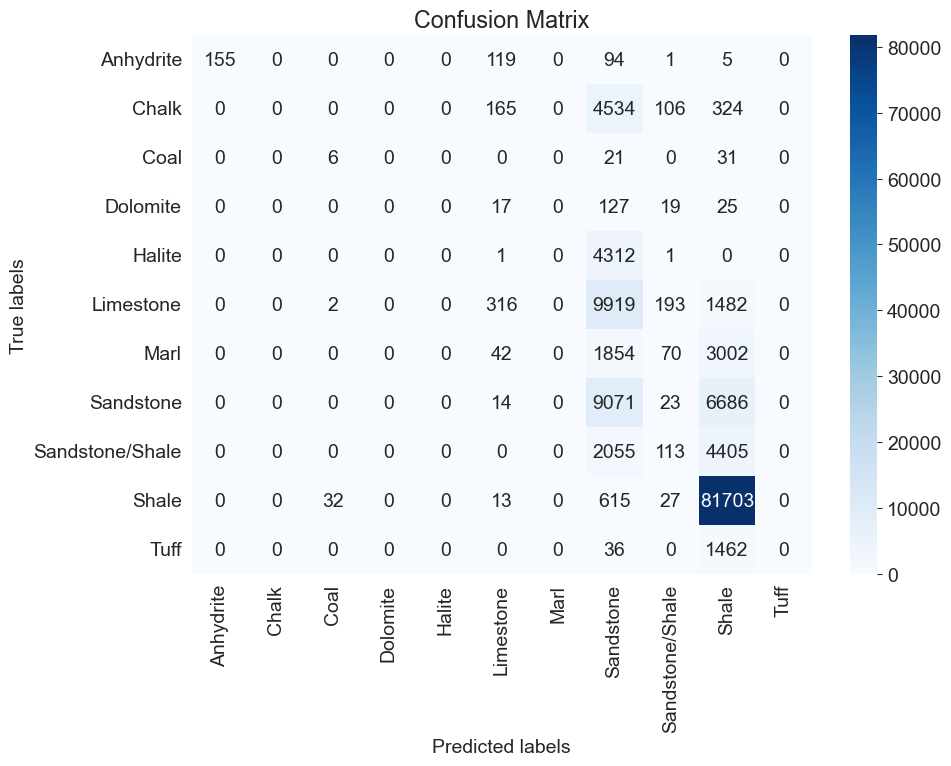

In [34]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, LR_test_preds)

conf_df = pd.DataFrame(conf_matrix, index = model_logreg.classes_, columns = model_logreg.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Визуализация результатов классификации

In [38]:
results_df.loc[:, 'LR_predictions'] = model_logreg.predict(X_test)
results_df.loc[:, 'LR_predictions'] = results_df['LR_predictions'].map(lithology_keys).map(lithology_numbers)

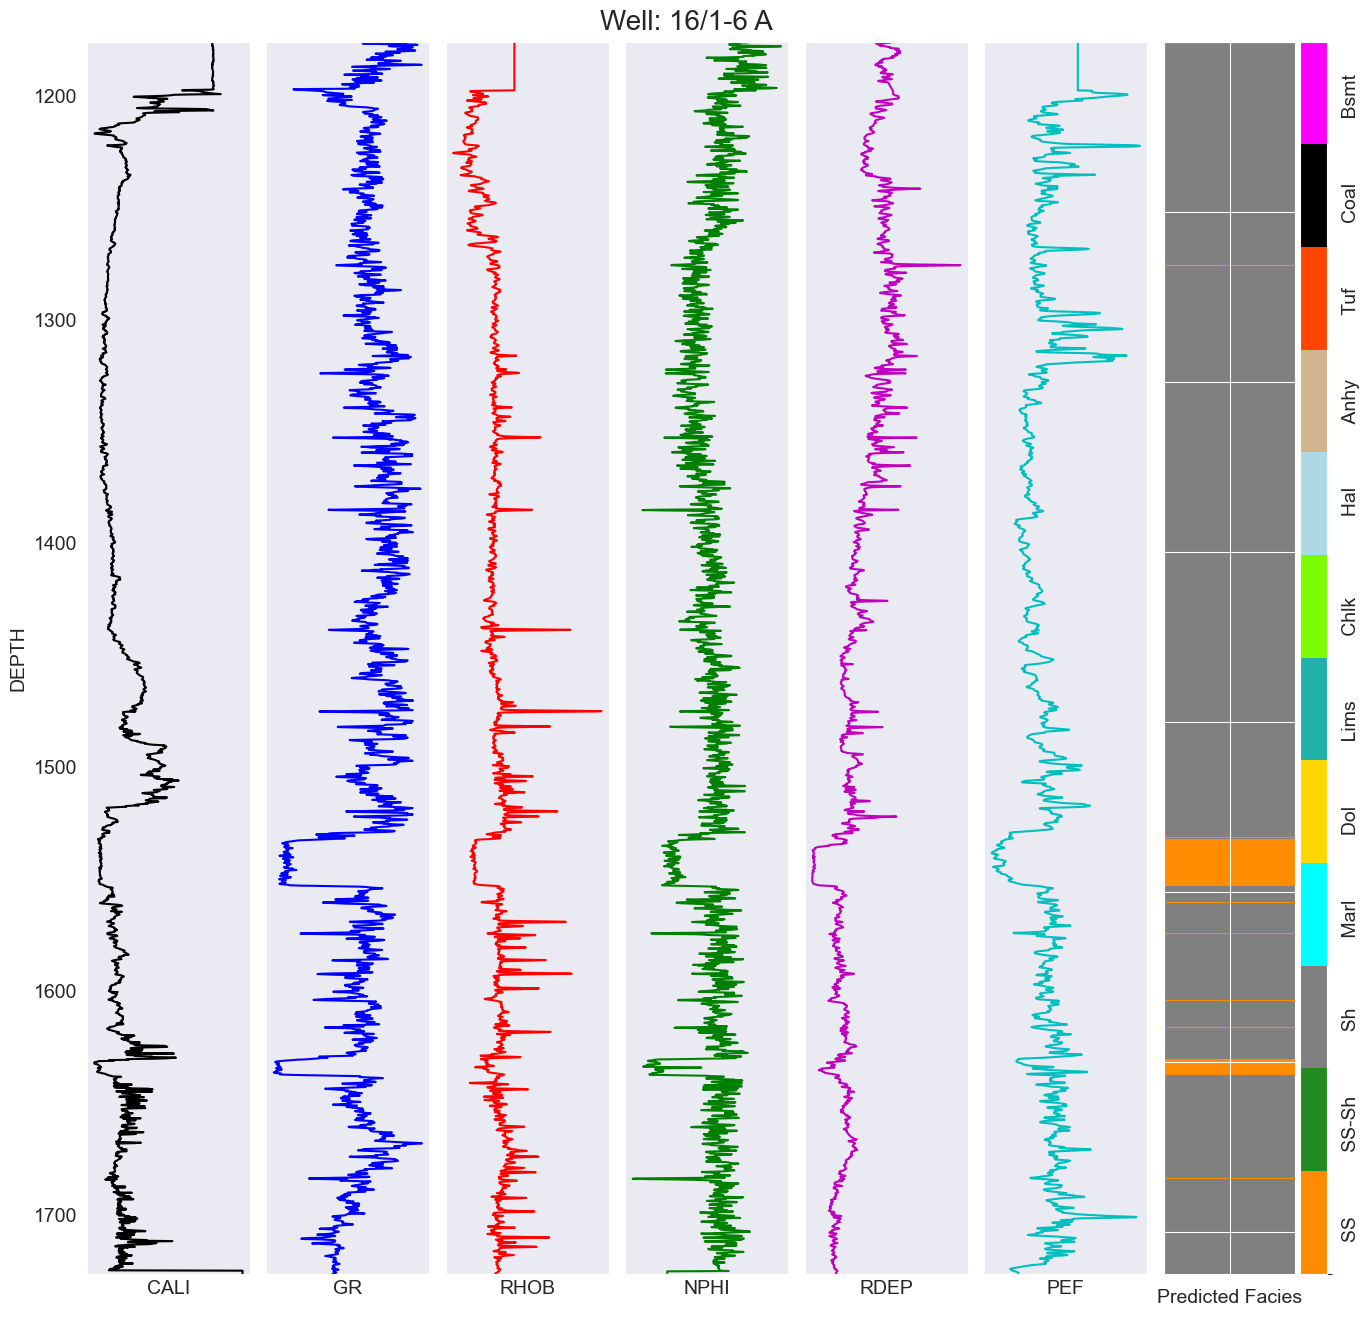

In [52]:
well_no = 4
log_plot(results_df[results_df['WELL'] == test_wells[well_no]], selected_logs, test_wells[well_no], 'LR_predictions')

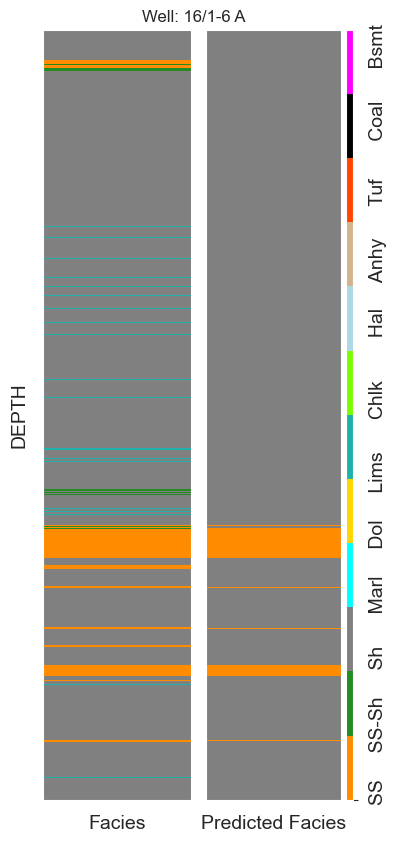

In [53]:
compare_facies(results_df[results_df['WELL'] == test_wells[well_no]], test_wells[well_no], 'LR_predictions')

Сохранение модели

In [111]:
with open('model_logreg.pkl', 'wb') as f:
    pickle.dump(model_logreg, f)

In [ ]:
from sklearn.svm import SVC

# Создание модели SVM с заданными параметрами
model_svm = SVC()

# Обучение модели на тренировочных данных
model_svm.fit(X_train, y_train)


In [ ]:
# Получение предсказаний на тренировочных данных
svm_train_preds = model_svm.predict(X_train)

# Вывод точности на тренировочной выборке
svm_train_accuracy = accuracy_score(y_train, svm_train_preds)
print(f"Accuracy на тренировочной выборке: {svm_train_accuracy:.3f}")

In [ ]:
# Получение предсказаний на тестовых данных
svm_test_preds = model_svm.predict(X_test)

# Вывод точности на тестовой выборке
svm_test_accuracy = accuracy_score(y_test, svm_test_preds)
print(f"Accuracy на тестовой выборке: {svm_test_accuracy:.3f}")


In [ ]:
# Вывод отчета о классификации на валидационной выборке
print(classification_report(y_test, svm_test_preds, digits=3, zero_division=1))

### 4.2 Решающее дерево

In [120]:
model_tree = DecisionTreeClassifier(random_state=42)

Обучение решающего дерева

In [121]:
%%time
model_tree.fit(X_train, y_train)

Wall time: 26.8 s


DecisionTreeClassifier(random_state=42)

Точность на тренировочной и тестовой выборках

In [122]:
DTC_train_preds = model_tree.predict(X_train)

In [123]:
DTC_train_accuracy = accuracy_score(DTC_train_preds, y_train)
print(f"Accuracy на тренировочной выборке: {DTC_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 1.000


In [124]:
DTC_train_probs = model_tree.predict_proba(X_train)

In [125]:
DTC_train_probs

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [129]:
DTC_test_preds = model_tree.predict(X_test)

In [130]:
DTC_test_accuracy = accuracy_score(y_test, DTC_test_preds)
print(f"Accuracy на тестовой выборке: {DTC_test_accuracy:.3f}")

Accuracy на валидационной выборке: 0.544


In [131]:
print(classification_report(y_test, DTC_test_preds))

                 precision    recall  f1-score   support

      Anhydrite       0.12      0.05      0.07       299
          Chalk       0.32      0.06      0.11      5129
           Coal       0.12      0.48      0.19        58
       Dolomite       0.00      0.02      0.01       188
         Halite       0.00      0.00      0.00      4314
      Limestone       0.35      0.37      0.36      8839
           Marl       0.08      0.06      0.07      2702
      Sandstone       0.26      0.45      0.33     12675
Sandstone/Shale       0.08      0.15      0.11      5737
          Shale       0.81      0.71      0.76     71343
           Tuff       0.05      0.17      0.08      1181

       accuracy                           0.54    112465
      macro avg       0.20      0.23      0.19    112465
   weighted avg       0.59      0.54      0.56    112465



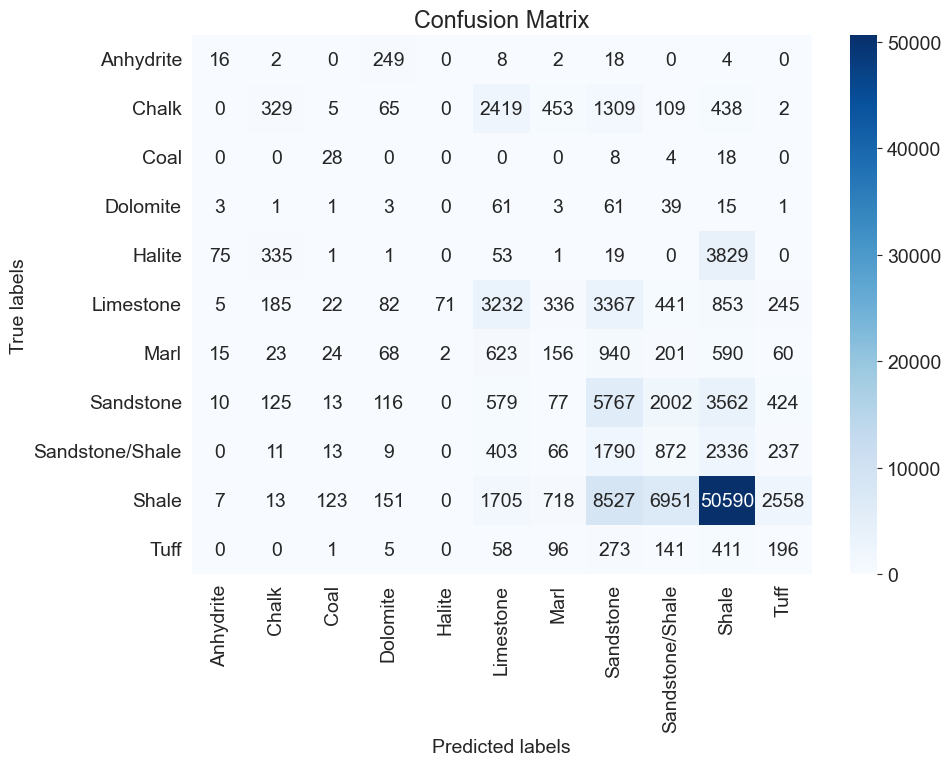

In [132]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, DTC_test_preds)

conf_df = pd.DataFrame(conf_matrix, index = model_tree.classes_, columns = model_tree.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Ограничим глубину дерева

In [112]:
model_tree2 = DecisionTreeClassifier(max_depth=8, random_state=42)

In [113]:
%%time
model_tree2.fit(X_train, y_train)

Wall time: 10.5 s


DecisionTreeClassifier(max_depth=8, random_state=42)

Точность на тренировочной и тестовой выборках

In [114]:
DTC2_train_preds = model_tree2.predict(X_train)
DTC2_train_accuracy = accuracy_score(DTC2_train_preds, y_train)
print(f"Accuracy на тренировочной выборке: {DTC2_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 0.755


In [115]:
DTC2_test_preds = model_tree2.predict(X_test)

In [116]:
DTC2_test_preds

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [117]:
DTC2_test_accuracy = accuracy_score(y_test, DTC2_test_preds)
print(f"Accuracy на тестовой выборке: {DTC2_test_accuracy:.3f}")

Accuracy на тестовой выборке: 0.718


Отчет о классификации на тестовой выборке

In [118]:
print(classification_report(y_test, DTC2_test_preds, digits=3, zero_division=1))

                 precision    recall  f1-score   support

      Anhydrite      0.985     0.695     0.815       374
          Chalk      0.649     0.176     0.277      5129
           Coal      0.400     0.379     0.389        58
       Dolomite      1.000     0.000     0.000       188
         Halite      1.000     0.000     0.000      4314
      Limestone      0.430     0.488     0.457     11912
           Marl      0.541     0.053     0.097      4968
      Sandstone      0.446     0.550     0.493     15794
Sandstone/Shale      0.244     0.176     0.204      6573
          Shale      0.841     0.953     0.894     82390
           Tuff      0.000     0.000     0.000      1498

       accuracy                          0.718    133198
      macro avg      0.594     0.315     0.330    133198
   weighted avg      0.706     0.718     0.679    133198



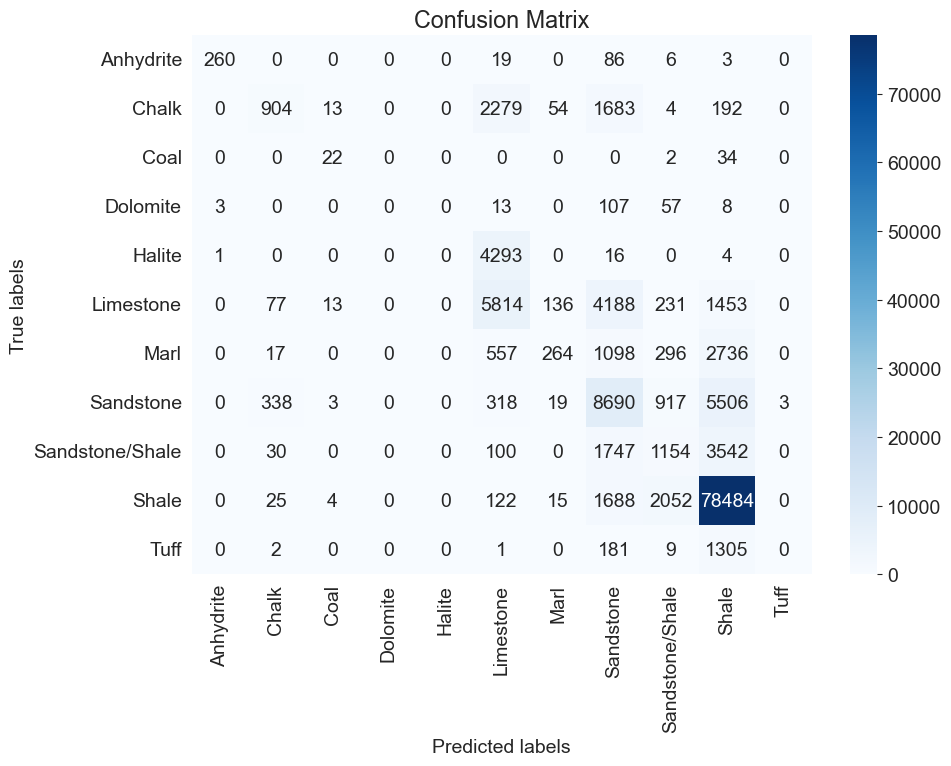

In [119]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, DTC2_test_preds)

conf_df = pd.DataFrame(conf_matrix, index = model_tree2.classes_, columns = model_tree2.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [120]:
results_df['DT_predictions'] = model_tree2.predict(X_test)
results_df['DT_predictions'] = results_df['DT_predictions'].map(lithology_keys).map(lithology_numbers)

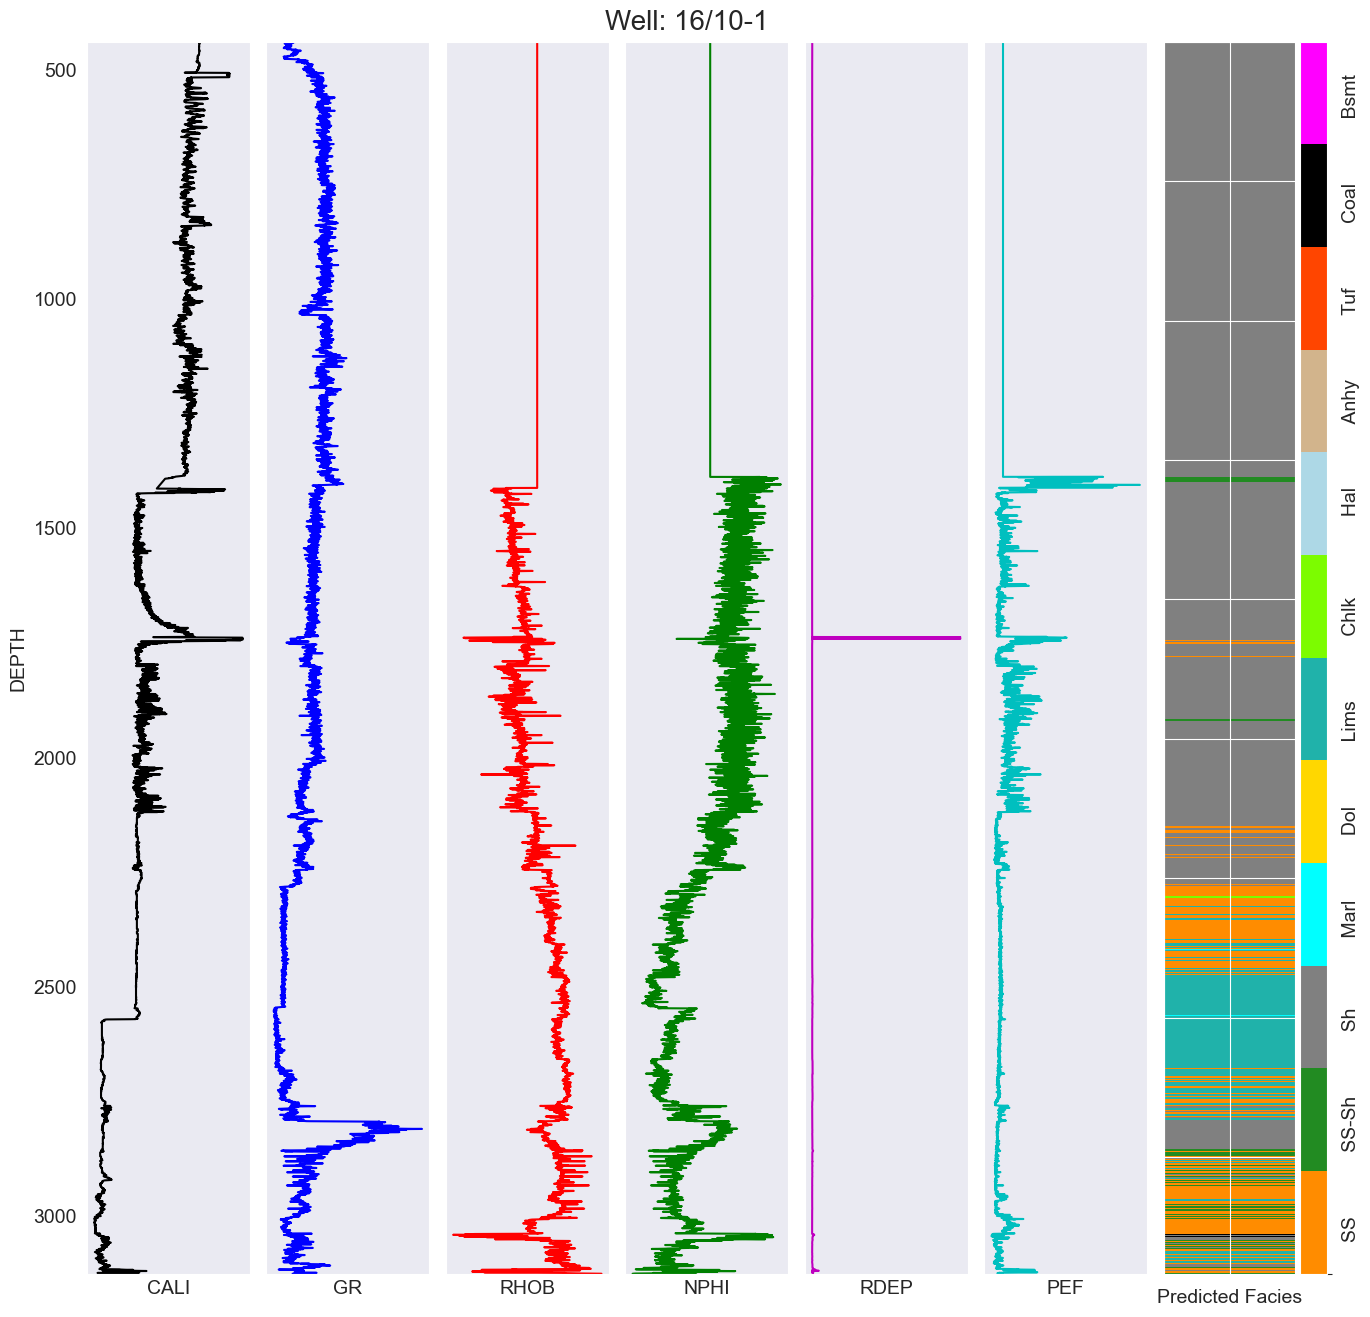

In [121]:
log_plot(results_df[results_df['WELL'] == test_wells[well_no]], selected_logs, test_wells[well_no], 'DT_predictions')

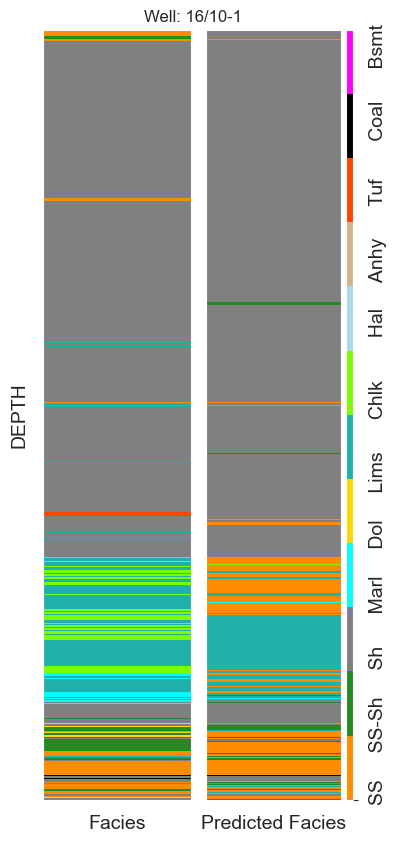

In [122]:
compare_facies(results_df[results_df['WELL'] == test_wells[well_no]], test_wells[well_no], 'DT_predictions')

Сохранение модели

In [123]:
with open('model_DT.pkl', 'wb') as f:
    pickle.dump(model_tree2, f)

### 4.3 Случайный лес

In [219]:
%%time

RF_model = RandomForestClassifier()

RF_params = {
    'n_estimators': [100, 200, 500, 700],  # количество деревьев в лесу
    'criterion': ['gini', 'entropy'],  # критерий разделения
    'max_depth': [None, 10, 20, 30, 40, 50],  # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # минимальное количество выборок для разделения узла
    'min_samples_leaf': [1, 2, 4],  # минимальное количество выборок в листовом узле
}

rs_randforest =  RandomizedSearchCV(estimator=RF_model, param_distributions=RF_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)

rs_randforest.fit(X_train, y_train)

Wall time: 9h 53s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 700]},
                   random_state=42, scoring='accuracy')

In [223]:
rs_randforest.best_params_

{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'entropy'}

In [130]:
model_randomforest = RandomForestClassifier()

In [225]:
model_randomforest.set_params(**rs_randforest.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=700)

In [131]:
model_randomforest.fit(X_train, y_train)

KeyboardInterrupt: 

In [229]:
RF_train_preds = model_randomforest.predict(X_train)
RF_train_preds

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [230]:
accuracy_score(RF_train_preds, y_train)

0.8169222038742133

In [ ]:
test_preds_ranfor = model_randomforest.predict(X_test)

In [232]:
test_preds_ranfor

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [233]:
accuracy_score(test_preds_ranfor, y_test)

0.6716673766012488

In [135]:
model_randomforest.score(inputs_val, targets_val)

0.7179856267397677

In [140]:
print(classification_report(targets_val, val_preds_ranfor))

                 precision    recall  f1-score   support

      Anhydrite       0.00      0.00      0.00         0
          Chalk       0.70      0.16      0.26      2041
           Coal       1.00      0.17      0.29        89
       Dolomite       0.00      0.00      0.00        19
      Limestone       0.31      0.41      0.35      3540
           Marl       0.03      0.04      0.03      2079
      Sandstone       0.60      0.65      0.62     10105
Sandstone/Shale       0.44      0.31      0.36     11975
          Shale       0.83      0.86      0.85     64512
           Tuff       0.00      0.00      0.00       121

       accuracy                           0.72     94481
      macro avg       0.39      0.26      0.28     94481
   weighted avg       0.72      0.72      0.71     94481



### 4.5 X-GB Classifier

In [62]:
#Кодирование целевой переменной в числовые значения
y_train_encoded = y_train.map(lithology_keys).map(lithology_numbers)

y_test_encoded = y_test.map(lithology_keys).map(lithology_numbers)

In [63]:
model_XGboost = XGBClassifier(random_state=42)

In [481]:
%%time

XGboost_params = {
    'n_estimators': [100, 200, 300, 350],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

gs_XGboost = RandomizedSearchCV(estimator=model_XGboost, param_distributions=XGboost_params, cv=3, scoring='accuracy', n_jobs=-1)

gs_XGboost.fit(X_train, y_train_encoded)

ValueError: Found input variables with inconsistent numbers of samples: [1011072, 1057943]

In [ ]:
gs_XGboost.best_params_

In [221]:
gs_XGboost.best_params_

{'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01}

In [83]:
gs_XGboost.best_estimator_.score(inputs_train, targets_train_encoded)

0.718678847244036

In [64]:
XGboost_best_params = {'n_estimators': 100,
                       'max_depth': 3,
                       'learning_rate': 0.01}

In [65]:
model_XGboost.set_params(**XGboost_best_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [66]:
%%time
model_XGboost.fit(X_train, y_train_encoded)

Wall time: 42.6 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Оценка метрик на обучающих и валидационных выборках

In [70]:
XGboost_train_preds = model_XGboost.predict(X_train)

print("Accuracy на тренировочной выборке:", accuracy_score(XGboost_train_preds, y_train_encoded))

Accuracy на тренировочной выборке: 0.7111279297345764


In [71]:
XGboost_test_preds = model_XGboost.predict(X_test)

print("Accuracy на тестовой выборке:", accuracy_score(XGboost_test_preds, y_test_encoded))

Accuracy на тестовой выборке: 0.7211294463880839


Отчет о классификации

In [72]:
print(classification_report(y_test_encoded, XGboost_test_preds, digits = 3, zero_division = 1))

              precision    recall  f1-score   support

           0      0.411     0.535     0.465     15794
           1      0.054     0.002     0.004      6573
           2      0.818     0.987     0.894     82390
           3      1.000     0.000     0.000      4968
           4      1.000     0.000     0.000       188
           5      0.416     0.400     0.408     11912
           6      0.977     0.237     0.381      5129
           7      1.000     0.000     0.000      4314
           8      0.985     0.706     0.822       374
           9      1.000     0.000     0.000      1498
          10      0.806     0.431     0.562        58

    accuracy                          0.721    133198
   macro avg      0.770     0.300     0.321    133198
weighted avg      0.718     0.721     0.662    133198



Матрица ошибок

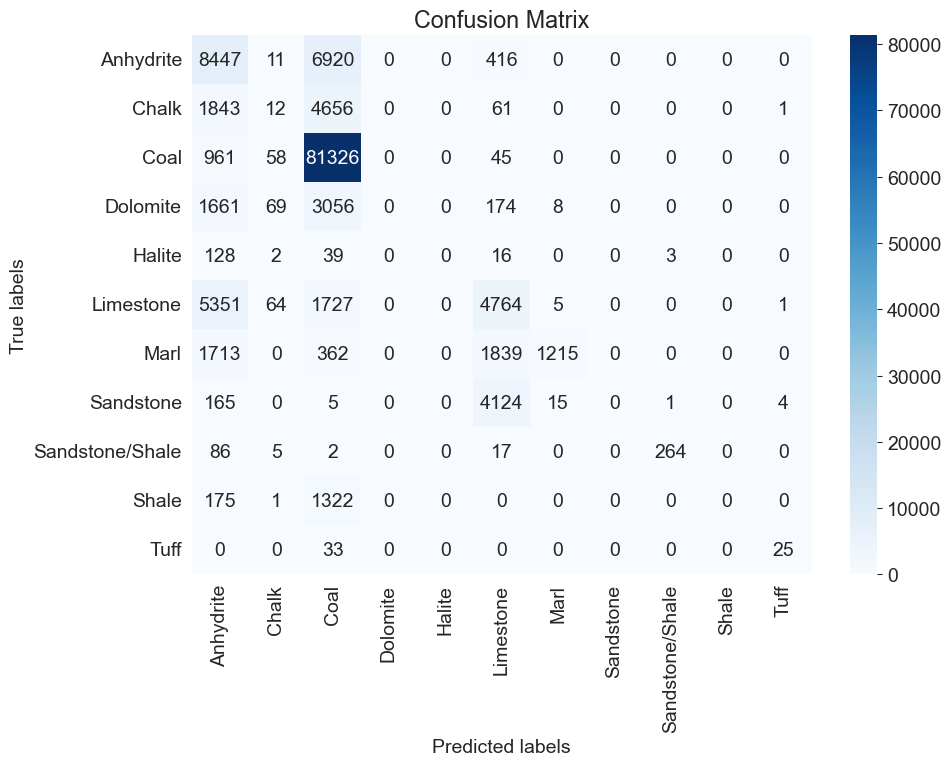

In [74]:
conf_matrix = confusion_matrix(y_test_encoded, XGboost_test_preds)

classes = ['Anhydrite', 'Chalk', 'Coal', 'Dolomite', 'Halite', 'Limestone',
       'Marl', 'Sandstone', 'Sandstone/Shale', 'Shale', 'Tuff']

conf_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [106]:
feature_importances = model_XGboost.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка признаков по важности в убывающем порядке
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

   Feature  Importance
5       GR    0.229490
6     NPHI    0.145901
1     CALI    0.106670
8      DTC    0.094334
7      PEF    0.090480
9       BS    0.084657
2     RMED    0.064641
4     RHOB    0.059985
11     DTS    0.041038
3     RDEP    0.036689
0     RSHA    0.026342
10     ROP    0.019773


Визуализация результатов классификации

In [75]:
results_df['XGboost_predictions'] = model_XGboost.predict(X_test)

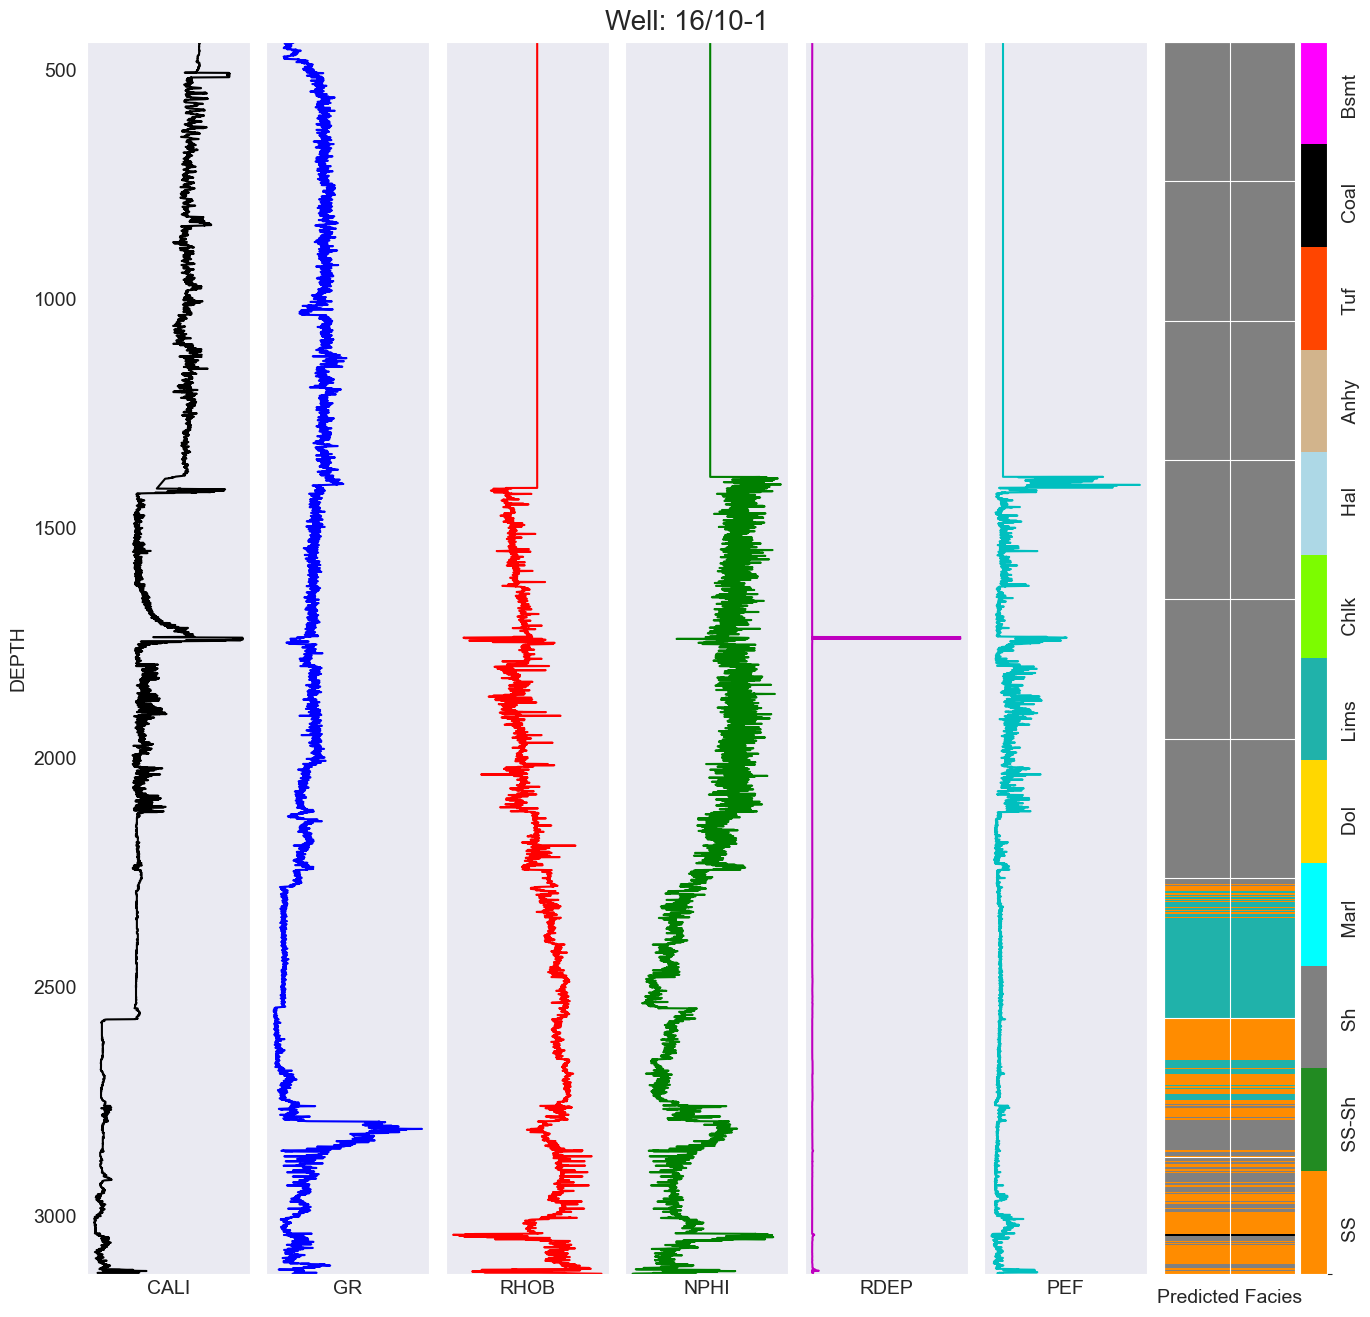

In [76]:
well_no = 5

log_plot(results_df[results_df['WELL'] == test_wells[well_no]], selected_logs, test_wells[well_no], 'XGboost_predictions')

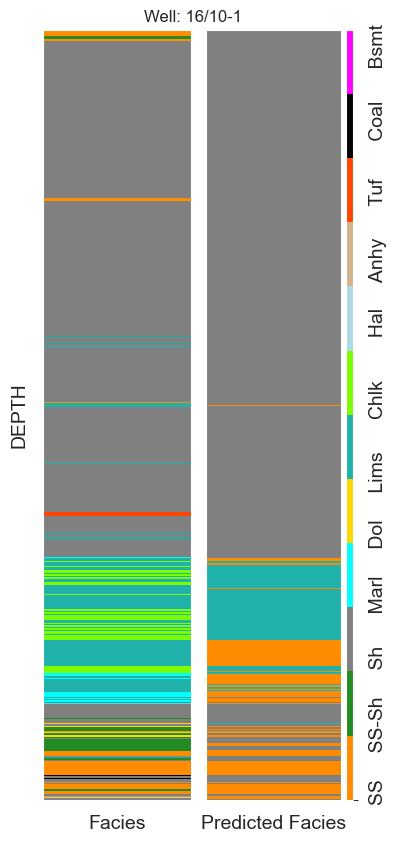

In [77]:
compare_facies(results_df[results_df['WELL'] == test_wells[well_no]], test_wells[well_no], 'XGboost_predictions')

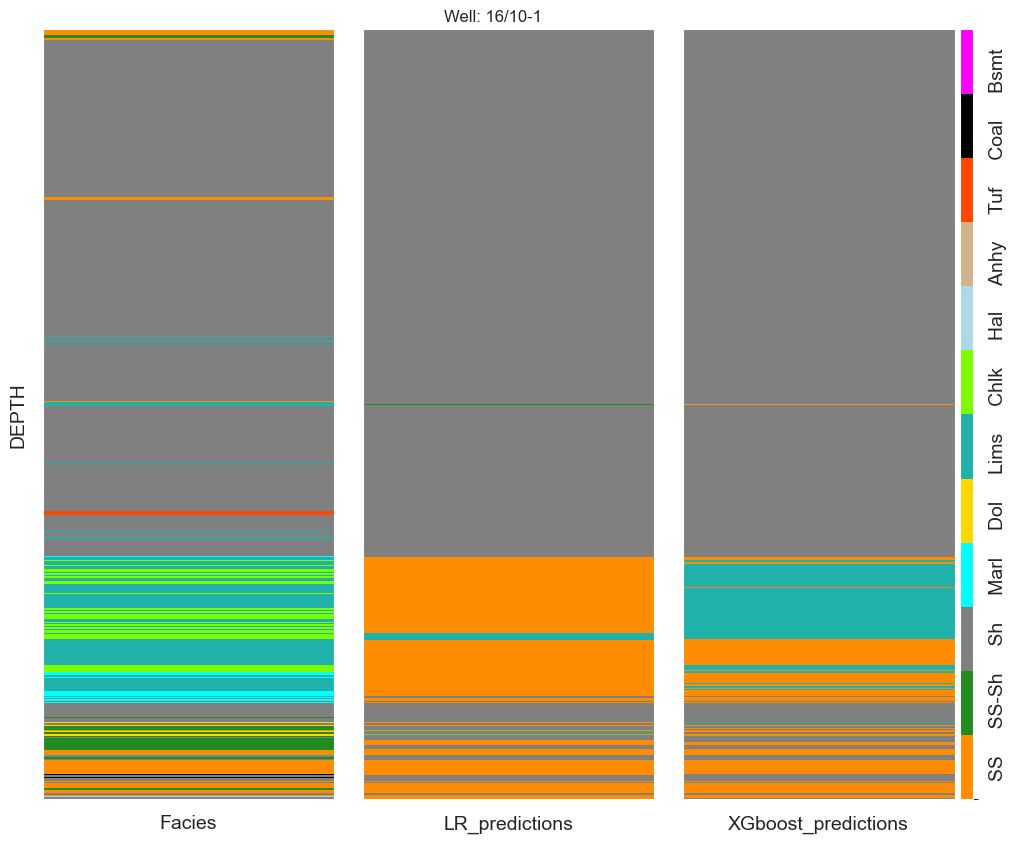

In [78]:
compare_all_facies(results_df[results_df['WELL'] == test_wells[well_no]], test_wells[well_no], ['LR_predictions', 'XGboost_predictions'])

Сохранение модели

In [107]:
import pickle

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model_XGboost, f)


In [183]:
clf_xgboost = xgb.XGBClassifier(
                                n_estimators = 108,
                                learning_rate = 0.058341077396837984,
                                max_depth = 10,
                                min_child_weight = 3.975751644687145,
                                gamma = 3.2978917680925592,
                                subsample = 0.660954379979485,
                                colsample_bytree = 0.35601189656690413
                                )

In [185]:
clf_xgboost.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.35601189656690413, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.2978917680925592,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.058341077396837984,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3.975751644687145, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=108,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [186]:
train_preds_clf_xgboost = clf_xgboost.predict(X_train)
train_preds_clf_xgboost

array([9, 9, 9, ..., 8, 8, 9], dtype=int64)

In [187]:
accuracy_score(train_preds_clf_xgboost, y_train_encoded)

0.8380161655615258

In [181]:
clf_xgboost.score(inputs_train, y_train)

0.8291776251591498

In [188]:
val_preds_clf_xgboost = clf_xgboost.predict(X_val)
val_preds_clf_xgboost

array([9, 9, 9, ..., 9, 9, 9], dtype=int64)

In [ ]:
accuracy_score(test_preds_clf_xgboost, targets_val)

In [ ]:
clf_xgboost.score(inputs_val, targets_val)

### 4.6 LGBM Classifier

In [79]:
param = {'num_leaves': 150, #120,
         'num_iterations': 500, #400,
         'max_depth': 15,
         'learning_rate': 0.05,
         'feature_fraction': 0.4, #0.5,
         'class_weight': None,
         'bagging_fraction': 0.9 #0.8
        }

In [80]:
model_lgbm = lgbm.LGBMClassifier(random_seed = 42)

In [81]:
model_lgbm.set_params(**param)

LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.4, learning_rate=0.05,
               max_depth=15, num_iterations=500, num_leaves=150,
               random_seed=42)

Обучение LGBM Classifier

In [82]:
%%time
model_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2820
[LightGBM] [Info] Number of data points in the train set: 1037210, number of used features: 12
[LightGBM] [Info] Start training from score -7.285373
[LightGBM] [Info] Start training from score -5.260858
[LightGBM] [Info] Start training from score -5.619339
[LightGBM] [Info] Start training from score -6.538825
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.4, learning_rate=0.05,
               max_depth=15, num_iterations=500, num_leaves=150,
               random_seed=42)

Получение предсказаний

In [83]:
LGBM_train_preds = model_lgbm.predict(X_train)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


In [84]:
LGBM_val_preds = model_lgbm.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


Точность на тренировочной и тестовой выборках

In [85]:
LGBM_train_accuracy = accuracy_score(LGBM_train_preds, y_train)
print(f"Accuracy на тренировочной выборке: {LGBM_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 0.905


In [86]:
LGBM_test_accuracy = accuracy_score(LGBM_val_preds, y_test)
print(f"Accuracy на тестовой выборке: {LGBM_test_accuracy:.3f}")

Accuracy на тестовой выборке: 0.722


Отчет о классификации

In [87]:
print(classification_report(y_test, LGBM_val_preds, digits = 3))

                 precision    recall  f1-score   support

      Anhydrite      0.332     0.703     0.451       374
          Chalk      0.200     0.066     0.099      5129
           Coal      0.044     0.397     0.079        58
       Dolomite      0.001     0.005     0.002       188
         Halite      0.807     0.033     0.063      4314
      Limestone      0.505     0.543     0.523     11912
           Marl      0.190     0.064     0.096      4968
      Sandstone      0.472     0.656     0.549     15794
Sandstone/Shale      0.122     0.019     0.032      6573
          Shale      0.857     0.945     0.899     82390
           Tuff      0.279     0.146     0.192      1498

       accuracy                          0.722    133198
      macro avg      0.346     0.325     0.271    133198
   weighted avg      0.682     0.722     0.683    133198



Матрица ошибок

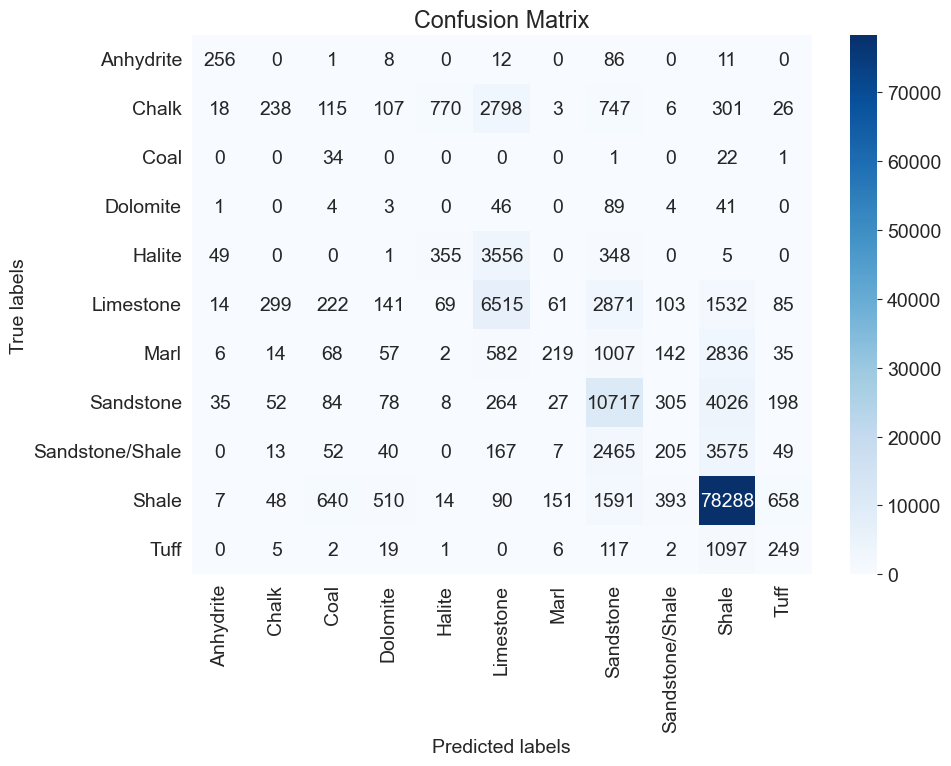

In [174]:
conf_matrix = confusion_matrix(y_test, LGBM_val_preds)

conf_df = pd.DataFrame(conf_matrix, index=model_lgbm.classes_, columns=model_lgbm.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [88]:
results_df['LGBM_predictions'] = LGBM_val_preds
results_df['LGBM_predictions'] = results_df['LGBM_predictions'].map(lithology_keys).map(lithology_numbers)

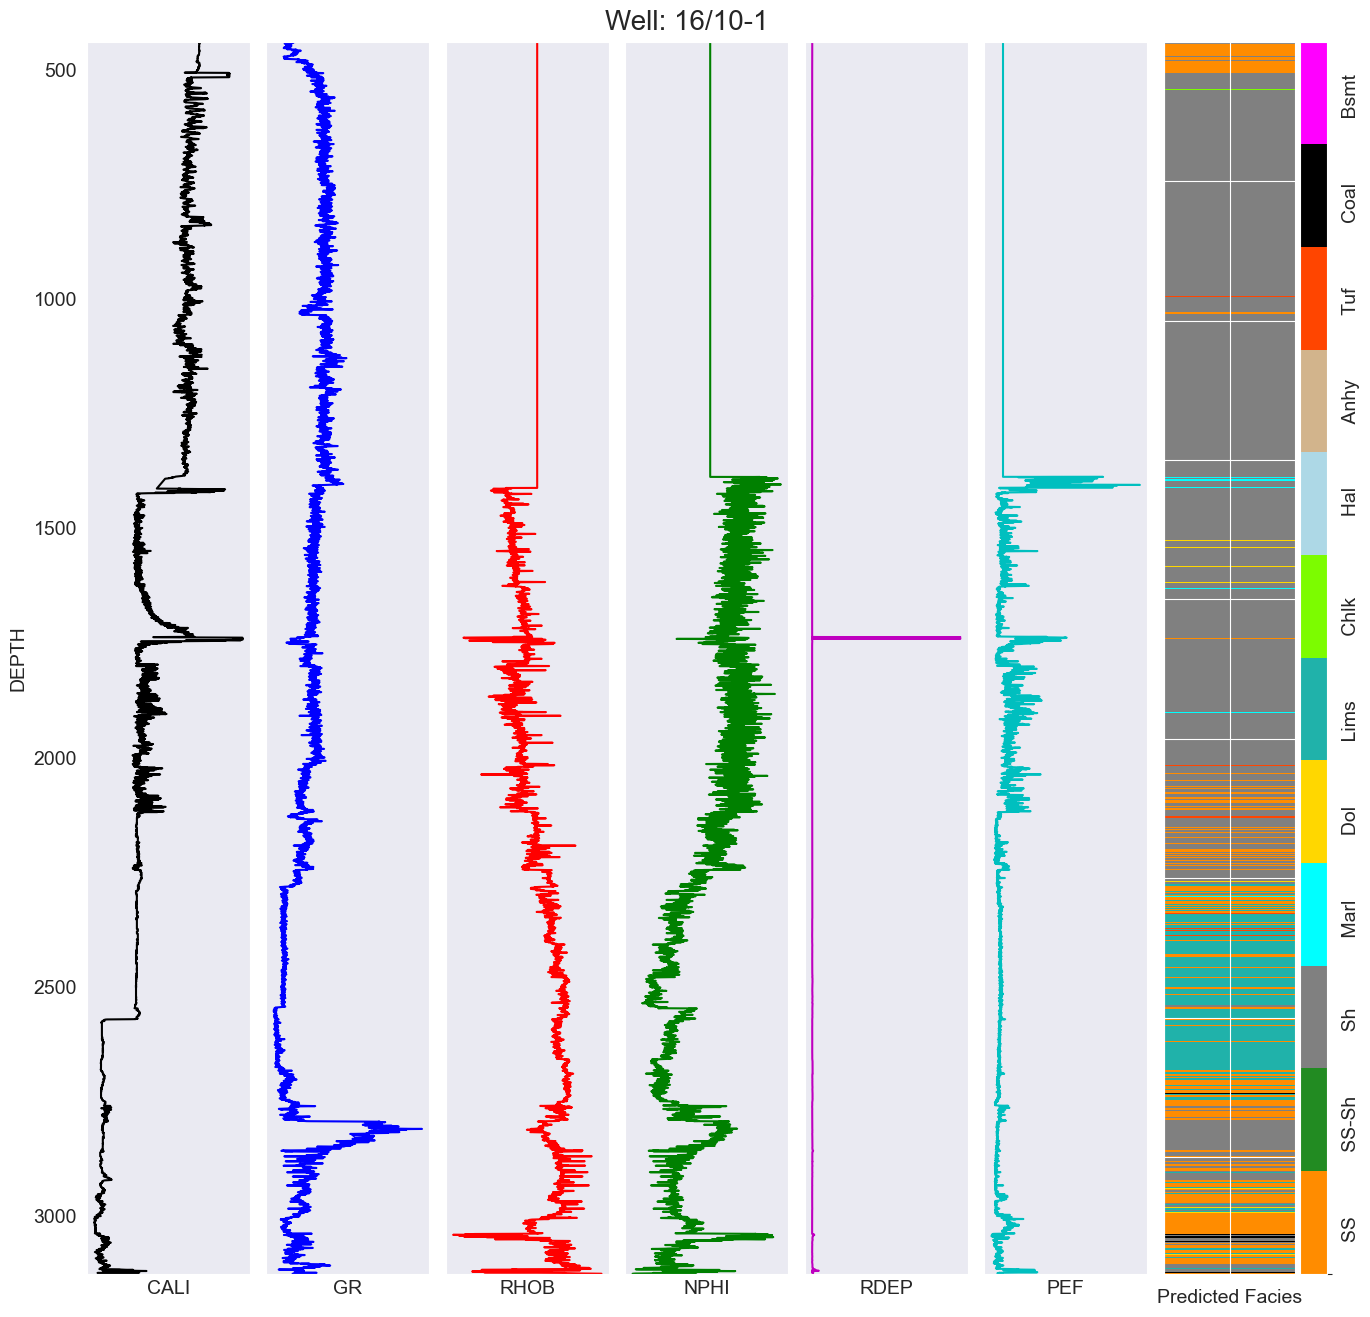

In [89]:
well_no = 5

log_plot(results_df[results_df['WELL'] == test_wells[well_no]], selected_logs, test_wells[well_no], 'LGBM_predictions')

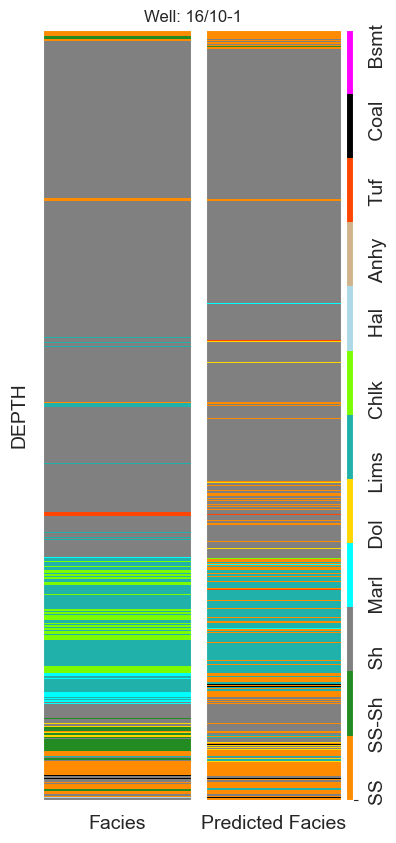

In [90]:
compare_facies(results_df[results_df['WELL'] == test_wells[well_no]], test_wells[well_no], 'LGBM_predictions')

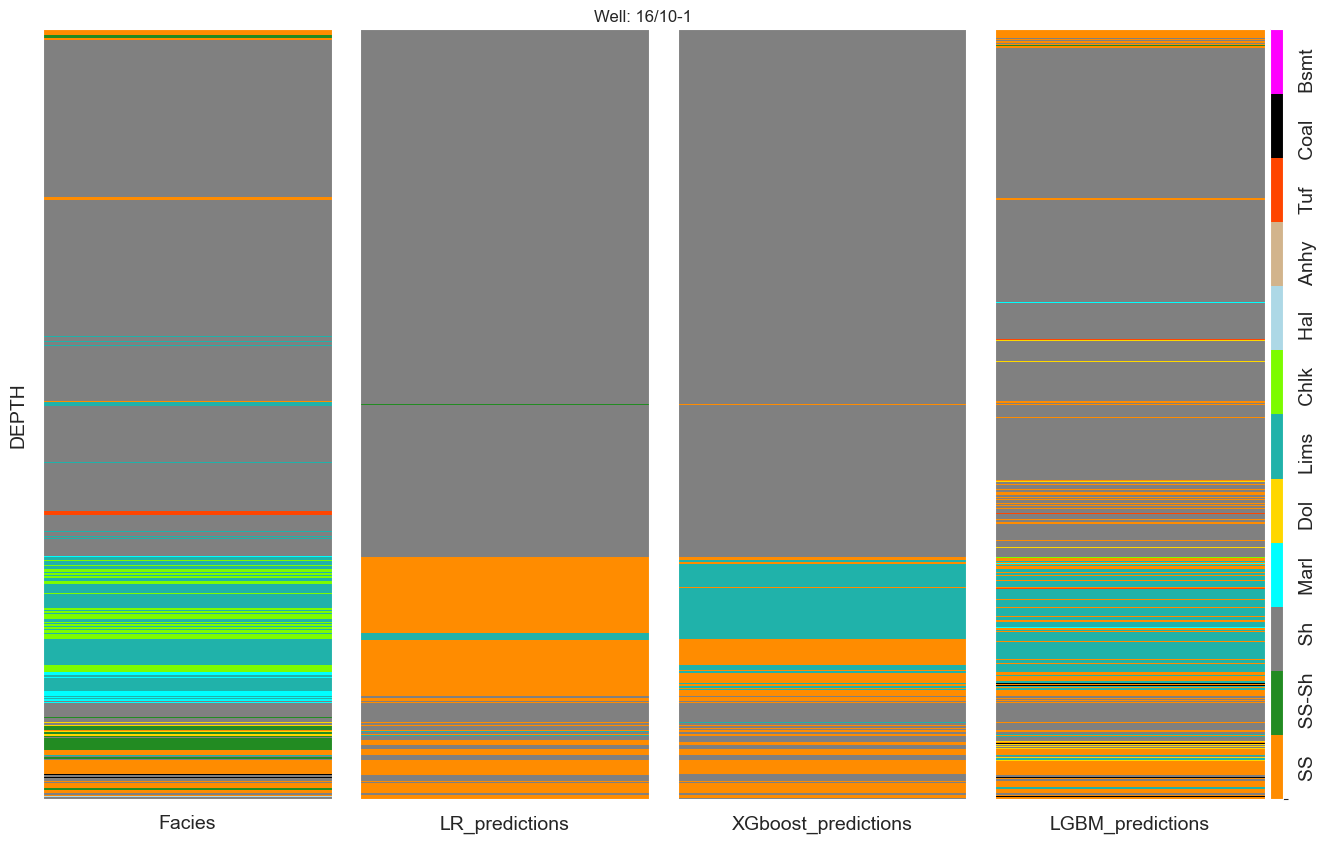

In [91]:
compare_all_facies(results_df[results_df['WELL'] == test_wells[well_no]], test_wells[well_no], ['LR_predictions', 'XGboost_predictions', 'LGBM_predictions'])

Сохранение модели

In [124]:
with open('model_lgbm.pkl', 'wb') as f:
    pickle.dump(model_lgbm, f)

### 4.7 Catboost Classifier

In [92]:
catboost_model = CatBoostClassifier(random_seed = 42)

In [482]:
%%time

CatBoost_params = {
    'iterations': [1200, 300, 400, 500],  # количество итераций
    'learning_rate': [0.01, 0.05, 0.1],  # скорость обучения
    'depth': [4, 6, 8],  # глубина деревьев
    'border_count': [32, 64, 128],  # число бинов для числовых признаков
}


rs_catboost =  RandomizedSearchCV(estimator=catboost_classifier, param_distributions=CatBoost_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)

rs_catboost.fit(X_train, y_train)

NameError: name 'inputs_train' is not defined

In [483]:
rs_catboost.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [93]:
catboost_best_params = {'learning_rate': 0.01,
          'l2_leaf_reg': 1,
          'iterations': 400,
          'depth': 4,
          'border_count': 64}

catboost_model.set_params(**catboost_best_params)

In [94]:
%%time
catboost_model.fit(X_train, y_train)

0:	learn: 2.3491629	total: 919ms	remaining: 6m 6s
1:	learn: 2.3040055	total: 1.51s	remaining: 5m
2:	learn: 2.2621838	total: 2.03s	remaining: 4m 28s
3:	learn: 2.2228520	total: 2.56s	remaining: 4m 13s
4:	learn: 2.1862840	total: 3.07s	remaining: 4m 2s
5:	learn: 2.1518652	total: 3.55s	remaining: 3m 53s
6:	learn: 2.1192076	total: 4.07s	remaining: 3m 48s
7:	learn: 2.0883847	total: 4.57s	remaining: 3m 43s
8:	learn: 2.0590631	total: 5.13s	remaining: 3m 42s
9:	learn: 2.0312776	total: 5.64s	remaining: 3m 40s
10:	learn: 2.0048341	total: 6.13s	remaining: 3m 36s
11:	learn: 1.9793617	total: 6.71s	remaining: 3m 36s
12:	learn: 1.9549729	total: 7.23s	remaining: 3m 35s
13:	learn: 1.9316950	total: 7.72s	remaining: 3m 32s
14:	learn: 1.9093281	total: 8.28s	remaining: 3m 32s
15:	learn: 1.8878726	total: 8.81s	remaining: 3m 31s
16:	learn: 1.8667795	total: 9.35s	remaining: 3m 30s
17:	learn: 1.8467820	total: 9.87s	remaining: 3m 29s
18:	learn: 1.8272887	total: 10.3s	remaining: 3m 27s
19:	learn: 1.8086387	total: 

158:	learn: 0.9944973	total: 1m 26s	remaining: 2m 10s
159:	learn: 0.9926909	total: 1m 26s	remaining: 2m 10s
160:	learn: 0.9910145	total: 1m 27s	remaining: 2m 9s
161:	learn: 0.9890793	total: 1m 27s	remaining: 2m 9s
162:	learn: 0.9873978	total: 1m 28s	remaining: 2m 8s
163:	learn: 0.9857089	total: 1m 28s	remaining: 2m 7s
164:	learn: 0.9839435	total: 1m 29s	remaining: 2m 7s
165:	learn: 0.9821908	total: 1m 29s	remaining: 2m 6s
166:	learn: 0.9804439	total: 1m 30s	remaining: 2m 6s
167:	learn: 0.9788646	total: 1m 31s	remaining: 2m 5s
168:	learn: 0.9772445	total: 1m 31s	remaining: 2m 5s
169:	learn: 0.9755208	total: 1m 32s	remaining: 2m 4s
170:	learn: 0.9739540	total: 1m 32s	remaining: 2m 4s
171:	learn: 0.9724472	total: 1m 33s	remaining: 2m 3s
172:	learn: 0.9708996	total: 1m 33s	remaining: 2m 3s
173:	learn: 0.9694281	total: 1m 34s	remaining: 2m 2s
174:	learn: 0.9679608	total: 1m 34s	remaining: 2m 1s
175:	learn: 0.9664850	total: 1m 35s	remaining: 2m 1s
176:	learn: 0.9650745	total: 1m 35s	remainin

312:	learn: 0.8461744	total: 2m 52s	remaining: 47.9s
313:	learn: 0.8456555	total: 2m 53s	remaining: 47.4s
314:	learn: 0.8452334	total: 2m 53s	remaining: 46.8s
315:	learn: 0.8447636	total: 2m 54s	remaining: 46.3s
316:	learn: 0.8442254	total: 2m 54s	remaining: 45.8s
317:	learn: 0.8437206	total: 2m 55s	remaining: 45.2s
318:	learn: 0.8431964	total: 2m 55s	remaining: 44.7s
319:	learn: 0.8427042	total: 2m 56s	remaining: 44.1s
320:	learn: 0.8421767	total: 2m 57s	remaining: 43.6s
321:	learn: 0.8417171	total: 2m 57s	remaining: 43s
322:	learn: 0.8412409	total: 2m 58s	remaining: 42.5s
323:	learn: 0.8407543	total: 2m 58s	remaining: 41.9s
324:	learn: 0.8403316	total: 2m 59s	remaining: 41.4s
325:	learn: 0.8398895	total: 2m 59s	remaining: 40.8s
326:	learn: 0.8394920	total: 3m	remaining: 40.3s
327:	learn: 0.8391138	total: 3m	remaining: 39.7s
328:	learn: 0.8386868	total: 3m 1s	remaining: 39.2s
329:	learn: 0.8381734	total: 3m 2s	remaining: 38.7s
330:	learn: 0.8377006	total: 3m 2s	remaining: 38.1s
331:	l

Получение предсказаний

In [96]:
CB_train_preds = catboost_model.predict(X_train)

In [97]:
CB_test_preds = catboost_model.predict(X_test)

Точность на тренировочной и тестовой выборках

In [98]:
CB_train_accuracy = accuracy_score(CB_train_preds, y_train)
print(f"Accuracy на тренировочной выборке: {CB_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 0.731


In [99]:
CB_test_accuracy = accuracy_score(CB_test_preds, y_test)
print(f"Accuracy на тестовой выборке: {CB_test_accuracy:.3f}")

Accuracy на тестовой выборке: 0.730


In [100]:
print(classification_report(y_test, CB_test_preds, digits = 3, zero_division = 1))

                 precision    recall  f1-score   support

      Anhydrite      1.000     0.000     0.000       374
          Chalk      1.000     0.000     0.000      5129
           Coal      0.765     0.448     0.565        58
       Dolomite      1.000     0.000     0.000       188
         Halite      0.840     0.073     0.135      4314
      Limestone      0.604     0.530     0.565     11912
           Marl      1.000     0.000     0.000      4968
      Sandstone      0.385     0.587     0.465     15794
Sandstone/Shale      0.368     0.031     0.056      6573
          Shale      0.830     0.984     0.900     82390
           Tuff      1.000     0.000     0.000      1498

       accuracy                          0.730    133198
      macro avg      0.799     0.241     0.244    133198
   weighted avg      0.750     0.730     0.670    133198



Матрица ошибок

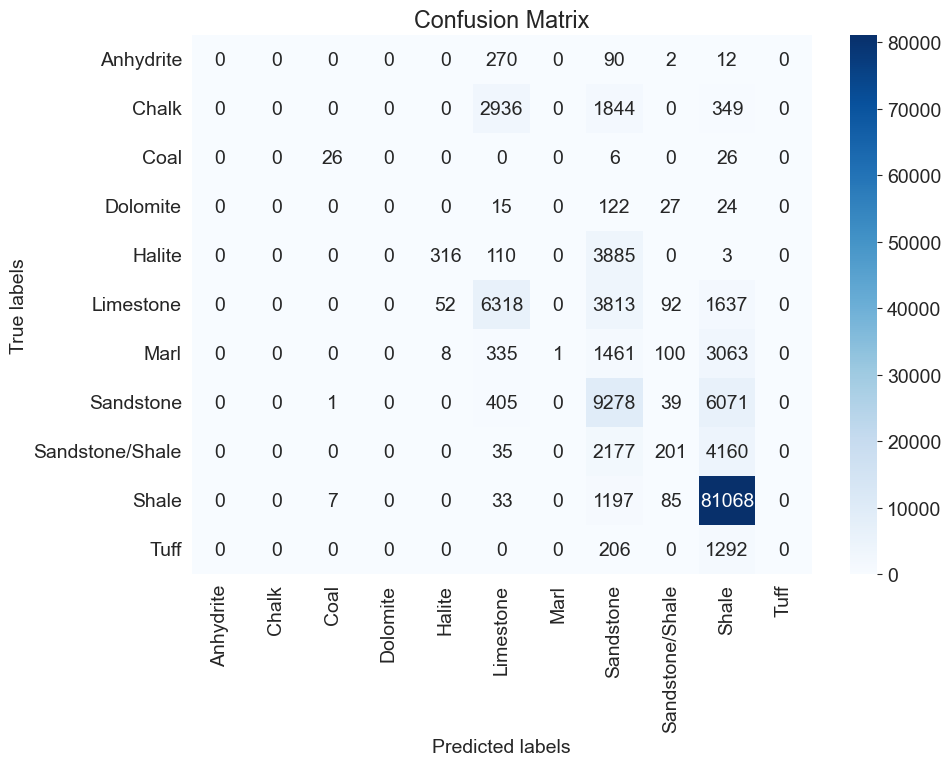

In [101]:
conf_matrix = confusion_matrix(y_test, CB_test_preds)

conf_df = pd.DataFrame(conf_matrix, index=catboost_model.classes_, columns=catboost_model.classes_)

# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [102]:
results_df['CB_predictions'] = CB_test_preds
results_df['CB_predictions'] = results_df['CB_predictions'].map(lithology_keys).map(lithology_numbers)

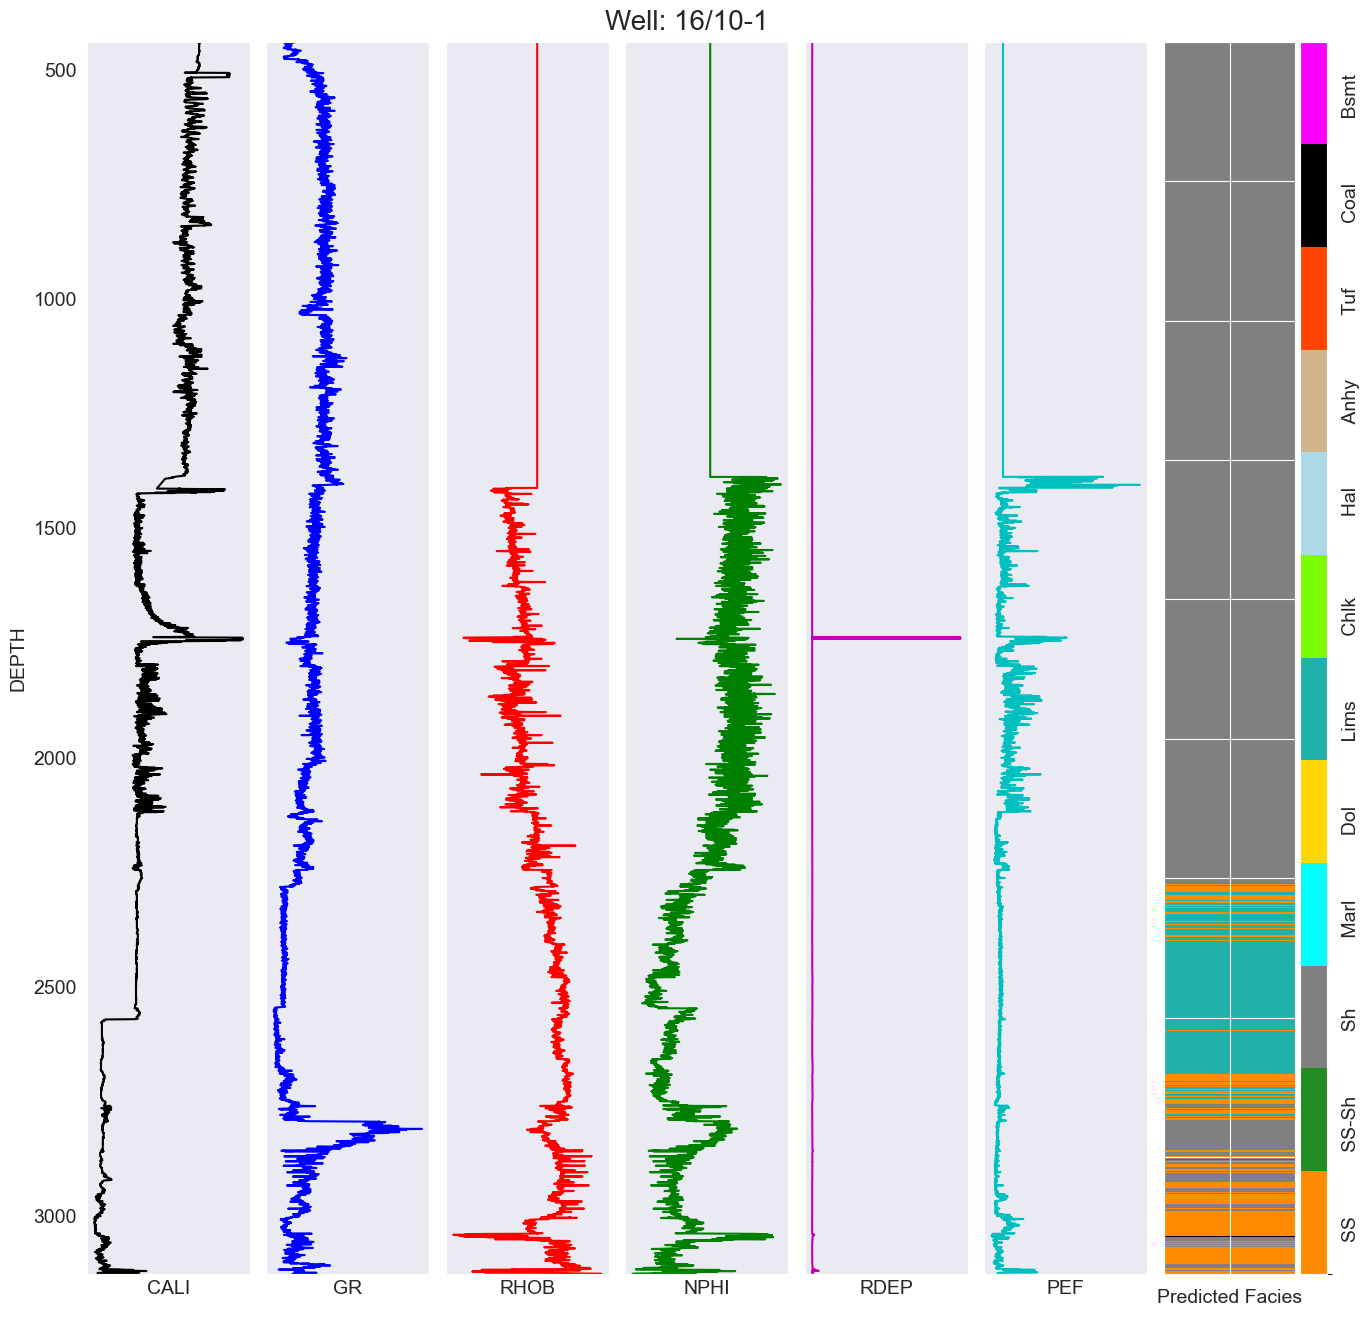

In [103]:
well_no = 5

log_plot(results_df[results_df['WELL'] == test_wells[well_no]], selected_logs, test_wells[well_no], 'CB_predictions')

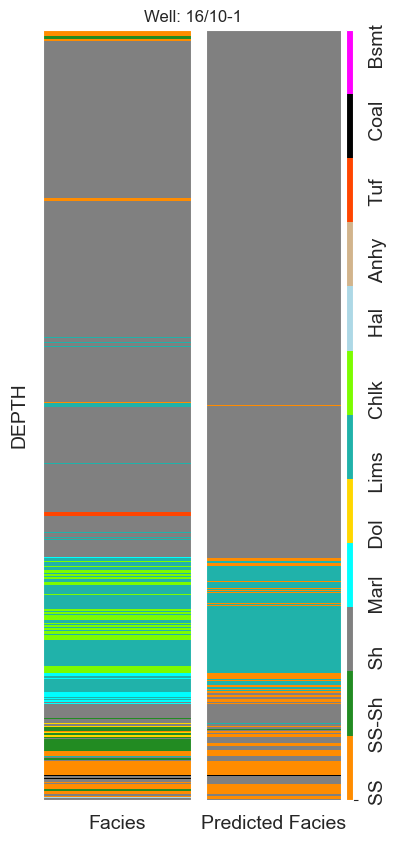

In [104]:
compare_facies(results_df[results_df['WELL'] == test_wells[well_no]], test_wells[well_no], 'CB_predictions')

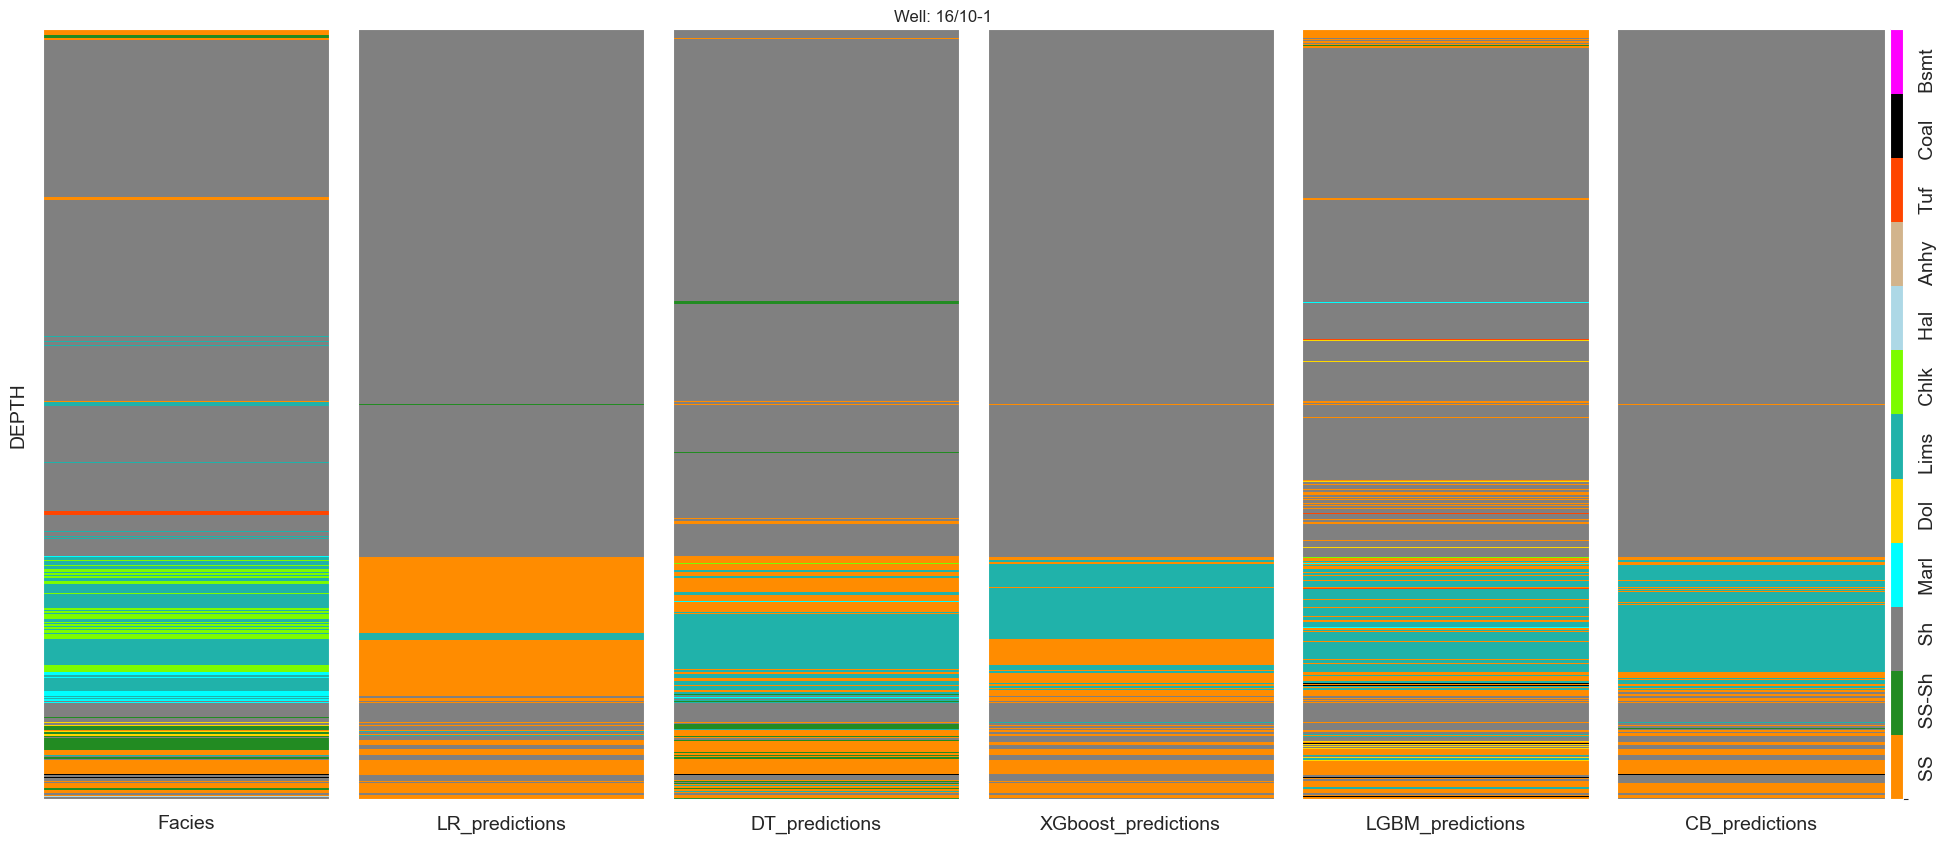

In [127]:
compare_all_facies(results_df[results_df['WELL'] == test_wells[well_no]], test_wells[well_no], ['LR_predictions', 'DT_predictions', 'XGboost_predictions','LGBM_predictions', 'CB_predictions'])

Сохранение модели

In [125]:
with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(catboost_model, f)

## 5. Сравнение метрик